note: the notebook is best navigated if you have jupyter nbextensions installed which allows you to navigate between sections easily or by using the sections in jupyterlab.

In [5]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sys import exit
import pandas as pd
import glob
import pickle
from textwrap import wrap
import time
import math
import scipy
import itertools
from scipy import signal## because scipy doesn't always load its submodules for some reason
from scipy import stats
import scipy.integrate as integrate
from sklearn.metrics.cluster import adjusted_rand_score
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, pairwise_distances
from scipy.optimize import fsolve
import scipy.optimize
from scipy.stats import levy_stable
import sys
sys.path.append('/Users/ashish/Dropbox/research/James-research/city establishment data/')
import timeit
import powerlaw
import shared_analysis_functions as shared_func
import importlib
importlib.reload(shared_func)
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance as scipy_spatial_distance
import scipy.io
import warnings
from matplotlib.ticker import ScalarFormatter,FormatStrFormatter 
BLS_fit_params_path='/Users/ashish/Box/research/James/BLS data/processed_BLS_data/fit_parameters/'
# 


def create_color_list(scheme_name='sns_tab10',num_colors=6): 
    #https://matplotlib.org/3.1.0/gallery/color/named_colors.html
    #https://seaborn.pydata.org/tutorial/color_palettes.html
    if scheme_name.lower()=='tableau':
        color_list=list(mcolors.TABLEAU_COLORS.values())## only had 10 colors
    elif scheme_name.lower()=='css':
        color_list=list(mcolors.CSS4_COLORS.values())
    elif scheme_name.lower()=='base':
        color_list=list(mcolors.BASE_COLORS.values())
    elif scheme_name.lower()=='sns_tab10':
        color_list=list(sns.color_palette(palette='tab10',n_colors=num_colors))
    elif scheme_name.lower()=='sns_deep':
        color_list=list(sns.color_palette(palette='deep',n_colors=num_colors))
    elif scheme_name.lower()=='sns_muted':
        color_list=list(sns.color_palette(palette='muted',n_colors=num_colors))
    elif scheme_name.lower()=='sns_colorblind':
        color_list=list(sns.color_palette(palette='colorblind',n_colors=num_colors))
    elif scheme_name.lower()=='sns_spectral':
        color_list=list(sns.color_palette(palette='Spectral',n_colors=num_colors))
    else:
        print ('scheme not implemented')
    if 'sns' not in scheme_name.lower():
        color_list=[color for color in color_list if sum(mcolors.to_rgb(color))<2.5] ## remove white
        mcolors.to_rgb(color_list[0])
    return  color_list
color_list_def=create_color_list()

def get_abundant_and_prevalent_species_idx(otu_abu_t_mat_full,time_points):
    prev_cutoff=len(time_points)/2
    abu_cutoff=1e-3
    prev_idx=np.where( np.sum(otu_abu_t_mat_full>0,axis=1) >prev_cutoff )[0]
    abu_idx=np.where( np.mean(otu_abu_t_mat_full,axis=1) >abu_cutoff )[0]
    sp_idx=np.intersect1d(abu_idx,prev_idx)
    return sp_idx


def get_logG_microbes(otu_abu_t_mat_full, time_points, tau):
    sp_idx=get_abundant_and_prevalent_species_idx(otu_abu_t_mat_full,time_points)
    otu_abu_t_mat=otu_abu_t_mat_full[sp_idx]

    ## find time stampindexes that are one data apart
    idx_1_list=[]
    idx_2_list=[]
    for j,t2 in enumerate(time_points):
        if np.any(time_points==t2-tau):
            i=int(np.where(time_points==t2-tau)[0])
            t1=time_points[i]
    #         print (i,j, t1, t2)
            idx_1_list.append(i)
            idx_2_list.append(j)
    idxs_1=np.array(idx_1_list)
    idxs_2=np.array(idx_2_list)
    otu_t2=np.ravel(otu_abu_t_mat[:,idxs_2])
    otu_t1=np.ravel(otu_abu_t_mat[:,idxs_1])
    idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
    
    # idx_nonzero=np.intersect1d(np.nonzer)
    growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
    log_g=np.log(growth_rates)
    return log_g


def get_BCI_relabu_by_clust(df_counts, n_BCI_clusts):
    '''
    returns data frame like df_counts where the relative abundance of each tree species is returned
    relabu is calculated relative to total abundance of trees within that height cluster 
    and NOT the total abundance of all trees in the forest.
    '''
    df_BCI_rel_clust=df_counts.copy()
    for clust_id in range(1,n_BCI_clusts+1):
        df_clusti=df_counts[df_counts['height_cluster']==clust_id]
        BCI_popn=df_clusti[BCI_year_list].values
        BCI_f=BCI_popn/np.sum(BCI_popn,axis=0)
        df_BCI_rel_clust.loc[df_BCI_rel_clust['height_cluster']==clust_id,BCI_year_list] = BCI_f
    
    return df_BCI_rel_clust


# def get_BCI_absabu_by_clust(df_counts, n_BCI_clusts):
#     '''
#     returns data frame like df_counts where the absolute abundance of each tree species is returned
#     '''
#     df_BCI_abs_clust=df_counts.copy()
#     for clust_id in range(1,n_BCI_clusts+1):
#         df_clusti=df_counts[df_counts['height_cluster']==clust_id]
#         BCI_popn=df_clusti[BCI_year_list].values
#         BCI_f=BCI_popn/np.sum(BCI_popn,axis=0)
#         df_BCI_rel_clust.loc[df_BCI_rel_clust['height_cluster']==clust_id,BCI_year_list] = BCI_f
    
#     return df_BCI_rel_clust


def get_BCI_clust_logG(df_counts,clust_id ):
    df_clusti=df_counts[df_counts['height_cluster']==clust_id]
    BCI_popn=df_clusti[BCI_year_list].values
    BCI_fold_change=BCI_popn[:,1:]/BCI_popn[:,:-1]
    BCI_fold_change=np.ravel(BCI_fold_change[np.nonzero(BCI_popn[:,:-1])])
    BCI_logG_clusti=np.log(BCI_fold_change[BCI_fold_change>0])
    
    return BCI_logG_clusti
# fontSize=12
# fontSizeSmall=10
# labelSize=8
# sns.set(rc= {'figure.facecolor':'white'}) #'axes.facecolor':'cornflowerblue',
'''
figure size and font settings
'''   
## figure settings
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

BIGGEST_SIZE = 18
mpl.rcParams.update(mpl.rcParamsDefault)
# plt.rcParams["axes.grid"] = False
# # plt.rcParams.update({"axes.facecolor" : "white","axes.edgecolor":  "black"})
# # plt.rc('font', size=SMALL_SIZE, family='sans-serif', serif='Arial')          # controls default text sizes
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE, titleweight='bold')     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE, labelweight='bold')    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rc('text')

subplot_label_list=['A','B','C','D','E','F','G','H','I','J','K','L']

combined_params_path='/Users/ashish/Box/research/James/combined fit params/'

issue to resolve: "[Errno 5] Input/output error?" that occurs occasionaly which needs me to reload packages. maybe due to box? some issue with filesystem

## read data

In [6]:

#### Microbiobiome data
# matlab_data_path='/Users/ashish/Documents/GitHub/Macroecological-Relationships_Ji_Dixit_Vitkup/matData/'
matlab_data_path='/Users/ashish/Box/research/James/microbiome data/Ji_dixit_vitkup study/'
output_path='/Users/ashish/Box/research/James/microbiome data/Ji_dixit_vitkup study/'
temp = scipy.io.loadmat(matlab_data_path+'caporaso.mat')
caporaso=deepcopy(temp)
caporaso['f4_rel_abu']=caporaso['f4']/np.sum(caporaso['f4'],axis=0)
caporaso['m3_rel_abu']=caporaso['m3']/np.sum(caporaso['m3'],axis=0)
genus_names_full=caporaso['gtax']






#### BCI data
BCI_processed_path='/Users/ashish/Box/research/James/BCI data/processed_BCI_data/'
BCI_year_list=['Y1990','Y1995','Y2000','Y2005']
# df_counts = pd.read_csv(
#     BCI_processed_path+'df_counts.csv', index_col=0)
df_counts = pd.read_csv(
    BCI_processed_path+'df_counts_with_clust.csv', index_col=0)
n_BCI_clusts=4
df_BCI_rel_clust=get_BCI_relabu_by_clust(df_counts, n_BCI_clusts)

BCI_popn=df_counts[BCI_year_list].values
BCI_fold_change=BCI_popn[:,1:]/BCI_popn[:,:-1]
BCI_fold_change=np.ravel(BCI_fold_change[np.nonzero(BCI_popn[:,:-1])])
BCI_logG=np.log(BCI_fold_change[BCI_fold_change>0])
tree_clust_names=['shrubs','understory treelets', 'midstory trees', 'canopy trees']  

cluster_file_name='/Users/ashish/Box/research/James/BCI data/rafael clustering/trait clustering 2020 paper/BCI_heightclusters.csv'
df_rafael_clusts=pd.read_csv(cluster_file_name,encoding='ISO-8859–1')
#### BLS data
BLS_processed_path='/Users/ashish/Box/research/James/BLS data/processed_BLS_data/'
# df_metro_time = pd.read_csv(
#     BLS_processed_path+'df_metro_time_pvt.csv', index_col=0, converters={'FIPS': eval})

df_metro_time = pd.read_csv(
    BLS_processed_path+'df_metro_time_pvt_Nests.csv', index_col=0, converters={'FIPS': eval})

naics_codes=['11', '21', '22', '23', '31-33', '42', '44-45', '48-49', '51',
       '52', '53', '54', '55', '56', '61', '62', '71', '72', '81', '92','99']
tot_and_naics_codes=['10']+naics_codes

naics_keys=naics_colnames=['naics_'+i for i in naics_codes]
tot_and_naics_keys=tot_and_naics_colnames=['naics_'+i for i in tot_and_naics_codes]

df_naics_ref = pd.read_csv( '/Users/ashish/Box/research/James/county business count data/2018 data set/naics2017.txt',
                           encoding='ISO-8859–1', dtype=str)



years=[k for k in np.arange(2003,2020).astype(int).astype(str)]#['2005','2006','2007']
qtrs=['1','2','3','4']
months=['1','2','3']
msa_ctr=0
dict_msa = {}
time_stamps_list=[]
time_stamps_likeCBP_list=[] ### doesn't have the '-Y' in the stamp to make it look like CBP stamp
# col_names=main_colnames
for year in years:  
    #####create empty dictionary with column names that we will append to    
    for qtr in qtrs:
        for month in months:  
            time_stamp='-Y'+str(year)[-2:]+'-Q'+str(qtr)+'-M'+str(month)
            time_stamps_list.append(time_stamp)
            time_stamp_noY=str(year)[-2:]+'-Q'+str(qtr)+'-M'+str(month)
            time_stamps_likeCBP_list.append(time_stamp_noY)
                  
##### define df metroF_time, df_metrologF_time, etc.            
df_metroF_time=df_metro_time.copy()
naics_keys_yrs=[]
n_cities_total_imputed_list=[]
for year in time_stamps_likeCBP_list:
    naics_keys_yr=[k+'-Y'+year for k in naics_keys]
    imputed_naics_keys_yr=[k+'_imputed-Y'+year for k in naics_keys]
    naics_keys_yrs.extend(naics_keys_yr)
    df_metroF_time[naics_keys_yr]=df_metro_time[naics_keys_yr].values*1./df_metro_time['naics_10-Y'+year].values[:,None]
    imputed_totals=df_metro_time['naics_10_imputed-Y'+year].values
    n_cities_total_imputed_list.append( len(np.where(imputed_totals==True)[0]))
    if np.any(imputed_totals):    
#         print('number of cities with total emp imputed in year', year, ' = ', 
#               len(np.where(imputed_totals==True)[0]))        
#         imputed_naics_keys_yr=[k+'_imputed'+'-Y'+year for k in naics_keys]    
        for city in np.where(imputed_totals==True)[0]:
            for imputed_key in imputed_naics_keys_yr:
                df_metroF_time.iloc[city,df_metroF_time.columns.get_loc(imputed_key)]=True
# print('avg and max number of cities with total emp imputed', np.mean(n_cities_total_imputed_list),
#      np.max(n_cities_total_imputed_list))

            
fracs=df_metroF_time[naics_keys_yrs].values
##multiplicative pseduo count independent of city size
pseudo_count = np.min(fracs[fracs > 0]/10)
df_metro_logF_time=df_metroF_time.copy()
df_metro_CLRf_time=df_metroF_time.copy()


naics_keys_to_plot =deepcopy(naics_colnames)
naics_keys_to_plot.remove('naics_81')
naics_keys_to_plot.remove('naics_92')
naics_keys_to_plot.remove('naics_99')


for year in time_stamps_likeCBP_list:
    naics_keys_yr=[k+'-Y'+year for k in naics_keys]
    Fracs_yr=df_metroF_time[naics_keys_yr].values    
    for city_idx in range(len(Fracs_yr)):
        if np.any(Fracs_yr[city_idx]==0):
            temp=np.array(Fracs_yr[city_idx])   
            delta=pseudo_count
            n_zeros=len(np.where(temp==0)[0])
            temp[np.nonzero(temp)]=temp[np.nonzero(temp)]*(1.-n_zeros*delta)
            temp[np.where(temp==0)[0]]=delta
            Fracs_yr[city_idx]=temp      

    df_metro_logF_time[naics_keys_yr]=np.log10(Fracs_yr) 
    gmean=scipy.stats.gmean(Fracs_yr,axis=1)
    clr_frac=np.log10(Fracs_yr/gmean[:,np.newaxis])
    df_metro_CLRf_time[naics_keys_yr]=clr_frac


    
# microbe_time_points=np.squeeze(caporaso['f4_days'])
# rel_abu_t_mat_full=caporaso['f4_rel_abu']
# microbe_logG=get_logG_microbes(rel_abu_t_mat_full, microbe_time_points, 1)    

# logratio_list=shared_func.get_LogRatio(df_metroF_time, naics_keys_to_plot,
#                                        time_stamps_likeCBP_list,tau=12)
# cities_logG=[]
# [cities_logG.extend(k) for k in logratio_list]

# cities_logG=np.ravel(cities_logG)


/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in true_divide


In [32]:
naics_keys_to_plot

['naics_11',
 'naics_21',
 'naics_22',
 'naics_23',
 'naics_31-33',
 'naics_42',
 'naics_44-45',
 'naics_48-49',
 'naics_51',
 'naics_52',
 'naics_53',
 'naics_54',
 'naics_55',
 'naics_56',
 'naics_61',
 'naics_62',
 'naics_71',
 'naics_72']

In [6]:
df_BCI_rel_clust.head()

sp     Y1990     Y1995     Y2000     Y2005  height_cluster      genus  \
0  ACACME  0.000139  0.000154  0.000133  0.000297               2     Acacia   
1  ACALDI  0.010645  0.007793  0.008166  0.013123               1   Acalypha   
2  ACALMA  0.000572  0.000622  0.000717  0.000915               1   Acalypha   
3  ADE1TR  0.003537  0.002818  0.002172  0.001917               2     Adelia   
4  AEGIPA  0.001162  0.000991  0.000826  0.000594               2  Aegiphila   

        species  
0   melanoceras  
1  diversifolia  
2  macrostachya  
3       triloba  
4    panamensis

In [4]:
df_counts.head()

sp  Y1990  Y1995  Y2000  Y2005  height_cluster      genus       species
0  ACACME   11.0   12.0   10.0   22.0               2     Acacia   melanoceras
1  ACALDI  819.0  526.0  490.0  746.0               1   Acalypha  diversifolia
2  ACALMA   44.0   42.0   43.0   52.0               1   Acalypha  macrostachya
3  ADE1TR  280.0  219.0  163.0  142.0               2     Adelia       triloba
4  AEGIPA   92.0   77.0   62.0   44.0               2  Aegiphila    panamensis

# time-series plot

## for cities

In [70]:
from matplotlib.ticker import FixedLocator, MultipleLocator, FormatStrFormatter
def get_1city_stacked_timeseries_df(df_metro_time,city_name, naics_keys, time_stamps):    
    df_1city=df_metro_time[df_metro_time['msa_name'].str.contains(city_name)]
    assert len(df_1city)==1
#     naics_keys=['naics_'+naics for naics in unq_naics_list]
#     years = [k.zfill(2) for k in np.arange(2, 19).astype(int).astype(str)]
    years=time_stamps
    dict_1city_stacked={'year':[],'total':[]}
    for key in naics_keys:
        dict_1city_stacked.update({key:[]})
    # df_1city_stacked=pd.DataFrame([],columns=['year'].extend(keys_to_plot))
    is_any_imputed=False
    imputed_ctr=0
    naics_imputed=[]
    for t in time_stamps:
        dict_1city_stacked['year'].append(t[:2])
        dict_1city_stacked['total'].append(float(df_1city['naics_10-Y'+t].values))
        for key in naics_keys:
            dict_1city_stacked[key].append(float(df_1city[key+'-Y'+t].values))
            if df_1city[key+'_imputed-Y'+t].values ==True:
                is_any_imputed=True
                imputed_ctr+=1
                naics_imputed.append(key)
                
    if is_any_imputed:
        print ('WARNING: some values were imputed!')
        print ('imputed_ctr= ', imputed_ctr)
        print (set(naics_imputed))
    else:
        print ('no imputed values, imputed_ctr=', imputed_ctr)
    df_1city_stacked=pd.DataFrame.from_dict(dict_1city_stacked)    
    return df_1city_stacked, naics_keys

def stackPlot_1city_timeseries(df_metro_time,city_name,naics_keys, time_stamps, fig_name=None ):
    df_1city_stacked,naics_keys=get_1city_stacked_timeseries_df(df_metro_time,city_name,
                                                                naics_keys, time_stamps )
    fig = plt.figure(figsize=(12, 4))
    label_naics=[shared_func.sector_from_naics(df_naics_ref, key, shorten=True
                                              ) for key in naics_keys]
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.plot(df_1city_stacked['year'],
             df_1city_stacked['total'], 'r-', linewidth=4)
    ax1.set_xlabel('year')
    ax1.set_ylabel('total employment')

    ax2 = fig.add_subplot(1, 3, 2)
    color_list=sns.color_palette(palette='tab20',n_colors=20)
    stckplot = ax2.stackplot(
        df_1city_stacked['year'], df_1city_stacked[naics_keys].values.T, labels=label_naics,
         colors=color_list,linewidth=0.0)
    # color_list = plt.cm.get_cmap('nipy_spectral')(np.asarray(np.linspace(0, 256, len(df_1city_stacked)), dtype=int))
    # color_list = plt.cm.get_cmap('tab20')(np.arange(0,len(df_1city_stacked), dtype=int))
#     ax2.plot(df_1city_stacked['year'],
#              df_1city_stacked['total'], 'k--', linewidth=2)
    ax2.set_xlabel('year')
    ax2.set_ylabel('employment in sector')

    fig.legend(stckplot, label_naics, loc='upper right',
               bbox_to_anchor=(.97, 0.9), ncol=2)
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.axis('off')
    for ax in [ax1,ax2]:# [ax1, ax2, ax3]:  # make bigger font
        ax.yaxis.label.set_size(12)
        ax.yaxis.label.set_weight('bold')
        ax.xaxis.label.set_size(12)
        ax.xaxis.label.set_weight('bold')
    ax1.set_title(city_name,fontSize=12, weight='bold')
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    
    if fig_name is not None:
        plt.savefig(fig_name)
    
    plt.show()

    
    
def stackPlot_1city_composition_only(df_metro_time,city_name,naics_keys, time_stamps, fig_name=None ):
    df_1city_stacked,naics_keys=get_1city_stacked_timeseries_df(df_metro_time,city_name,
                                                                naics_keys, time_stamps )
    fig = plt.figure(figsize=(4, 4))
    label_naics=[shared_func.sector_from_naics(df_naics_ref, key, shorten=True
                                              ) for key in naics_keys]
    
    ax1 = fig.add_subplot()
    color_list=sns.color_palette(palette='tab20',n_colors=20)
    stckplot = ax1.stackplot(
        df_1city_stacked['year'], df_1city_stacked[naics_keys].values.T, labels=label_naics,
         colors=color_list,linewidth=0.0)
    ax1.set_xlabel('year')
    ax1.set_ylabel('relative sectoral employment')
    
    majorLocator   = FixedLocator(np.array([0,5,10,15]))
    minorLocator   = FixedLocator(np.arange(0,18))
    
    ax1.xaxis.set_major_locator(majorLocator)
#     ax1.xaxis.set_major_formatter(majorFormatter)
    ax1.xaxis.set_minor_locator(minorLocator)
    xticklabels=np.array(['20'+ k for k in df_1city_stacked['year']])
    ax1.set_xticklabels([xticklabels[0],xticklabels[5], xticklabels[10], xticklabels[15]])
    
    for ax in [ax1]:# [ax1, ax2, ax3]:  # make bigger font
        ax.yaxis.label.set_size(12)
        ax.yaxis.label.set_weight('bold')
        ax.xaxis.label.set_size(12)
        ax.xaxis.label.set_weight('bold')
#     ax1.set_title(city_name,fontSize=12, weight='bold')
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    
    if fig_name is not None:
        plt.savefig(fig_name)
    
    plt.show()


no imputed values, imputed_ctr= 0


/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


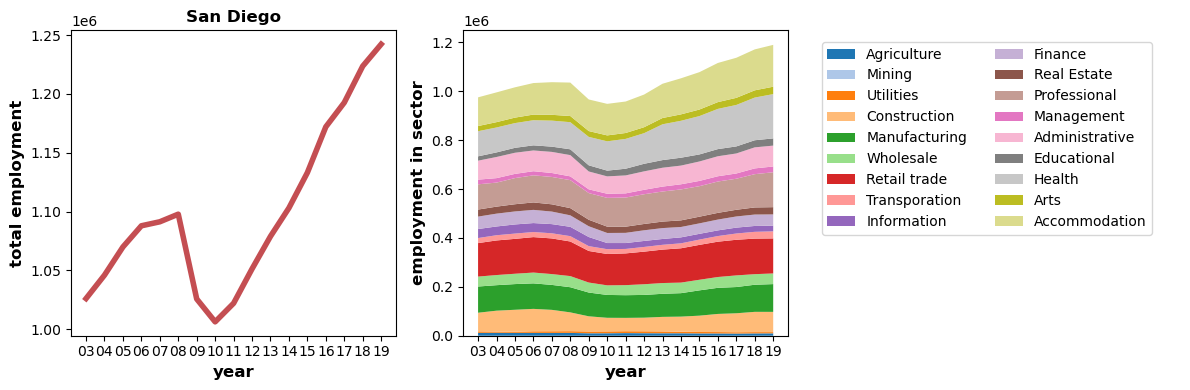

no imputed values, imputed_ctr= 0


/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:67: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


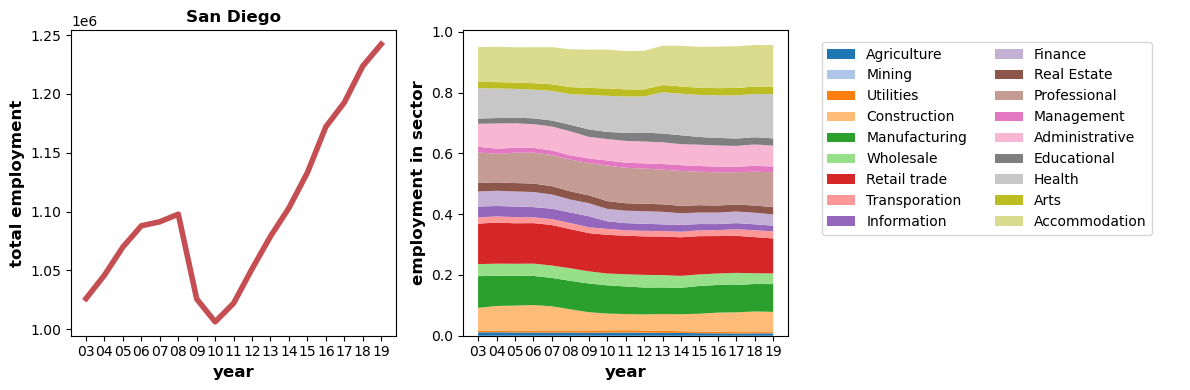

no imputed values, imputed_ctr= 0


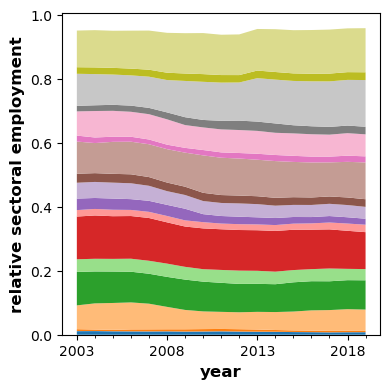

In [71]:
time_stamps_yearly=time_stamps_likeCBP_list[3::12]
dest_fold='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig1_cartoon_with_time_series/time_series_plots/'

stackPlot_1city_timeseries(df_metro_time,'San Diego',
                           naics_keys_to_plot, time_stamps_yearly)

stackPlot_1city_timeseries(df_metroF_time,'San Diego',
                           naics_keys_to_plot, time_stamps_yearly,
                          fig_name=dest_fold+'SanDiego_2panel_time_series.pdf')


stackPlot_1city_composition_only(df_metroF_time,'San Diego',
            naics_keys_to_plot, time_stamps_yearly,
            fig_name=dest_fold+'SanDiego_composition_time_series.pdf')

##### other cities 

In [34]:
stackPlot_1city_composition_only(df_metroF_time,'Duluth',
                           naics_keys_to_plot, time_stamps_yearly)

imputed_ctr=  103
{'naics_21', 'naics_48-49', 'naics_61', 'naics_11', 'naics_54', 'naics_55', 'naics_22', 'naics_62', 'naics_42', 'naics_56'}


/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:97: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


In [17]:
df_metroF_time['msa_name'].values

array(['Abilene, TX Metro Area', 'Akron, OH Metro Area',
       'Albany, GA Metro Area', 'Albany, OR Metro Area',
       'Albany-Schenectady-Troy, NY Metro Area',
       'Albuquerque, NM Metro Area', 'Alexandria, LA Metro Area',
       'Allentown-Bethlehem-Easton, PA-NJ Metro Area',
       'Altoona, PA Metro Area', 'Amarillo, TX Metro Area',
       'Ames, IA Metro Area', 'Anchorage, AK Metro Area',
       'Ann Arbor, MI Metro Area',
       'Anniston-Oxford-Jacksonville, AL Metro Area',
       'Appleton, WI Metro Area', 'Asheville, NC Metro Area',
       'Athens-Clarke County, GA Metro Area',
       'Atlanta-Sandy Springs-Roswell, GA Metro Area',
       'Atlantic City-Hammonton, NJ Metro Area',
       'Auburn-Opelika, AL Metro Area',
       'Augusta-Richmond County, GA-SC Metro Area',
       'Austin-Round Rock, TX Metro Area', 'Bakersfield, CA Metro Area',
       'Baltimore-Columbia-Towson, MD Metro Area',
       'Bangor, ME Metro Area', 'Barnstable Town, MA Metro Area',
       'Baton R

## for microbes

In [23]:
def stackPlot_microbe_timeseries(rel_abu_mat,time_points, genus_names_list=None,
                                 t_start=0,t_end=7,fig_name=None,with_legend=False ):

    mean_abu_sp=np.mean(rel_abu_mat[:,t_start:t_end],axis=1)
    print (len(mean_abu_sp))
    
    biggest_species=np.argsort(mean_abu_sp)[-10:]
    biggest_species=biggest_species[::-1] ## reverse order
#     biggest_species=np.argsort(mean_abu_sp)[-80:]
    
    if with_legend==False:
        fig = plt.figure(figsize=(4, 4))
        ax1 = fig.add_subplot()
    else:
        fig = plt.figure(figsize=(8, 4))
        ax1 = fig.add_subplot(1,2,1)
        
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.axis('off')
    

    color_list=sns.color_palette(palette='tab20',n_colors=100)
    stckplot = ax1.stackplot(
        time_points[t_start:t_end], rel_abu_mat[biggest_species,t_start:t_end], labels='',
         colors=color_list,linewidth=1.0)
    # color_list = plt.cm.get_cmap('nipy_spectral')(np.asarray(np.linspace(0, 256, len(df_1city_stacked)), dtype=int))
    # color_list = plt.cm.get_cmap('tab20')(np.arange(0,len(df_1city_stacked), dtype=int))
#     ax2.plot(df_1city_stacked['year'],
#              df_1city_stacked['total'], 'k--', linewidth=2)
    ax1.set_xlabel('day')
    ax1.set_ylabel('relative microbial abundance')
    ax1.set_yticks([0,0.2,0.4, 0.6, 0.8, 1.])
#     fig.legend(stckplot, label_naics, loc='upper right',
#                bbox_to_anchor=(.97, 0.9), ncol=2)
#     ax3 = fig.add_subplot(1, 3, 3)
#     ax3.axis('off')
    for ax in [ax1]:# [ax1, ax2, ax3]:  # make bigger font
        ax.yaxis.label.set_size(12)
        ax.yaxis.label.set_weight('bold')
        ax.xaxis.label.set_size(12)
        ax.xaxis.label.set_weight('bold')

    if with_legend:
        fig.legend(stckplot, np.asarray(genus_names_list)[biggest_species], loc='upper right',
           bbox_to_anchor=(.97, 0.9), ncol=1)
        
    fig.patch.set_facecolor('white')    
    plt.tight_layout()
    
    
    if fig_name is not None:
        plt.savefig(fig_name)
    
    plt.show()


In [24]:
dest_fold='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig1_cartoon_with_time_series/time_series_plots/'


time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]
genus_names_full=caporaso['gtax']
genus_names_list=genus_names_full[sp_idx]
genus_names_list2=[k[0][0] for k in genus_names_list] ## remove formatting issues
stackPlot_microbe_timeseries(rel_abu_mat,time_points,t_start=24,t_end=31,
                             fig_name=dest_fold+'microbe_timeseries.pdf' )


stackPlot_microbe_timeseries(rel_abu_mat,time_points,genus_names_list=genus_names_list2,
                             t_start=24,t_end=31, with_legend=True,
                             fig_name=dest_fold+'microbe_timeseries_legend.pdf' )



85


85


In [141]:
np.shape(rel_abu_mat)

(85, 336)

## for forests

In [27]:
def stackPlot_forest_timeseries(df_counts,time_points,clust_id=None,
                                fig_name=None,with_legend=False,
                               ylabel='tree species abundance'):
    
    sp_name_list=[]
        
    
    if clust_id is None: ## all species together
        BCI_abu_mat=df_counts[BCI_time_points].values
        for i in range(len(df_counts)):
            sp_name_list.append(df_counts['genus'].values[i]+' '+df_counts['species'].values[i])

    else:
        df_clusti=df_counts[df_counts['height_cluster']==clust_id]    
        BCI_abu_mat=df_clusti[BCI_time_points].values
        for i in range(len(df_clusti)):
            sp_name_list.append(df_clusti['genus'].values[i]+' '+df_clusti['species'].values[i])

    mean_abu_sp=np.mean(BCI_abu_mat,axis=1)
    print (len(BCI_abu_mat))
    biggest_species=np.argsort(mean_abu_sp)[-15:]
    biggest_species=biggest_species[::-1] ## reverse order
#     biggest_species=np.argsort(mean_abu_sp)[-80:]

    
    
    if with_legend==False:
        fig = plt.figure(figsize=(4, 4))
        ax1 = fig.add_subplot()
    else:
        fig = plt.figure(figsize=(8, 4))
        ax1 = fig.add_subplot(1,2,1)
        
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.axis('off')
    

    color_list=sns.color_palette(palette='tab20',n_colors=100)
    stckplot = ax1.stackplot(
        time_points, BCI_abu_mat[biggest_species], labels='',
         colors=color_list,linewidth=1.0)

    ax1.set_xlabel('year')
    ax1.set_xticklabels(['1990', '1995', '2000', '2005'])
    ax1.set_ylabel(ylabel)
    ax1.set_yticks([0,.5,1.])

#     ax1.set_yticks([0,20000, 40000])

    for ax in [ax1]:# [ax1, ax2, ax3]:  # make bigger font
        ax.yaxis.label.set_size(12)
        ax.yaxis.label.set_weight('bold')
        ax.xaxis.label.set_size(12)
        ax.xaxis.label.set_weight('bold')

    if with_legend:
        fig.legend(stckplot, np.asarray(sp_name_list)[biggest_species], loc='upper right',
           bbox_to_anchor=(.97, 0.9), ncol=1)
        
    fig.patch.set_facecolor('white')    
    plt.tight_layout()
    
    
    if fig_name is not None:
        plt.savefig(fig_name)
    
    plt.show()


In [191]:
dest_fold='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig1_cartoon_with_time_series/time_series_plots/'
BCI_time_points=['Y1990', 'Y1995', 'Y2000', 'Y2005']
stackPlot_forest_timeseries(df_counts,BCI_time_points,clust_id=4,
                            ylabel='abundance of canopy species',
                                fig_name=dest_fold+'BCI_time_series.pdf' )

BCI_time_points=['Y1990', 'Y1995', 'Y2000', 'Y2005']
stackPlot_forest_timeseries(df_counts,BCI_time_points,clust_id=4,
                            ylabel='abundance of canopy species', with_legend=True,
                                fig_name=dest_fold+'BCI_time_series_legend.pdf')

63


/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


63


/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


63


/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


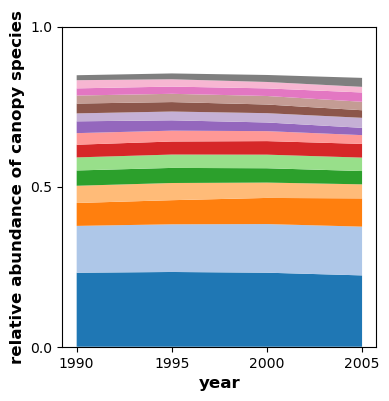

In [28]:
dest_fold='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig1_cartoon_with_time_series/time_series_plots/'
BCI_time_points=['Y1990', 'Y1995', 'Y2000', 'Y2005']
stackPlot_forest_timeseries(df_BCI_rel_clust,BCI_time_points,clust_id=4,
                            ylabel='relative abundance of canopy species',
                                fig_name=dest_fold+'BCI_relabu_time_series.pdf' )

# BCI_time_points=['Y1990', 'Y1995', 'Y2000', 'Y2005']
# stackPlot_forest_timeseries(df_counts,BCI_time_points,clust_id=4,
#                             ylabel='relative abundance of canopy species', with_legend=True,
#                                 fig_name=dest_fold+'BCI_relabu_time_series_legend.pdf')

60


/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator


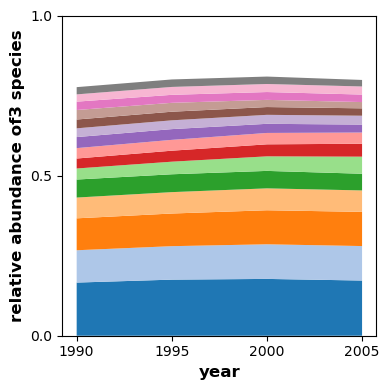

In [32]:
dest_fold='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig1_cartoon_with_time_series/time_series_plots/'
BCI_time_points=['Y1990', 'Y1995', 'Y2000', 'Y2005']
stackPlot_forest_timeseries(df_BCI_rel_clust,BCI_time_points,clust_id=3,
                            ylabel='relative abundance of3 species',
                                fig_name=dest_fold+'BCI_relabu_temp.pdf' )

##### shrub population is decreasing

In [170]:
BCI_time_points=['Y1990', 'Y1995', 'Y2000', 'Y2005']
stackPlot_forest_timeseries(df_counts,BCI_time_points,clust_id=1,
                            ylabel='abundance of shrub species',
                                fig_name=None )

87


/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator


# logG distribution fits

## 3 panel (aggregated datasets)

In [79]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
# weibull_inst = shared_func.symmetric_weibull_gen() 
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig1_growth_distribution/'
n_bins=31

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)


neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
        microbe_logG,10., 1., floc=0,fscale=1.)
histogram, bins = np.histogram(microbe_logG, bins=n_bins, density=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
ax1.hist(microbe_logG, bins=n_bins, density=True,color='m')
ax1.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut),
         'r-',lw=2,label='BDI model') 


neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
        BCI_logG,10., 1., floc=0,fscale=1.)
histogram, bins = np.histogram(BCI_logG, bins=n_bins, density=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
ax2.hist(BCI_logG, bins=n_bins, density=True,color='g')

ax2.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut),
         'r-',lw=2,label='BDI model') 


neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
        cities_logG,10., 1., floc=0,fscale=1.)
histogram, bins = np.histogram(cities_logG, bins=n_bins, density=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
ax3.hist(cities_logG, bins=n_bins, density=True,color='b')
ax3.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut),
         'r-',lw=2,label='BDI model') 


for ax in [ax1,ax2,ax3]:
    ax.set_xlabel(r'logarithmic growth rate')
    ax.set_yscale('log')
    ax.set_ylabel(r'probability')
#     ax.set_ylim(5e-3,3.5) /
#     ax1.legend(loc='best')

ax1.set_title('microbiome')
ax2.set_title('tropical forest')
ax3.set_title('urban employment')

# plt.tick_params(axis='both', which='both') 
fig.patch.set_facecolor('white')  
fig.tight_layout()

plt.savefig(dest_path+'fig1_3panel.png')

/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1837: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(self._pdf, _a, x, args=args)[0]
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1837: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(self._pdf, _a, x, args=args)[0]
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1837: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(self._pdf, _a, x, args=args)[0]


## 6 panel 3 species, BCI, 2 sectors

len emp is  27660
len emp is  34578


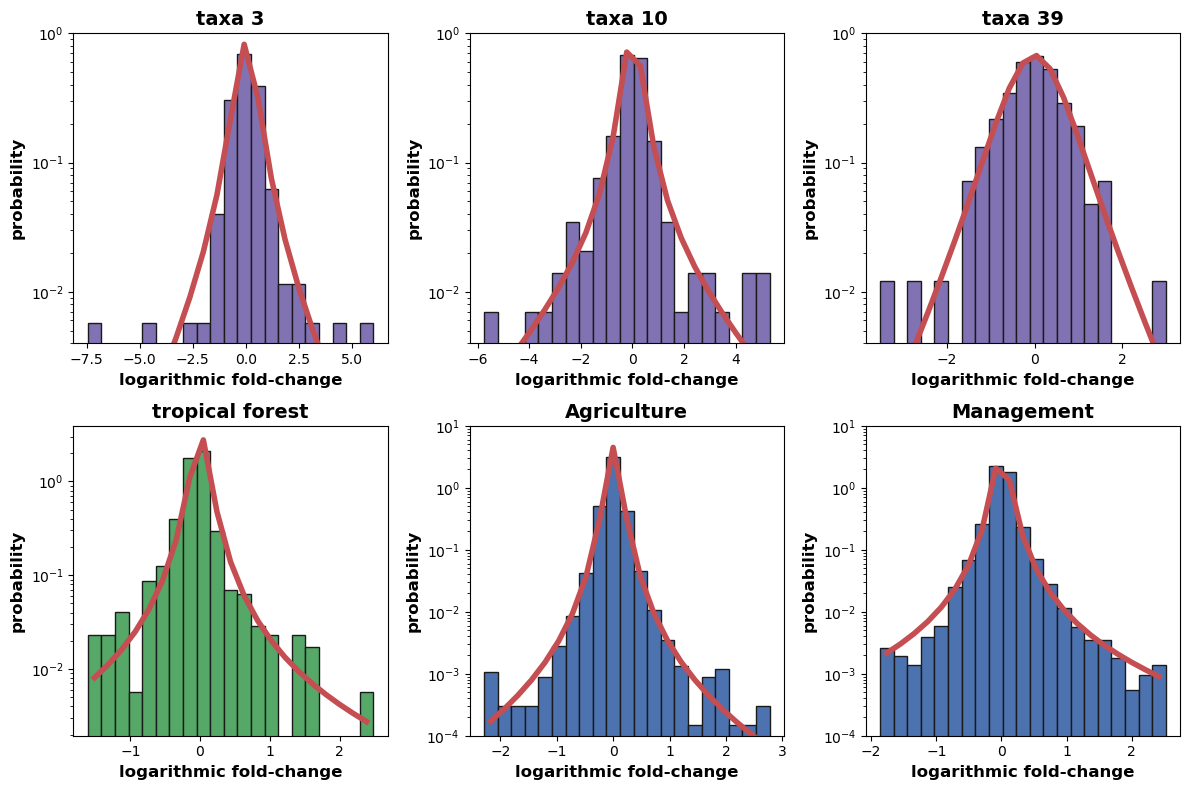

In [3]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
# weibull_inst = shared_func.symmetric_weibull_gen() 
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig1_growth_distribution/'
n_bins=21

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)

ax_list=[ax1,ax2,ax3,ax4,ax5,ax6]

sp_list=[3,10,39]#,39]
tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]
idx_1_list=[]
idx_2_list=[]
for j,t2 in enumerate(time_points):
    if np.any(time_points==t2-tau):
        i=int(np.where(time_points==t2-tau)[0])
        t1=time_points[i]
#         print (i,j, t1, t2)
        idx_1_list.append(i)
        idx_2_list.append(j)
idxs_1=np.array(idx_1_list)
idxs_2=np.array(idx_2_list)

for i,sp in enumerate(sp_list):
    otu_t2=np.ravel(rel_abu_mat[sp,idxs_2])
    otu_t1=np.ravel(rel_abu_mat[sp,idxs_1])
    idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
    growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
    logG=np.log(growth_rates)
    
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            logG,10., 1., floc=0,fscale=1.)
    
    histogram, bins = np.histogram(logG, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax=ax_list[i]
    ax.hist(logG, bins=n_bins, density=True,facecolor='m', edgecolor='k')
    yvals=neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut)
    ax.plot(bin_centers, yvals,'r-',lw=4,label='BDI model') 

    ax.set_ylim(4e-3,1) 
    ax.set_title('taxa '+str(int(sp)))
    
    
neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
        BCI_logG,10., 1., floc=0,fscale=1.)
histogram, bins = np.histogram(BCI_logG, bins=n_bins, density=True)
bin_centers = 0.5*(bins[1:] + bins[:-1])
ax4.hist(BCI_logG, bins=n_bins, density=True,facecolor='g',edgecolor='k')
ax4.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut),
         'r-',lw=4,label='BDI model') 

naics_plot_list=['naics_11','naics_55' ]
for i,naics in enumerate(naics_plot_list):
    ax=ax_list[i+4]
    logratio_list=shared_func.get_LogRatio(df_metroF_time, [naics],
                                       time_stamps_likeCBP_list,tau=12)
    emp_logG=np.ravel(logratio_list)
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            emp_logG,10., 1., floc=0,fscale=1.)
    histogram, bins = np.histogram(emp_logG, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(emp_logG, bins=n_bins, density=True,facecolor='b',edgecolor='k')
    ax.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut),
             'r-',lw=4,label='BDI model') 
    ax.set_ylim(1e-4,10) 
    print ('len emp is ',len(emp_logG) )
    sector_name=shared_func.sector_from_naics(df_naics_ref, naics, shorten=True)
    ax.set_title(sector_name)
for ax in ax_list:
    ax.set_xlabel(r'logarithmic fold-change')
    ax.set_yscale('log')
    ax.set_ylabel(r'probability')
#     ax.set_ylim(5e-3,3.5) /
#     ax1.legend(loc='best')

# ax1.set_title('microbiome')
# 
# ax3.set_title('urban employment')
ax4.set_title('tropical forest')
# plt.tick_params(axis='both', which='both') 
fig.patch.set_facecolor('white')  
fig.tight_layout()

plt.savefig(dest_path+'fig1_6panel.png')
plt.show()

## 9 panel with gof included.

/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in true_divide


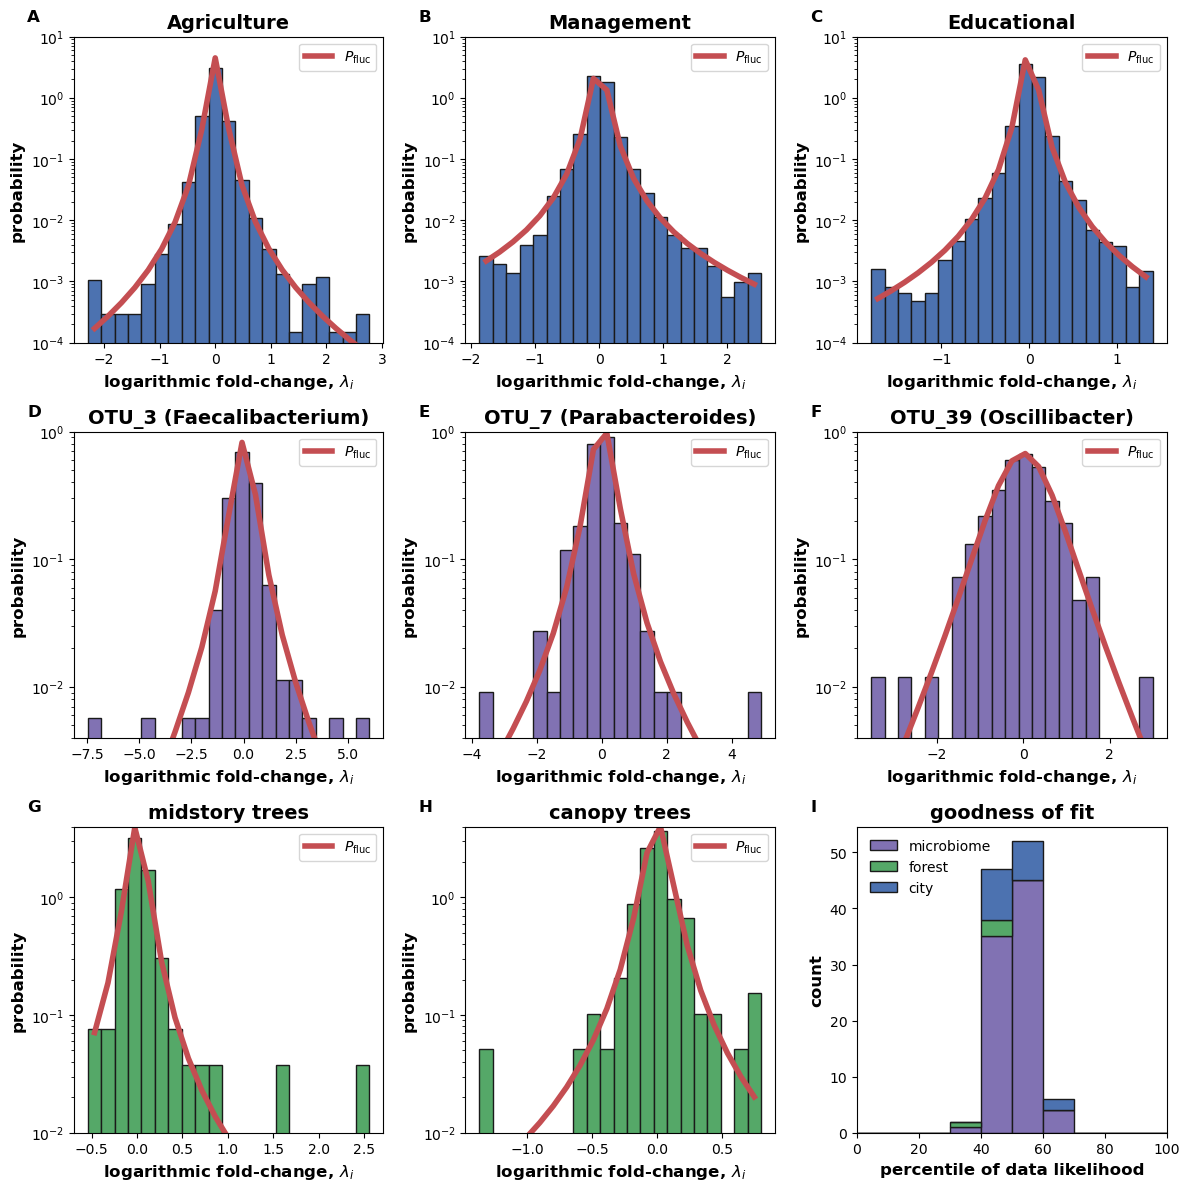

In [115]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
# weibull_inst = shared_func.symmetric_weibull_gen() 
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig1_growth_distribution/'
n_bins=21
is_rel_abundances=True ## if false, done for absolute count data in BCI instead.
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)
ax7 = fig.add_subplot(3,3,7)
ax8 = fig.add_subplot(3,3,8)
ax9 = fig.add_subplot(3,3,9)

ax_list=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

sp_list=[3,7,39]#,39]
tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]
genus_names_list=genus_names_full[sp_idx]
idx_1_list=[]
idx_2_list=[]
for j,t2 in enumerate(time_points):
    if np.any(time_points==t2-tau):
        i=int(np.where(time_points==t2-tau)[0])
        t1=time_points[i]
#         print (i,j, t1, t2)
        idx_1_list.append(i)
        idx_2_list.append(j)
idxs_1=np.array(idx_1_list)
idxs_2=np.array(idx_2_list)

for i,sp in enumerate(sp_list):
    ax=ax_list[i+3]
    otu_t2=np.ravel(rel_abu_mat[sp,idxs_2])
    otu_t1=np.ravel(rel_abu_mat[sp,idxs_1])
    idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
    growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
    logG=np.log(growth_rates)
    
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            logG,10., 1., floc=0,fscale=1.)

    histogram, bins = np.histogram(logG, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    
    ax.hist(logG, bins=n_bins, density=True,facecolor='m', edgecolor='k')
    yvals=neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut)
    ax.plot(bin_centers, yvals,'r-',lw=4,label=r'$P_{\mathrm{fluc}}$') 

    ax.set_ylim(4e-3,1) 
#     ax.set_title('taxa '+str(int(sp)))
    genus_name=genus_names_list[sp][0][0]
    ax.set_title('OTU_'+str(int(sp))  +' ('+genus_name+')')
    
    
    ax.text(-0.15,1.05,subplot_label_list[i+3],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)
    
cluster_id_list=[3,4] 
# tree_titles=['understory treelets', 'midstory trees']
for i, clust_id in enumerate(cluster_id_list):
    ax=ax_list[i+6]
    if is_rel_abundances:
        BCI_logG_clusti=get_BCI_clust_logG(df_BCI_rel_clust,clust_id)   
    else:
        BCI_logG_clusti=get_BCI_clust_logG(df_counts,clust_id) 
    
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            BCI_logG_clusti,10., 1., floc=0,fscale=1.)
    
    histogram, bins = np.histogram(BCI_logG_clusti, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(BCI_logG_clusti, bins=n_bins, density=True,facecolor='g',edgecolor='k')
    ax.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut),
             'r-',lw=4,label=r'$P_{\mathrm{fluc}}$') 
    ax.set_title(tree_clust_names[clust_id-1])
    ax.text(-0.15,1.05,subplot_label_list[i+6],fontweight="bold",
        transform=ax.transAxes,fontsize=MEDIUM_SIZE)
    ax.set_ylim(1e-2,4) 
    
    
naics_plot_list=['naics_11','naics_55','naics_61' ]
for i,naics in enumerate(naics_plot_list):
    ax=ax_list[i]
    logratio_list=shared_func.get_LogRatio(df_metroF_time, [naics],
                                       time_stamps_likeCBP_list,tau=12)
    emp_logG=np.ravel(logratio_list)
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            emp_logG,10., 1., floc=0,fscale=1.)
    histogram, bins = np.histogram(emp_logG, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(emp_logG, bins=n_bins, density=True,facecolor='b',edgecolor='k')
    ax.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut),
             'r-',lw=4,label=r'$P_{\mathrm{fluc}}$') 
    ax.set_ylim(1e-4,10) 
    
    sector_name=shared_func.sector_from_naics(df_naics_ref, naics, shorten=True)
    ax.set_title(sector_name)
    ax.text(-0.15,1.05,subplot_label_list[i],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)
for ax in ax_list:
    ax.set_xlabel(r'logarithmic fold-change, $\lambda_i$')
    ax.set_yscale('log')
    ax.set_ylabel(r'probability')
#     ax.set_ylim(5e-3,3.5) /
    ax.legend(loc='best')

# ax1.set_title('microbiome')
# 
# ax3.set_title('urban employment')
# ax4.set_title('tropical forest')
# plt.tick_params(axis='both', which='both') 


##########################goodness of fit panel######################
pct_microbe_data=[]
pct_city_data=[]
pct_BCI_data=[]
with open(combined_params_path+'microbe_logG_fit_and_simvals.pkl', 'rb') as handle:
    microbe_ll_df=pd.DataFrame(pickle.load(handle)  )
    
if is_rel_abundances:
    with open(combined_params_path+'BCI_rel_logG_clustfit_and_simvals.pkl', 'rb') as handle:
        BCI_ll_dict=pickle.load(handle)  
        del BCI_ll_dict['sp'] ## empty column prevents converting to dataframe
        BCI_ll_df=pd.DataFrame(BCI_ll_dict)
else:
    with open(combined_params_path+'BCI_logG_clustfit_and_simvals.pkl', 'rb') as handle:
        BCI_ll_dict=pickle.load(handle)  
        del BCI_ll_dict['sp'] ## empty column prevents converting to dataframe
        BCI_ll_df=pd.DataFrame(BCI_ll_dict)
with open(combined_params_path+'city_logG_fit_and_simvals.pkl', 'rb') as handle:
    city_ll_df=pd.DataFrame(pickle.load(handle)  )

for i in range(len(microbe_ll_df)):
    logLik_data= microbe_ll_df.loc[i]['logLk']
    logLik_sim= np.array(microbe_ll_df.loc[i]['logLk_sims'])
    
    if np.any(logLik_sim>logLik_data):
        percentile_score=np.sum(logLik_sim>logLik_data)*100./len(logLik_sim)
    else:
        percentile_score=0
    pct_microbe_data.append(percentile_score)
for i in range(len(BCI_ll_df)):    
    logLik_data= BCI_ll_df.loc[i]['logLk']
    logLik_sim=  np.array(BCI_ll_df.loc[i]['logLk_sims'])
    if np.any(logLik_sim>logLik_data):
        percentile_score=np.sum(logLik_sim>logLik_data)*100./len(logLik_sim)
    else:
        percentile_score=0
    pct_BCI_data.append(percentile_score)
for i in range(len(city_ll_df)):
    logLik_data= city_ll_df.loc[i]['logLk']
    logLik_sim= np.array(city_ll_df.loc[i]['logLk_sims'])
    if np.any(logLik_sim>logLik_data):
        percentile_score=np.sum(logLik_sim>logLik_data)*100./len(logLik_sim)
    else:
        percentile_score=0
    pct_city_data.append(percentile_score)
n_bins=5
x_multi=[]
x_multi.append(pct_microbe_data)
x_multi.append(pct_BCI_data)
x_multi.append(pct_city_data)
# ax9.hist(x_multi, bins=np.linspace(0,100,11) , histtype='bar', color=['m','g','b'],
#          label=['microbe','forest','employment'], rwidth=.8)
ax9.hist(x_multi, bins=np.linspace(0,100,11) , histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbiome','forest','city'])
ax9.set_title('goodness of fit')
ax9.set_xlabel('percentile of data likelihood')
ax9.set_ylabel('count')
ax9.legend(loc=2, frameon=False)
ax9.set_xlim(0,100)

ax9.text(-0.15,1.05,'I',fontweight="bold",
            transform=ax9.transAxes,fontsize=MEDIUM_SIZE)


###################################







fig.patch.set_facecolor('white')  
fig.tight_layout()
if is_rel_abundances:
    plt.savefig(dest_path+'fig1_9panel_with_gof_rel.png')
    plt.savefig(dest_path+'fig1_9panel_with_gof_rel.pdf')
else:
    plt.savefig(dest_path+'fig1_9panel_with_gof_abs.png')
    plt.savefig(dest_path+'fig1_9panel_with_gof_abs.pdf')
plt.show()

## 9 panel compare fits + AIC

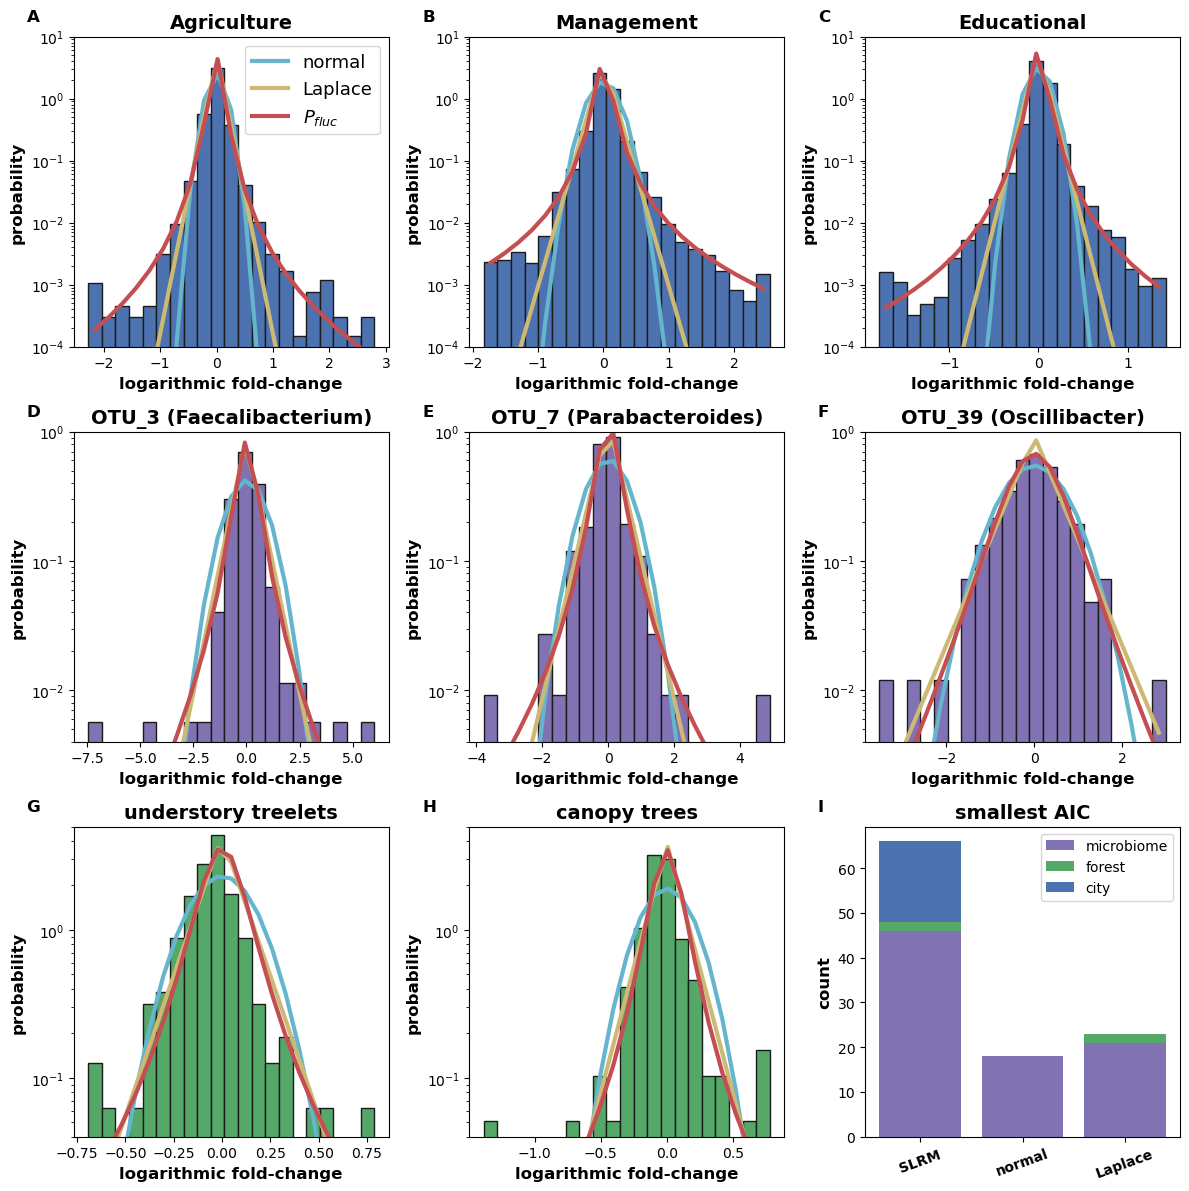

In [116]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
# weibull_inst = shared_func.symmetric_weibull_gen() 
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig1_growth_distribution/'

is_rel_abundances=False #True ## if false, done for absolute count data in BCI instead.

n_bins=21

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)
ax7 = fig.add_subplot(3,3,7)
ax8 = fig.add_subplot(3,3,8)
ax9 = fig.add_subplot(3,3,9)

ax_list=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

sp_list=[3,7,39]#,39]
genus_names_full=caporaso['gtax']
tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)

rel_abu_mat=rel_abu_t_mat_full[sp_idx]
genus_names_list=genus_names_full[sp_idx]
idx_1_list=[]
idx_2_list=[]
for j,t2 in enumerate(time_points):
    if np.any(time_points==t2-tau):
        i=int(np.where(time_points==t2-tau)[0])
        t1=time_points[i]
#         print (i,j, t1, t2)
        idx_1_list.append(i)
        idx_2_list.append(j)
idxs_1=np.array(idx_1_list)
idxs_2=np.array(idx_2_list)

for i,sp in enumerate(sp_list):
    ax=ax_list[i+3]
    otu_t2=np.ravel(rel_abu_mat[sp,idxs_2])
    otu_t1=np.ravel(rel_abu_mat[sp,idxs_1])
    idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
    growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
    logG=np.log(growth_rates)
    
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            logG,10., 1., floc=0,fscale=1.)
    mu, sigma=scipy.stats.norm.fit(logG,floc=0)
    _, scale_laplace=scipy.stats.laplace.fit(logG,floc=0)
    histogram, bins = np.histogram(logG, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(logG, bins=n_bins, density=True,facecolor='m', edgecolor='k')
    ax.plot(bin_centers, scipy.stats.norm.pdf(bin_centers,loc=0,scale=sigma),
            'c-',lw=3,label='normal') 
    ax.plot(bin_centers, scipy.stats.laplace.pdf(bin_centers,loc=0,scale=scale_laplace),
            'y-',lw=3,label='Laplace')     

    yvals=neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut)
    ax.plot(bin_centers, yvals,'r-',lw=3,label=r'$P_{fluc}$') 
    
    ax.set_ylim(4e-3,1) 
    genus_name=genus_names_list[sp][0][0]
    ax.set_title('OTU_'+str(int(sp))  +' ('+genus_name+')')
    ax.text(-0.15,1.05,subplot_label_list[i+3],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)
#     ax.set_title('taxa '+str(int(sp)))

cluster_id_list=[2,4] 
# tree_titles=['understory treelets', 'midstory trees']
for i, clust_id in enumerate(cluster_id_list):
    ax=ax_list[i+6]
    
    if is_rel_abundances:
        BCI_logG_clusti=get_BCI_clust_logG(df_BCI_rel_clust,clust_id)  
    else:
        BCI_logG_clusti=get_BCI_clust_logG(df_counts,clust_id)   
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            BCI_logG_clusti,10., 1., floc=0,fscale=1.)
    
    mu, sigma=scipy.stats.norm.fit(BCI_logG_clusti,floc=0)
    _, scale_laplace=scipy.stats.laplace.fit(BCI_logG_clusti,floc=0)
    histogram, bins = np.histogram(BCI_logG_clusti, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(BCI_logG_clusti, bins=n_bins, density=True,facecolor='g',edgecolor='k')
    ax.plot(bin_centers, scipy.stats.norm.pdf(bin_centers,loc=0,scale=sigma),
            'c-',lw=3,label='normal') 
    ax.plot(bin_centers, scipy.stats.laplace.pdf(bin_centers,loc=0,scale=scale_laplace),
            'y-',lw=3,label='Laplace')     
    ax.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut),
             'r-',lw=3,label=r'$P_{fluc}$') 

    ax.set_title(tree_clust_names[clust_id-1])
    ax.text(-0.15,1.05,subplot_label_list[i+6],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)
    ax.set_ylim(4e-2,5) 
    
    
naics_plot_list=['naics_11','naics_55','naics_61' ]
for i,naics in enumerate(naics_plot_list):
    ax=ax_list[i]
    if is_rel_abundances:
        logratio_list=shared_func.get_LogRatio(df_metroF_time, [naics],
                                           time_stamps_likeCBP_list,tau=12)
    else:
        logratio_list=shared_func.get_LogRatio(df_metro_time, [naics],
                                           time_stamps_likeCBP_list,tau=12)
    emp_logG=np.ravel(logratio_list)
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            emp_logG,10., 1., floc=0,fscale=1.)
    mu, sigma=scipy.stats.norm.fit(emp_logG,floc=0)
    _, scale_laplace=scipy.stats.laplace.fit(emp_logG,floc=0)
    histogram, bins = np.histogram(emp_logG, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(emp_logG, bins=n_bins, density=True,facecolor='b',edgecolor='k')
    ax.plot(bin_centers, scipy.stats.norm.pdf(bin_centers,loc=0,scale=sigma),
            'c-',lw=3,label='normal') 
    ax.plot(bin_centers, scipy.stats.laplace.pdf(bin_centers,loc=0,scale=scale_laplace),
            'y-',lw=3,label='Laplace') 
    ax.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut),
             'r-',lw=3,label=r'$P_{fluc}$') 
    ax.set_ylim(1e-4,10) 
    
    sector_name=shared_func.sector_from_naics(df_naics_ref, naics, shorten=True)
    ax.set_title(sector_name)
    ax.text(-0.15,1.05,subplot_label_list[i],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)
    
for ax in ax_list:
    ax.set_xlabel(r'logarithmic fold-change')
    ax.set_yscale('log')
    ax.set_ylabel(r'probability')



##########################comparing AIC of fit panel######################
with open(combined_params_path+'microbe_logG_compare_dists.pkl', 'rb') as handle:
    microbe_logG_compare_dists=pickle.load( handle)  
if is_rel_abundances:   
    with open(combined_params_path+'city_logG_compare_dists.pkl', 'rb') as handle:
        city_logG_compare_dists=pickle.load( handle) 
else:
    with open(combined_params_path+'city_absabu_logG_compare_dists.pkl', 'rb') as handle:
        city_logG_compare_dists=pickle.load( handle) 
if is_rel_abundances:   
    with open(combined_params_path+'BCI_rel_logG_compare_dists.pkl', 'rb') as handle:
        BCI_logG_compare_dists=pickle.load( handle) 
else:
    with open(combined_params_path+'BCI_logG_compare_dists.pkl', 'rb') as handle:
        BCI_logG_compare_dists=pickle.load( handle) 

    
### comparing 5 dists    
# xvals=np.arange(5)
# ax9.bar(xvals,microbe_logG_compare_dists['ctr_list'], color='m', label='microbiome')
# ax9.bar(xvals,BCI_logG_compare_dists['ctr_list'],
#         bottom=microbe_logG_compare_dists['ctr_list'], color='g', label='forest')
# ax9.bar(xvals,city_logG_compare_dists['ctr_list'], 
#         bottom=np.array(microbe_logG_compare_dists['ctr_list'])+
#         np.array(BCI_logG_compare_dists['ctr_list']),color='b', label='city')
# ax9.set_xticks(xvals)
# new_labels = [word.replace('BDI','SLRM') for word in city_logG_compare_dists['ctr_names']]

### comparing 3 dists
xvals=np.arange(3)
ax9.bar(xvals,microbe_logG_compare_dists['ctr_list_onlymean0'], color='m', label='microbiome')
ax9.bar(xvals,BCI_logG_compare_dists['ctr_list_onlymean0'],
        bottom=microbe_logG_compare_dists['ctr_list_onlymean0'], color='g', label='forest')
ax9.bar(xvals,city_logG_compare_dists['ctr_list_onlymean0'], 
        bottom=np.array(microbe_logG_compare_dists['ctr_list_onlymean0'])+
        np.array(BCI_logG_compare_dists['ctr_list_onlymean0']),color='b', label='city')


ax9.set_xticks(xvals)
new_labels = [word.replace('BDI','SLRM') for word in city_logG_compare_dists['ctr_names_onlymean0']]

new_labels = [word.replace(', mean0','') for word in new_labels]

ax9.set_xticklabels(new_labels,
                    rotation = 20,fontweight='bold')
ax9.set_ylabel('count')
ax9.legend(loc='best')
ax9.set_title('smallest AIC')
ax9.text(-0.15,1.05,'I',fontweight="bold",
            transform=ax9.transAxes,fontsize=MEDIUM_SIZE)

###################################


ax1.legend(loc='best',fontsize=13)




fig.patch.set_facecolor('white')  
fig.tight_layout()
if is_rel_abundances:   
    plt.savefig(dest_path+'fig1_9panel_compare_AIC_rel.png')
    plt.savefig(dest_path+'fig1_9panel_compare_AIC_rel.pdf')
else:
    plt.savefig(dest_path+'fig1_9panel_compare_AIC_absabu.png')
    plt.savefig(dest_path+'fig1_9panel_compare_AIC_absabu.pdf')
plt.show()

## absolute abundance figure

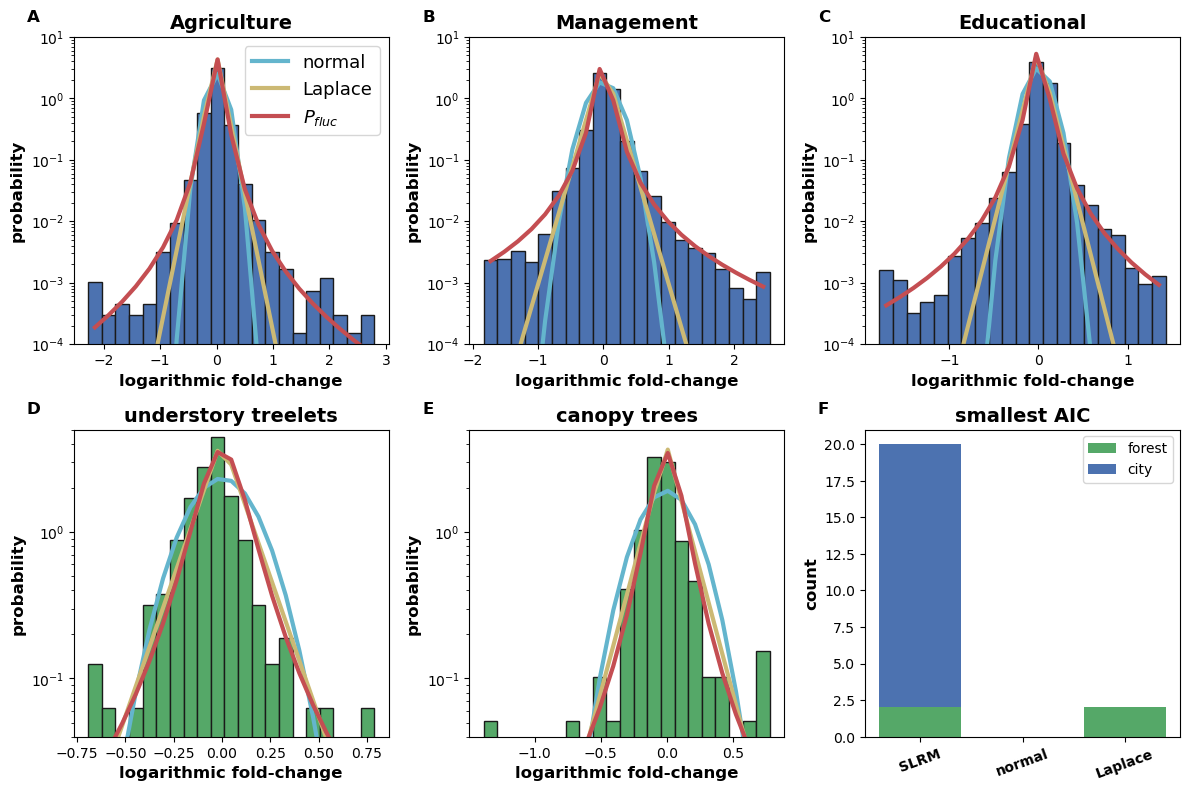

In [119]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
# weibull_inst = shared_func.symmetric_weibull_gen() 
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig1_growth_distribution/'

is_rel_abundances=False #True ## if false, done for absolute count data in BCI instead.
assert is_rel_abundances==False,"this is the use case for this figure"
n_bins=21

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)


ax_list=[ax1,ax2,ax3,ax4,ax5]

# sp_list=[3,7,39]#,39]
# genus_names_full=caporaso['gtax']
# tau=1
# time_points=np.squeeze(caporaso['m3_days'])
# rel_abu_t_mat_full=caporaso['m3_rel_abu']  
# sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)

# rel_abu_mat=rel_abu_t_mat_full[sp_idx]
# genus_names_list=genus_names_full[sp_idx]
# idx_1_list=[]
# idx_2_list=[]
# for j,t2 in enumerate(time_points):
#     if np.any(time_points==t2-tau):
#         i=int(np.where(time_points==t2-tau)[0])
#         t1=time_points[i]
# #         print (i,j, t1, t2)
#         idx_1_list.append(i)
#         idx_2_list.append(j)
# idxs_1=np.array(idx_1_list)
# idxs_2=np.array(idx_2_list)

# for i,sp in enumerate(sp_list):
#     ax=ax_list[i+3]
#     otu_t2=np.ravel(rel_abu_mat[sp,idxs_2])
#     otu_t1=np.ravel(rel_abu_mat[sp,idxs_1])
#     idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
#     growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
#     logG=np.log(growth_rates)
    
#     neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
#             logG,10., 1., floc=0,fscale=1.)
#     mu, sigma=scipy.stats.norm.fit(logG,floc=0)
#     _, scale_laplace=scipy.stats.laplace.fit(logG,floc=0)
#     histogram, bins = np.histogram(logG, bins=n_bins, density=True)
#     bin_centers = 0.5*(bins[1:] + bins[:-1])
#     ax.hist(logG, bins=n_bins, density=True,facecolor='m', edgecolor='k')
#     ax.plot(bin_centers, scipy.stats.norm.pdf(bin_centers,loc=0,scale=sigma),
#             'c-',lw=3,label='normal') 
#     ax.plot(bin_centers, scipy.stats.laplace.pdf(bin_centers,loc=0,scale=scale_laplace),
#             'y-',lw=3,label='Laplace')     

#     yvals=neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut)
#     ax.plot(bin_centers, yvals,'r-',lw=3,label=r'$P_{fluc}$') 
    
#     ax.set_ylim(4e-3,1) 
#     genus_name=genus_names_list[sp][0][0]
#     ax.set_title('OTU_'+str(int(sp))  +' ('+genus_name+')')
#     ax.text(-0.15,1.05,subplot_label_list[i+3],fontweight="bold",
#             transform=ax.transAxes,fontsize=MEDIUM_SIZE)
# #     ax.set_title('taxa '+str(int(sp)))

cluster_id_list=[2,4] 
# tree_titles=['understory treelets', 'midstory trees']
for i, clust_id in enumerate(cluster_id_list):
    ax=ax_list[i+3]
    
    if is_rel_abundances:
        BCI_logG_clusti=get_BCI_clust_logG(df_BCI_rel_clust,clust_id)  
    else:
        BCI_logG_clusti=get_BCI_clust_logG(df_counts,clust_id)   
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            BCI_logG_clusti,10., 1., floc=0,fscale=1.)
    
    mu, sigma=scipy.stats.norm.fit(BCI_logG_clusti,floc=0)
    _, scale_laplace=scipy.stats.laplace.fit(BCI_logG_clusti,floc=0)
    histogram, bins = np.histogram(BCI_logG_clusti, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(BCI_logG_clusti, bins=n_bins, density=True,facecolor='g',edgecolor='k')
    ax.plot(bin_centers, scipy.stats.norm.pdf(bin_centers,loc=0,scale=sigma),
            'c-',lw=3,label='normal') 
    ax.plot(bin_centers, scipy.stats.laplace.pdf(bin_centers,loc=0,scale=scale_laplace),
            'y-',lw=3,label='Laplace')     
    ax.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut),
             'r-',lw=3,label=r'$P_{fluc}$') 

    ax.set_title(tree_clust_names[clust_id-1])
    ax.text(-0.15,1.05,subplot_label_list[i+3],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)
    ax.set_ylim(4e-2,5) 
    
    
naics_plot_list=['naics_11','naics_55','naics_61' ]
for i,naics in enumerate(naics_plot_list):
    ax=ax_list[i]
    if is_rel_abundances:
        logratio_list=shared_func.get_LogRatio(df_metroF_time, [naics],
                                           time_stamps_likeCBP_list,tau=12)
    else:
        logratio_list=shared_func.get_LogRatio(df_metro_time, [naics],
                                           time_stamps_likeCBP_list,tau=12)
    emp_logG=np.ravel(logratio_list)
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            emp_logG,10., 1., floc=0,fscale=1.)
    mu, sigma=scipy.stats.norm.fit(emp_logG,floc=0)
    _, scale_laplace=scipy.stats.laplace.fit(emp_logG,floc=0)
    histogram, bins = np.histogram(emp_logG, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(emp_logG, bins=n_bins, density=True,facecolor='b',edgecolor='k')
    ax.plot(bin_centers, scipy.stats.norm.pdf(bin_centers,loc=0,scale=sigma),
            'c-',lw=3,label='normal') 
    ax.plot(bin_centers, scipy.stats.laplace.pdf(bin_centers,loc=0,scale=scale_laplace),
            'y-',lw=3,label='Laplace') 
    ax.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut),
             'r-',lw=3,label=r'$P_{fluc}$') 
    ax.set_ylim(1e-4,10) 
    
    sector_name=shared_func.sector_from_naics(df_naics_ref, naics, shorten=True)
    ax.set_title(sector_name)
    ax.text(-0.15,1.05,subplot_label_list[i],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)
    
for ax in ax_list:
    ax.set_xlabel(r'logarithmic fold-change')
    ax.set_yscale('log')
    ax.set_ylabel(r'probability')



##########################comparing AIC of fit panel######################
# with open(combined_params_path+'microbe_logG_compare_dists.pkl', 'rb') as handle:
#     microbe_logG_compare_dists=pickle.load( handle)  
if is_rel_abundances:   
    with open(combined_params_path+'city_logG_compare_dists.pkl', 'rb') as handle:
        city_logG_compare_dists=pickle.load( handle) 
else:
    with open(combined_params_path+'city_absabu_logG_compare_dists.pkl', 'rb') as handle:
        city_logG_compare_dists=pickle.load( handle) 
if is_rel_abundances:   
    with open(combined_params_path+'BCI_rel_logG_compare_dists.pkl', 'rb') as handle:
        BCI_logG_compare_dists=pickle.load( handle) 
else:
    with open(combined_params_path+'BCI_logG_compare_dists.pkl', 'rb') as handle:
        BCI_logG_compare_dists=pickle.load( handle) 



### comparing 3 dists
xvals=np.arange(3)
# ax6.bar(xvals,microbe_logG_compare_dists['ctr_list_onlymean0'], color='m', label='microbiome')
ax6.bar(xvals,BCI_logG_compare_dists['ctr_list_onlymean0'],
        bottom=0, color='g', label='forest')
ax6.bar(xvals,city_logG_compare_dists['ctr_list_onlymean0'], 
        bottom=np.array(BCI_logG_compare_dists['ctr_list_onlymean0']),color='b', label='city')


ax6.set_xticks(xvals)
new_labels = [word.replace('BDI','SLRM') for word in city_logG_compare_dists['ctr_names_onlymean0']]

new_labels = [word.replace(', mean0','') for word in new_labels]

ax6.set_xticklabels(new_labels,
                    rotation = 20,fontweight='bold')
ax6.set_ylabel('count')
ax6.legend(loc='best')
ax6.set_title('smallest AIC')
ax6.text(-0.15,1.05,'F',fontweight="bold",
            transform=ax6.transAxes,fontsize=MEDIUM_SIZE)

###################################


ax1.legend(loc='best',fontsize=13)




fig.patch.set_facecolor('white')  
fig.tight_layout()
if is_rel_abundances:   
    plt.savefig(dest_path+'fig1_6panel_compare_AIC_rel.png')
    plt.savefig(dest_path+'fig1_6panel_compare_AIC_rel.pdf')
else:
    plt.savefig(dest_path+'fig1_6panel_compare_AIC_absabu.png')
    plt.savefig(dest_path+'fig1_6panel_compare_AIC_absabu.pdf')
plt.show()

In [ ]:
new_labels = [word.replace('BDI','SLRM') for word in city_logG_compare_dists['ctr_names']]

In [58]:
city_logG_compare_dists.keys()

dict_keys(['naics', 'tp_fit', 'bd_fit', 'data_length', 'logLk', 'll_normal_list', 'll_Laplace_list', 'll_normal_list_non0mean', 'll_Laplace_list_non0mean', 'ctr_list', 'ctr_names', 'ctr_list_onlymean0', 'ctr_names_onlymean0'])

In [55]:
city_logG_compare_dists['ctr_names']

['BDI', 'normal, mean0', 'Laplace, mean0', 'normal', 'Laplace']

## Microbes where Normal, Laplace does better.

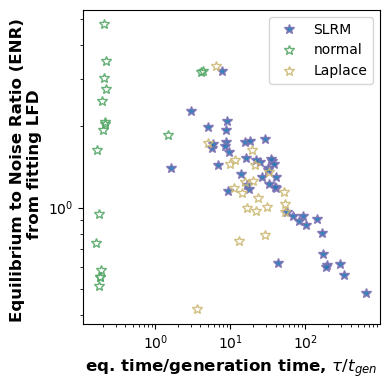

In [32]:
with open(combined_params_path+'microbe_logG_compare_dists.pkl', 'rb') as handle:
    microbe_logG_compare_dists=pickle.load(handle)  
with open(combined_params_path+'microbe_AFD_atlogG_params_pctiles.pkl', 'rb') as handle:
    microbe_AFD_atlogG_params=pickle.load(handle)     
with open(combined_params_path+'microbe_logG_atAFD_fit_and_simvals_pctiles.pkl', 'rb') as handle:
    microbe_logG_atAFD_params=pickle.load( handle)     


with open(combined_params_path+'microbe_logG_fit_and_simvals.pkl', 'rb') as handle:
    microbe_logGtrue_df=pd.DataFrame(pickle.load(handle)  )
microbe_tau_true_vals= 1./microbe_logGtrue_df['tp_fit'].values
microbe_logG_shape=np.array(microbe_AFD_atlogG_params['m/D'])
microbe_AFD_shape=np.array(microbe_logG_atAFD_params['bd_fit'])    
microbe_div_time=.175 ## 5.7 divisions per day    
microbe_rescaled_tau_divs=microbe_tau_true_vals/microbe_div_time ##5 divs per day  


idx_BDI=np.zeros(len(microbe_logG_shape)).astype(bool)
idx_normal=np.zeros(len(microbe_logG_shape)).astype(bool)
idx_laplace=np.zeros(len(microbe_logG_shape)).astype(bool)
for idx,val in enumerate(microbe_logG_compare_dists['best_dist_list']):
    if val =='BDI':
        idx_BDI[idx]=True  
for idx,val in enumerate(microbe_logG_compare_dists['best_dist_list']):
    if val =='normal, mean0':
        idx_normal[idx]=True  
for idx,val in enumerate(microbe_logG_compare_dists['best_dist_list']):
    if val =='Laplace, mean0':
        idx_laplace[idx]=True  




fig = plt.figure(figsize=(4, 4))
ax2 = fig.add_subplot()
if np.any(idx_BDI==True):
    ax2.plot(microbe_rescaled_tau_divs[idx_BDI],microbe_logG_shape[idx_BDI],'*', 
             mec='m', markersize=7,alpha=0.9, label='SLRM')
if np.any(idx_normal==True):
    ax2.plot(microbe_rescaled_tau_divs[idx_normal],microbe_logG_shape[idx_normal],'*', 
             mec='g',mfc='None', markersize=7,alpha=0.9, label='normal')
if np.any(idx_laplace==True):
    ax2.plot(microbe_rescaled_tau_divs[idx_laplace],microbe_logG_shape[idx_laplace],'*', 
             mec='y',mfc='None', markersize=7,alpha=0.9, label='Laplace')
    
for ax in [ax2]:
    ax.set_xscale('log')
    ax.set_yscale('log')

ax2.legend(loc='best')
ax2.set_ylabel('Equilibrium to Noise Ratio (ENR) \n from fitting LFD')
ax2.set_xlabel(r'eq. time/generation time, $\tau /t_{gen}$')

fig.tight_layout()
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/comparing AICS/'
plt.savefig(dest_path+'phase_plot_microbe_best_dist_AIC.png')
plt.savefig(dest_path+'phase_plot_microbe_best_dist_AIC.pdf')
plt.show()

In [37]:
temp_list=[1 if k=='BDI' else 0 for k in microbe_logG_compare_dists['best_dist_list']]
np.where(np.array(temp_list)==1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 14, 17, 19, 20, 22,
        23, 24, 25, 26, 27, 34, 35, 37, 39, 40, 41, 45, 47, 52, 56, 57, 58,
        60, 63, 69, 70, 71, 74, 76, 77, 78, 80, 82, 83]),)

In [40]:
np.where(np.array(JSD_pctile_scores_dict['pct_score_microbe_JSD'])>10)

(array([ 3,  4,  5,  7, 14, 15, 16, 18, 19, 20, 21, 22, 23, 25, 29, 32, 34,
        37, 40, 41, 42, 49, 52, 53, 57, 61, 64, 65, 67, 68, 70, 72, 73, 84]),)

In [25]:
ctr=0
for i in microbe_logG_compare_dists['best_dist_list']:
    if i=='BDI': ctr+=1
        
print ('BDI best in ',ctr,' out of ' , len(microbe_logG_compare_dists['best_dist_list']), 'fits')

BDI best in  46  out of  85 fits


## only gaussian panels
BCI is relative abundance within a cluster

/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in true_divide


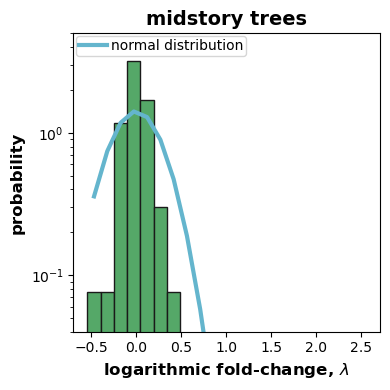

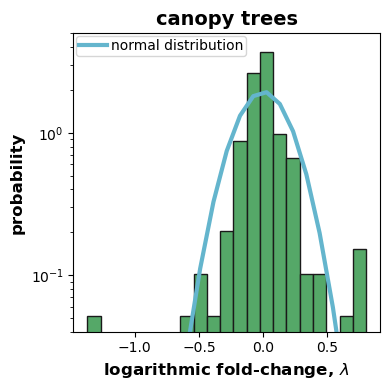

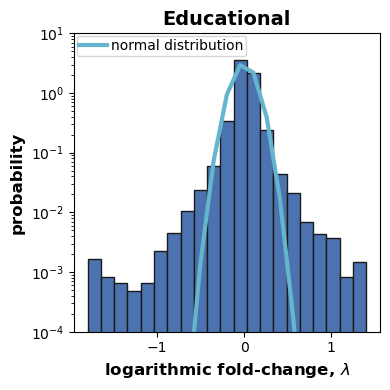

In [38]:
# neutral_inst = shared_func.azaele_neutral_logG_distribution()
# weibull_inst = shared_func.symmetric_weibull_gen() 
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig1_cartoon_with_time_series/compare_gaussian/'
n_bins=21



sp_list=[3,10]

genus_names_full=caporaso['gtax']
tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)

rel_abu_mat=rel_abu_t_mat_full[sp_idx]
genus_names_list=genus_names_full[sp_idx]
idx_1_list=[]
idx_2_list=[]
for j,t2 in enumerate(time_points):
    if np.any(time_points==t2-tau):
        i=int(np.where(time_points==t2-tau)[0])
        t1=time_points[i]
#         print (i,j, t1, t2)
        idx_1_list.append(i)
        idx_2_list.append(j)
idxs_1=np.array(idx_1_list)
idxs_2=np.array(idx_2_list)

for i,sp in enumerate(sp_list):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot()

    otu_t2=np.ravel(rel_abu_mat[sp,idxs_2])
    otu_t1=np.ravel(rel_abu_mat[sp,idxs_1])
    idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
    growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
    logG=np.log(growth_rates)
    
#     neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
#             logG,10., 1., floc=0,fscale=1.)
    mu, sigma=scipy.stats.norm.fit(logG,floc=0)
#     _, scale_laplace=scipy.stats.laplace.fit(logG,floc=0)
    histogram, bins = np.histogram(logG, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(logG, bins=n_bins, density=True,facecolor='m', edgecolor='k')
    ax.plot(bin_centers, scipy.stats.norm.pdf(bin_centers,loc=0,scale=sigma),
            'c-',lw=3,label='normal distribution') 
#     ax.plot(bin_centers, scipy.stats.laplace.pdf(bin_centers,loc=0,scale=scale_laplace),
#             'y-',lw=3,label='Laplace')     
#     yvals=neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut)
#     ax.plot(bin_centers, yvals,'r-',lw=3,label=r'$P_{fluc}$') 
    ax.legend(loc=2,borderaxespad=0.2, borderpad=0.2,handletextpad=.3)
    ax.set_ylim(4e-3,1.5) 
    genus_name=genus_names_list[sp][0][0]
    ax.set_title('OTU_'+str(int(sp))  +' ('+genus_name+')')


    ax.set_xlabel(r'logarithmic fold-change, $\lambda$')
    ax.set_yscale('log')
    ax.set_ylabel(r'probability')
    
    fig.patch.set_facecolor('white')  
    fig.tight_layout()

    plt.savefig(dest_path+'compare_gaussian_'+'OTU_'+str(int(sp))+'_'+genus_name+'.pdf')
    plt.show()
    
    
    

cluster_id_list=[3,4] 

for i, clust_id in enumerate(cluster_id_list):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot()
    BCI_logG_clusti=get_BCI_clust_logG(df_BCI_rel_clust,clust_id)   
#     neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
#             BCI_logG_clusti,10., 1., floc=0,fscale=1.)
    
    mu, sigma=scipy.stats.norm.fit(BCI_logG_clusti,floc=0)
#     _, scale_laplace=scipy.stats.laplace.fit(BCI_logG_clusti,floc=0)
    histogram, bins = np.histogram(BCI_logG_clusti, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(BCI_logG_clusti, bins=n_bins, density=True,facecolor='g',edgecolor='k')
    ax.plot(bin_centers, scipy.stats.norm.pdf(bin_centers,loc=0,scale=sigma),
            'c-',lw=3,label='normal distribution') 
#     ax.plot(bin_centers, scipy.stats.laplace.pdf(bin_centers,loc=0,scale=scale_laplace),
#             'y-',lw=3,label='Laplace')     
#     ax.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut),
#              'r-',lw=3,label=r'$P_{fluc}$') 
    ax.set_title(tree_clust_names[clust_id-1])

    ax.set_ylim(4e-2,5) 
    ax.legend(loc=2,borderaxespad=0.2, borderpad=0.2,handletextpad=.3)
    ax.set_xlabel(r'logarithmic fold-change, $\lambda$')
    ax.set_yscale('log')
    ax.set_ylabel(r'probability')
    
    fig.patch.set_facecolor('white')  
    fig.tight_layout()


    plt.savefig(dest_path+'compare_gaussian_'+str(int(clust_id))+'_'
                 +tree_clust_names[clust_id-1].replace(' ','_')+'.pdf')
    plt.show()
    
    
    
    
    
naics_plot_list=['naics_55','naics_61' ]
for i,naics in enumerate(naics_plot_list):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot()
    logratio_list=shared_func.get_LogRatio(df_metroF_time, [naics],
                                       time_stamps_likeCBP_list,tau=12)
    emp_logG=np.ravel(logratio_list)
#     neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
#             emp_logG,10., 1., floc=0,fscale=1.)
    mu, sigma=scipy.stats.norm.fit(emp_logG,floc=0)
#     _, scale_laplace=scipy.stats.laplace.fit(emp_logG,floc=0)
    histogram, bins = np.histogram(emp_logG, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(emp_logG, bins=n_bins, density=True,facecolor='b',edgecolor='k')
    ax.plot(bin_centers, scipy.stats.norm.pdf(bin_centers,loc=0,scale=sigma),
            'c-',lw=3,label='normal distribution') 
#     ax.plot(bin_centers, scipy.stats.laplace.pdf(bin_centers,loc=0,scale=scale_laplace),
#             'y-',lw=3,label='Laplace') 
#     ax.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut),
#              'r-',lw=3,label=r'$P_{fluc}$') 
    ax.set_ylim(1e-4,10) 
    
    sector_name=shared_func.sector_from_naics(df_naics_ref, naics, shorten=True)
    ax.set_title(sector_name)
    ax.legend(loc=2,borderaxespad=0.2, borderpad=0.2,handletextpad=.3)
    ax.set_xlabel(r'logarithmic fold-change, $\lambda$')
    ax.set_yscale('log')
    ax.set_ylabel(r'probability')
    
    fig.patch.set_facecolor('white')  
    fig.tight_layout()

    plt.savefig(dest_path+'compare_gaussian_'+naics+'_'+sector_name+'.pdf')
    plt.show()
    
    
    
    
    






https://en.wikipedia.org/wiki/Faecalibacterium levels implicated in crohn's disease

In [199]:
tree_clust_names[clust_id-1]

'canopy trees'

## goodness of fit test using likelihood of random samples

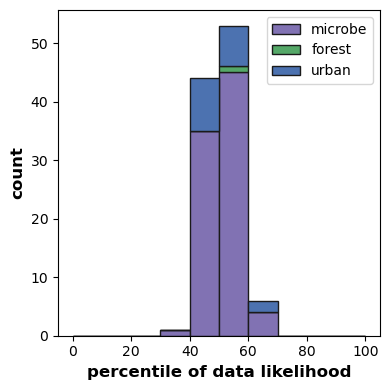

In [115]:
pct_microbe_data=[]
pct_city_data=[]

with open(combined_params_path+'microbe_logG_fit_and_simvals.pkl', 'rb') as handle:
    microbe_ll_df=pd.DataFrame(pickle.load(handle)  )
with open(combined_params_path+'BCI_logG_fit_and_simvals.pkl', 'rb') as handle:
    BCI_ll_dict=pickle.load(handle)  
with open(combined_params_path+'city_logG_fit_and_simvals.pkl', 'rb') as handle:
    city_ll_df=pd.DataFrame(pickle.load(handle)  )

for i in range(len(microbe_ll_df)):
#     logLik_sim= np.sort(logLik_microbe_sim_list[i])
    logLik_data= microbe_ll_df.loc[i]['logLk']
    logLik_sim= np.array(microbe_ll_df.loc[i]['logLk_sims'])
    
    if np.any(logLik_sim>logLik_data):
        percentile_score=np.sum(logLik_sim>logLik_data)*100./len(logLik_sim)
    else:
        percentile_score=0
    pct_microbe_data.append(percentile_score)
    
logLik_data= BCI_ll_dict['logLk'][0]
logLik_sim= BCI_ll_dict['logLk_sims'][0]
if np.any(logLik_sim>logLik_data):
    percentile_score=np.sum(logLik_sim>logLik_data)*100./len(logLik_sim)
else:
    percentile_score=0
pct_BCI_data=percentile_score

for i in range(len(city_ll_df)):
    logLik_data= city_ll_df.loc[i]['logLk']
    logLik_sim= np.array(city_ll_df.loc[i]['logLk_sims'])
    if np.any(logLik_sim>logLik_data):
        percentile_score=np.sum(logLik_sim>logLik_data)*100./len(logLik_sim)
    else:
        percentile_score=0
    pct_city_data.append(percentile_score)
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig1_growth_distribution/'
n_bins=5
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot()

x_multi=[]
x_multi.append(pct_microbe_data)
x_multi.append([pct_BCI_data])
x_multi.append(pct_city_data)
# ax1.hist(x_multi, bins=np.linspace(0,100,11) , histtype='bar', color=['m','g','b'],
#          label=['microbe','forest','employment'], rwidth=.8)
ax1.hist(x_multi, bins=np.linspace(0,100,11) , histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbe','forest','urban'])


ax1.set_xlabel('percentile of data likelihood')
ax1.set_ylabel('count')
ax1.legend(loc='best')
fig.patch.set_facecolor('white')  
fig.tight_layout()
plt.savefig(dest_path+'llk_data_vs_sampling_logG.png')
plt.show()



##### for BCI cluster data

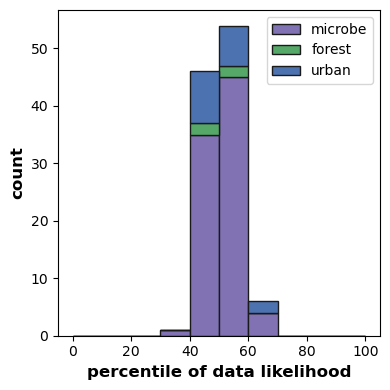

In [4]:
pct_microbe_data=[]
pct_city_data=[]
pct_BCI_data=[]
with open(combined_params_path+'microbe_logG_fit_and_simvals.pkl', 'rb') as handle:
    microbe_ll_df=pd.DataFrame(pickle.load(handle)  )
with open(combined_params_path+'BCI_logG_clustfit_and_simvals.pkl', 'rb') as handle:
    BCI_ll_dict=pickle.load(handle)  
    del BCI_ll_dict['sp'] ## empty column prevents converting to dataframe
    BCI_ll_df=pd.DataFrame(BCI_ll_dict)
with open(combined_params_path+'city_logG_fit_and_simvals.pkl', 'rb') as handle:
    city_ll_df=pd.DataFrame(pickle.load(handle)  )

for i in range(len(microbe_ll_df)):
#     logLik_sim= np.sort(logLik_microbe_sim_list[i])
    logLik_data= microbe_ll_df.loc[i]['logLk']
    logLik_sim= np.array(microbe_ll_df.loc[i]['logLk_sims'])
    
    if np.any(logLik_sim>logLik_data):
        percentile_score=np.sum(logLik_sim>logLik_data)*100./len(logLik_sim)
    else:
        percentile_score=0
    pct_microbe_data.append(percentile_score)
for i in range(len(BCI_ll_df)):    
    logLik_data= BCI_ll_df.loc[i]['logLk']
    logLik_sim=  np.array(BCI_ll_df.loc[i]['logLk_sims'])
    if np.any(logLik_sim>logLik_data):
        percentile_score=np.sum(logLik_sim>logLik_data)*100./len(logLik_sim)
    else:
        percentile_score=0
    pct_BCI_data.append(percentile_score)

for i in range(len(city_ll_df)):
    logLik_data= city_ll_df.loc[i]['logLk']
    logLik_sim= np.array(city_ll_df.loc[i]['logLk_sims'])
    if np.any(logLik_sim>logLik_data):
        percentile_score=np.sum(logLik_sim>logLik_data)*100./len(logLik_sim)
    else:
        percentile_score=0
    pct_city_data.append(percentile_score)
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig1_growth_distribution/'
n_bins=5
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot()

x_multi=[]
x_multi.append(pct_microbe_data)
x_multi.append(pct_BCI_data)
x_multi.append(pct_city_data)
# ax1.hist(x_multi, bins=np.linspace(0,100,11) , histtype='bar', color=['m','g','b'],
#          label=['microbe','forest','employment'], rwidth=.8)
ax1.hist(x_multi, bins=np.linspace(0,100,11) , histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbe','forest','urban'])


ax1.set_xlabel('percentile of data likelihood')
ax1.set_ylabel('count')
ax1.legend(loc='best')
fig.patch.set_facecolor('white')  
fig.tight_layout()
plt.savefig(dest_path+'llk_data_vs_sampling_logG_withclust.png')
plt.show()



In [103]:
logLik_data= BCI_ll_dict['logLk'][0]
logLik_sim= BCI_ll_dict['logLk_sims']

#### analysis of run time of sampling.

generating 10 sample lists from the pdf of length =BCI data~900 took 17 seconds once we provided the CDF definition (it was 593 seconds when CDF wasn't defined).

So 1000 random numbers takes~2 secs. Hence 10^3 repeats of BCI data will take 2000 secs=40mins

For each panel of the city data:
len(citydata) is 35000 points for each category. So 10^3 repeats of city data will take 80,000 secs =22 hours. 

For each panel of the microbe data, length is ~300 points. and so each panel witll take 12 minutes.

If we do just 100 repeats instead, then things will much more managable.


Even then sampling for city data took 60 hours.


In [24]:
naics='naics_55'
logratio_list=shared_func.get_LogRatio(df_metroF_time, [naics],
                                       time_stamps_likeCBP_list,tau=12)

In [26]:
len(np.ravel(logratio_list))

34578

##### testing run time on  BCI data

In [3]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
        BCI_logG,10., 1., floc=0,fscale=1.)
temp=neutral_inst.logpdf(BCI_logG, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut)
logLik = np.sum(temp) 
BCI_tp=neut_tp
BCI_bd=neut_bd


/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1837: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(self._pdf, _a, x, args=args)[0]


In [14]:
logLik 

75.68863282001976

In [22]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
logLik_sim_list=[]
start_time = timeit.default_timer()
# code you want to evaluate
for i in range(10):
    rnd_sample=neutral_inst.rvs(neut_tp, neut_bd, loc=loc_neut,scale= scale_neut,
                                size=len(BCI_logG))
    temp=neutral_inst.logpdf(rnd_sample, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut)
    logLik_sim_list.append(np.sum(temp) )
    
elapsed = timeit.default_timer() - start_time
print ('time in secs', elapsed)

time in secs 17.236621384000046


In [23]:
logLik_sim_list

[96.75339559226961,
 90.19501198058309,
 137.6755680919671,
 101.2022691580059,
 22.434560142980335,
 98.77814774713761,
 101.98378726327056,
 77.7731129757106,
 149.13533956595637,
 115.0773686230762]

In [27]:
sp_list=[3,10,39]#,39]
tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]
idx_1_list=[]
idx_2_list=[]
for j,t2 in enumerate(time_points):
    if np.any(time_points==t2-tau):
        i=int(np.where(time_points==t2-tau)[0])
        t1=time_points[i]
#         print (i,j, t1, t2)
        idx_1_list.append(i)
        idx_2_list.append(j)
idxs_1=np.array(idx_1_list)
idxs_2=np.array(idx_2_list)

for i,sp in enumerate(sp_list):
    otu_t2=np.ravel(rel_abu_mat[sp,idxs_2])
    otu_t1=np.ravel(rel_abu_mat[sp,idxs_1])
    idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
    growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
    logG=np.log(growth_rates)
    
    print ('lenght is', len(logG))

lenght is 273
lenght is 273
lenght is 268


# Mean, CV of lambda  histogram

/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in true_divide


means of microbes, cities, forests 0.00445405425781533 0.0036414971239500014 -0.0010575012711743284
CVs of microbes, cities, forests 132.76252266705825 22.86114899417329 16.88507644799971


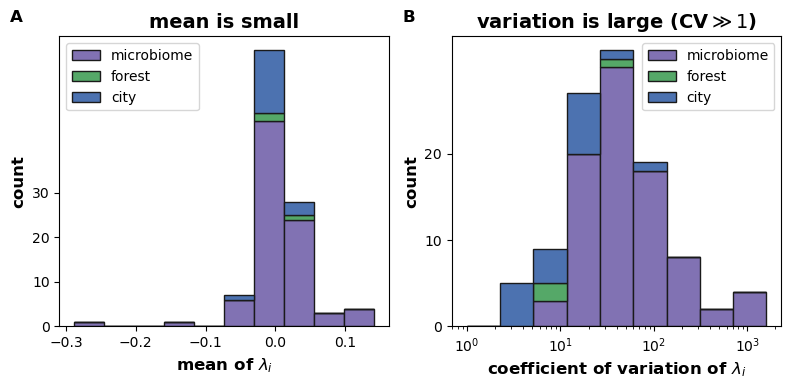

In [41]:
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


#################microbe######
tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]
idx_1_list=[]
idx_2_list=[]
for j,t2 in enumerate(time_points):
    if np.any(time_points==t2-tau):
        i=int(np.where(time_points==t2-tau)[0])
        t1=time_points[i]
        idx_1_list.append(i)
        idx_2_list.append(j)
idxs_1=np.array(idx_1_list)
idxs_2=np.array(idx_2_list)

microbe_mean_logG=[]
microbe_std_logG=[]
microbe_CV_logG=[]
for i,sp in enumerate(np.arange(len(rel_abu_mat))):
    otu_t2=np.ravel(rel_abu_mat[sp,idxs_2])
    otu_t1=np.ravel(rel_abu_mat[sp,idxs_1])
    idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
    growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
    logG=np.log(growth_rates)
    cv_logG=np.abs(np.std(logG)/np.mean(logG))
    microbe_mean_logG.append(np.mean(logG))
    microbe_std_logG.append(np.std(logG))
    microbe_CV_logG.append(cv_logG)

#################city######
city_mean_logG=[]
city_std_logG=[]
city_CV_logG=[]
for i,naics in enumerate(naics_keys_to_plot):
    
    logratio_list=shared_func.get_LogRatio(df_metroF_time, [naics],
                                       time_stamps_likeCBP_list,tau=12)
    emp_logG=np.ravel(logratio_list)
    cv_logG=np.abs(np.std(emp_logG)/np.mean(emp_logG))
    city_mean_logG.append(np.mean(emp_logG))
    city_std_logG.append(np.std(emp_logG))
    city_CV_logG.append(cv_logG)
    
#################BCI######    

BCI_clust_mean_logG=[]
BCI_clust_std_logG=[]
BCI_clust_CV_logG=[]
for i, clust_id in enumerate(range(1,4)):
#     BCI_logG_clusti=get_BCI_clust_logG(df_counts,clust_id)  ## for counts
    BCI_logG_clusti=get_BCI_clust_logG(df_BCI_rel_clust,clust_id)  ## for relative abundance
    
    BCI_logG_clusti=np.ravel(BCI_logG_clusti)
    cv_logG=np.abs(np.std(BCI_logG_clusti)/np.mean(BCI_logG_clusti))
    BCI_clust_mean_logG.append(np.mean(BCI_logG_clusti))
    BCI_clust_std_logG.append(np.std(BCI_logG_clusti))
    BCI_clust_CV_logG.append(cv_logG)
    
    
x_multi=[]
x_multi.append(microbe_mean_logG)
x_multi.append(BCI_clust_mean_logG)
x_multi.append(city_mean_logG)
ax1.hist(x_multi, bins=10 , histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbiome','forest','city'])
ax1.set_xlabel('mean of $\lambda_i$')
ax1.set_ylabel('count')
ax1.legend(loc='best')
ax1.set_title(r'mean is small')
ax1.text(-0.15,1.05,'A',fontweight="bold",
            transform=ax1.transAxes,fontsize=MEDIUM_SIZE)
ax1.set_yticks([0,10,20,30])

x_multi2=[]
x_multi2.append(microbe_CV_logG)
x_multi2.append(BCI_clust_CV_logG)
x_multi2.append(city_CV_logG)
ax2.hist(x_multi2, bins=np.logspace(np.log10(1),np.log10(1600.0), 10) , histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbiome','forest','city'])
ax2.set_xscale('log')
ax2.set_xlabel('coefficient of variation of $\lambda_i$')
ax2.set_ylabel('count')
ax2.set_title(r'variation is large (CV$\gg1$)')
ax2.legend(loc='best')
ax2.set_yticks([0,10,20])
ax2.text(-0.15,1.05,'B',fontweight="bold",
            transform=ax2.transAxes,fontsize=MEDIUM_SIZE)

print ('means of microbes, cities, forests', np.mean(microbe_mean_logG),
      np.mean(BCI_clust_mean_logG), np.mean(city_mean_logG))
print ('CVs of microbes, cities, forests', np.mean(microbe_CV_logG),
      np.mean(BCI_clust_CV_logG), np.mean(city_CV_logG))
plt.tight_layout()

fig_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/SI_Fig_mean_CV_of_lambda/'
plt.savefig(fig_path+'mean_CV_lambda.pdf')
plt.show()

In [18]:
np.min(np.abs(microbe_CV_logG)),np.min(np.abs(city_CV_logG)),np.min(np.abs(BCI_clust_CV_logG))

(6.044469266902033, 3.108156803359172, 3.1855142973191164)

## for absolute abundances

/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: invalid value encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: divide by zero encountered in true_divide


means of cities, forests -0.05207412547341256 0.00788217134212163
CVs of cities, forests 10.774727372527574 20.83636439966255


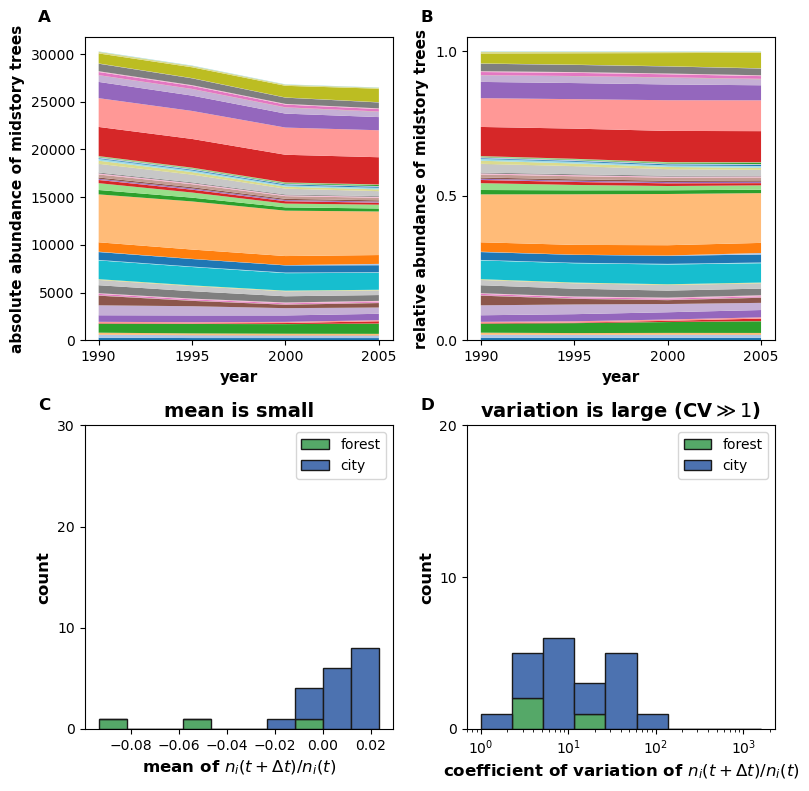

In [29]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)


                      
######## time series stack plot#######
BCI_time_points=['Y1990', 'Y1995', 'Y2000', 'Y2005']
clust_id=3

df_clusti=df_counts[df_counts['height_cluster']==clust_id]    
BCI_abu_mat=df_clusti[BCI_time_points].values

color_list=sns.color_palette(palette='tab20',n_colors=100)
stckplot = ax1.stackplot(
        BCI_time_points, BCI_abu_mat, 
         colors=color_list,linewidth=1.0)

df_rel_clusti=df_BCI_rel_clust[df_BCI_rel_clust['height_cluster']==clust_id]    
BCI_relabu_mat=df_rel_clusti[BCI_time_points].values
stckplot = ax2.stackplot(
        BCI_time_points, BCI_relabu_mat, 
         colors=color_list,linewidth=1.0)

ax1.set_ylabel('absolute abundance of '+tree_clust_names[clust_id-1])
ax2.set_ylabel('relative abundance of '+tree_clust_names[clust_id-1])
#     ax1.set_yticks([0,20000, 40000])
ax2.set_yticks([0,.5,1.])
for ax in [ax1,ax2]:# [ax1, ax2, ax3]:  # make bigger font
        ax.yaxis.label.set_size(11)
        ax.yaxis.label.set_weight('bold')
        ax.xaxis.label.set_size(11)
        ax.xaxis.label.set_weight('bold')
        ax.set_xlabel('year')
        ax.set_xticklabels(['1990', '1995', '2000', '2005'])

                      
ax1.text(-0.15,1.05,'A',fontweight="bold",
            transform=ax1.transAxes,fontsize=MEDIUM_SIZE)
ax2.text(-0.15,1.05,'B',fontweight="bold",
            transform=ax2.transAxes,fontsize=MEDIUM_SIZE)
                      
 #######CV and mu plots########                     
                      
#################city######
city_mean_logG=[]
city_std_logG=[]
city_CV_logG=[]
for i,naics in enumerate(naics_keys_to_plot):
    
    logratio_list=shared_func.get_LogRatio(df_metro_time, [naics],
                                       time_stamps_likeCBP_list,tau=12)
    emp_logG=np.ravel(logratio_list)
    cv_logG=np.abs(np.std(emp_logG)/np.mean(emp_logG))
    city_mean_logG.append(np.mean(emp_logG))
    city_std_logG.append(np.std(emp_logG))
    city_CV_logG.append(cv_logG)
    
#################BCI######    

BCI_clust_mean_logG=[]
BCI_clust_std_logG=[]
BCI_clust_CV_logG=[]
for i, clust_id in enumerate(range(1,4)):
    BCI_logG_clusti=get_BCI_clust_logG(df_counts,clust_id)  ## for counts
   # BCI_logG_clusti=get_BCI_clust_logG(df_BCI_rel_clust,clust_id)  ## for relative abundance
    
    BCI_logG_clusti=np.ravel(BCI_logG_clusti)
    cv_logG=np.abs(np.std(BCI_logG_clusti)/np.mean(BCI_logG_clusti))
    BCI_clust_mean_logG.append(np.mean(BCI_logG_clusti))
    BCI_clust_std_logG.append(np.std(BCI_logG_clusti))
    BCI_clust_CV_logG.append(cv_logG)
    
    
x_multi=[]
x_multi.append(BCI_clust_mean_logG)
x_multi.append(city_mean_logG)
ax3.hist(x_multi, bins=10 , histtype='barstacked', color=['g','b'],
         edgecolor='k',label=['forest','city'])
ax3.set_xlabel(r'mean of $n_i(t+\Delta t)/ n_i(t)$')
ax3.set_ylabel('count')
ax3.legend(loc='best')
ax3.set_title(r'mean is small')
ax3.text(-0.15,1.05,'C',fontweight="bold",
            transform=ax3.transAxes,fontsize=MEDIUM_SIZE)
ax3.set_yticks([0,10,20,30])

x_multi2=[]
x_multi2.append(BCI_clust_CV_logG)
x_multi2.append(city_CV_logG)
ax4.hist(x_multi2, bins=np.logspace(np.log10(1),np.log10(1600.0), 10) ,
         histtype='barstacked', color=['g','b'],
         edgecolor='k',label=['forest','city'])
ax4.set_xscale('log')
ax4.set_xlabel(r'coefficient of variation of $n_i(t+\Delta t)/ n_i(t)$')
ax4.set_ylabel('count')
ax4.set_title(r'variation is large (CV$\gg1$)')
ax4.legend(loc='best')
ax4.set_yticks([0,10,20])
ax4.text(-0.15,1.05,'D',fontweight="bold",
            transform=ax4.transAxes,fontsize=MEDIUM_SIZE)

print ('means of cities, forests', 
      np.mean(BCI_clust_mean_logG), np.mean(city_mean_logG))
print ('CVs of cities, forests', 
      np.mean(BCI_clust_CV_logG), np.mean(city_CV_logG))
plt.tight_layout()

fig_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/SI_Fig_mean_CV_of_lambda/'
plt.savefig(fig_path+'mean_CV_lambda_absabu.pdf')
plt.show()

In [10]:
np.min(np.abs(city_CV_logG)),np.min(np.abs(BCI_clust_CV_logG))

(1.7330759986901576, 3.1855142973191164)

# timescale of species sectors and mean abundance

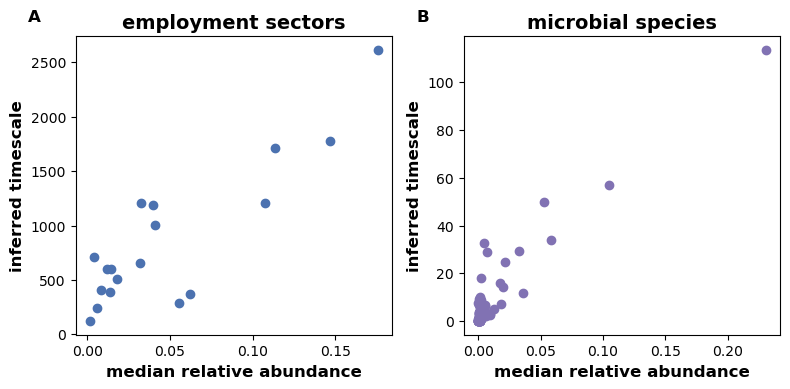

(0.8644002624936695, 3.7232223672338575e-06) SpearmanrResult(correlation=0.6635706914344685, pvalue=0.0026779839744573825)
(0.9278179876440826, 2.6782498125009825e-37) SpearmanrResult(correlation=0.6847044527776177, pvalue=4.983132196467938e-13)


In [38]:
with open(combined_params_path+'city_logG_fitvals.pkl', 'rb') as handle:
    city_logG_params=pickle.load(handle)  
df_city=pd.DataFrame.from_dict(city_logG_params) 
df_city['sector_name']='A'
df_city['tau']=1./df_city['tp_fit']
df_city['mean_relabu']=0.0
df_city['median_relabu']=0.0
for i, row in df_city.iterrows():
    naics=str(row['naics'])
    df_city.at[i,'sector_name'] = shared_func.sector_from_naics(df_naics_ref, naics, shorten=True)
    
    emp,indxs=shared_func.get_nonimputed_data(df_metroF_time,[naics],'16-Q3-M1')
    emp=emp[indxs]
    df_city.at[i,'mean_relabu']=np.mean(emp)
    df_city.at[i,'median_relabu']=np.median(emp)

with open(combined_params_path+'microbe_logG_fitvals.pkl', 'rb') as handle:
    microbe_logG_params=pickle.load(handle)  
df_microbe=pd.DataFrame.from_dict(microbe_logG_params) 

time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
genus_names_full=caporaso['gtax']
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]
genus_names_list=genus_names_full[sp_idx]

df_microbe['genus_name']=genus_names_list
df_microbe['tau']=1./df_microbe['tp_fit']
df_microbe['mean_relabu']=np.mean(rel_abu_mat, axis=1  )
df_microbe['median_relabu']=np.median(rel_abu_mat, axis=1  )

fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.plot(df_city['median_relabu'],df_city['tau'],'bo')
ax2.plot(df_microbe['median_relabu'],df_microbe['tau'],'mo')
ax1.set_ylabel('inferred timescale')
ax1.set_xlabel('median relative abundance')
ax2.set_ylabel('inferred timescale')
ax2.set_xlabel('median relative abundance')
# ax1.set_yscale('log')
# ax1.set_xscale('log')
ax1.set_title('employment sectors')
ax2.set_title('microbial species')
ax1.text(-0.15,1.05,'A',fontweight="bold",
            transform=ax1.transAxes,fontsize=MEDIUM_SIZE)
ax2.text(-0.15,1.05,'B',fontweight="bold",
            transform=ax2.transAxes,fontsize=MEDIUM_SIZE)
plt.tight_layout()
fig_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/SI_Fig_timescale_abu_corr/'
plt.savefig(fig_path+'tau_abu_corr.pdf')

plt.show()    
print(scipy.stats.pearsonr( df_city['median_relabu'],df_city['tau']),
      scipy.stats.spearmanr(df_city['median_relabu'],df_city['tau']))
print(scipy.stats.pearsonr( df_microbe['median_relabu'],df_microbe['tau']),
      scipy.stats.spearmanr(df_microbe['median_relabu'],df_microbe['tau']))

# Gamma distribution fits

## g.o.f test compared to likelihood of random samples
for microbial data, we simply ignore samples with zero relative abundance as we cannot evaluate that (And assume zero is due to finite observation cutoff)

##### first sample the SSD data and compute log likelihoods

In [3]:
tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]

start_time = timeit.default_timer()
logLik_microbe_data_list=[]
logLik_microbe_sim_list=[]
for sp in range(len(rel_abu_mat)):
    otu_abu=rel_abu_mat[sp]
    otu_abu=otu_abu[otu_abu>0]
    a_gamma,dummy_loc_gamma, scale_gamma=scipy.stats.gamma.fit(
                            otu_abu, 10,floc=0.,scale=2 )
    temp=scipy.stats.gamma.logpdf(otu_abu, a_gamma, loc=dummy_loc_gamma,scale= scale_gamma)
    logLik_microbe_data = np.sum(temp) 
    logLik_sim_list=[]
    for i in range(1000):
        rnd_sample=scipy.stats.gamma.rvs(a_gamma, loc=dummy_loc_gamma,scale= scale_gamma,
                                         size=len(otu_abu))
        temp=scipy.stats.gamma.logpdf(rnd_sample, a_gamma, loc=dummy_loc_gamma,scale= scale_gamma)
        logLik_sim_list.append(np.sum(temp) )
    logLik_microbe_data_list.append(logLik_microbe_data)
    logLik_microbe_sim_list.append(logLik_sim_list)

elapsed = timeit.default_timer() - start_time
print ('time in secs', elapsed)

########### BCI neutral############
BCI_popn_1995=BCI_popn[:,1]
BCI_popn_1995=BCI_popn_1995[BCI_popn_1995>0]   
a_gamma,dummy_loc_gamma, scale_gamma=scipy.stats.gamma.fit(
                            BCI_popn_1995, 10,floc=0.,scale=2 )
temp=scipy.stats.gamma.logpdf(BCI_popn_1995, a_gamma, loc=dummy_loc_gamma,scale= scale_gamma)
logLik_BCI_data = np.sum(temp) 
logLik_BCI_sim_list=[]
start_time = timeit.default_timer()

for i in range(1000):
    rnd_sample=scipy.stats.gamma.rvs(a_gamma, loc=dummy_loc_gamma,scale= scale_gamma,
                                     size=len(BCI_popn_1995))
    temp=scipy.stats.gamma.logpdf(rnd_sample, a_gamma, loc=dummy_loc_gamma,scale= scale_gamma)
    logLik_BCI_sim_list.append(np.sum(temp) )

########### BCI cluster relabu############    
logLik_BCIrel_clust_data_list=[]
logLik_BCIrel_clust_sim_list=[]
for c in range(4):
    clust_id=c+1
    clust_popn_1995=df_BCI_rel_clust[df_BCI_rel_clust['height_cluster']==clust_id]['Y1995'].values
    clust_popn_1995=clust_popn_1995[clust_popn_1995>0]
    
    a_gamma,dummy_loc_gamma, scale_gamma=scipy.stats.gamma.fit(
                                clust_popn_1995, 10,floc=0.,scale=2 )
    
    temp=scipy.stats.gamma.logpdf(clust_popn_1995, a_gamma, loc=dummy_loc_gamma,scale= scale_gamma)
    logLik_BCIrel_clust_data_list.append( np.sum(temp) )
    for i in range(1000):
        rnd_sample=scipy.stats.gamma.rvs(a_gamma, loc=dummy_loc_gamma,scale= scale_gamma,
                                         size=len(clust_popn_1995))
        temp=scipy.stats.gamma.logpdf(rnd_sample, a_gamma, loc=dummy_loc_gamma,scale= scale_gamma)
        logLik_sim_list.append(np.sum(temp) )       
    logLik_BCIrel_clust_sim_list.append(logLik_sim_list)    
#     print('relabu, clust:',c+1, a_gamma,scale_gamma)
elapsed = timeit.default_timer() - start_time
print ('time in secs', elapsed)

########### BCI cluster absolute counts############ 
logLik_BCIclust_data_list=[]
logLik_BCIclust_sim_list=[]
for c in range(4):
    clust_id=c+1
    clust_popn_1995=df_counts[df_counts['height_cluster']==clust_id]['Y1995'].values
    clust_popn_1995=clust_popn_1995[clust_popn_1995>0]
    
    a_gamma,dummy_loc_gamma, scale_gamma=scipy.stats.gamma.fit(
                                clust_popn_1995, 10,floc=0.,scale=2 )
    
    temp=scipy.stats.gamma.logpdf(clust_popn_1995, a_gamma, loc=dummy_loc_gamma,scale= scale_gamma)
    logLik_BCIclust_data_list.append( np.sum(temp) )
    for i in range(1000):
        rnd_sample=scipy.stats.gamma.rvs(a_gamma, loc=dummy_loc_gamma,scale= scale_gamma,
                                         size=len(clust_popn_1995))
        temp=scipy.stats.gamma.logpdf(rnd_sample, a_gamma, loc=dummy_loc_gamma,scale= scale_gamma)
        logLik_sim_list.append(np.sum(temp) )   
    logLik_BCIclust_sim_list.append(logLik_sim_list) 
#     print('count, clust:',c+1, a_gamma,scale_gamma)
elapsed = timeit.default_timer() - start_time
print ('time in secs', elapsed)
########### City data############ 
start_time = timeit.default_timer()
logLik_city_data_list=[]
logLik_city_sim_list=[]
sector_name_list=[]
for c,naics in enumerate(naics_keys_to_plot):
    emp,indxs=shared_func.get_nonimputed_data(df_metroF_time,[naics],'16-Q3-M1')
    emp=emp[indxs]

    a_gamma,dummy_loc_gamma, scale_gamma=scipy.stats.gamma.fit(
                            emp, .8,floc=0.,scale=2 )
    
    temp=scipy.stats.gamma.logpdf(emp, a_gamma, loc=dummy_loc_gamma,scale= scale_gamma)
    logLik_city_data = np.sum(temp) 
    logLik_sim_list=[]
    for i in range(1000):
        rnd_sample=scipy.stats.gamma.rvs(a_gamma, loc=dummy_loc_gamma,scale= scale_gamma,
                                         size=len(emp))
        temp=scipy.stats.gamma.logpdf(rnd_sample, a_gamma, loc=dummy_loc_gamma,scale= scale_gamma)
        logLik_sim_list.append(np.sum(temp) )
    logLik_city_data_list.append(logLik_city_data)
    logLik_city_sim_list.append(logLik_sim_list)
    sector_name=shared_func.sector_from_naics(df_naics_ref, naics, shorten=True)
    sector_name_list.append(sector_name)

elapsed = timeit.default_timer() - start_time
print ('time in secs', elapsed)



########### City absolute abundance data############ 
start_time = timeit.default_timer()
logLik_city_absabu_data_list=[]
logLik_city_absabu_sim_list=[]
sector_name_list_absabu=[]
for c,naics in enumerate(naics_keys_to_plot):
    emp,indxs=shared_func.get_nonimputed_data(df_metro_time,[naics],'16-Q3-M1')
    emp=emp[indxs]

    a_gamma,dummy_loc_gamma, scale_gamma=scipy.stats.gamma.fit(
                            emp, .8,floc=0.,scale=2 )
    
    temp=scipy.stats.gamma.logpdf(emp, a_gamma, loc=dummy_loc_gamma,scale= scale_gamma)
    logLik_city_absabu_data = np.sum(temp) 
    logLik_sim_list=[]
    for i in range(1000):
        rnd_sample=scipy.stats.gamma.rvs(a_gamma, loc=dummy_loc_gamma,scale= scale_gamma,
                                         size=len(emp))
        temp=scipy.stats.gamma.logpdf(rnd_sample, a_gamma, loc=dummy_loc_gamma,scale= scale_gamma)
        logLik_sim_list.append(np.sum(temp) )
    logLik_city_absabu_data_list.append(logLik_city_absabu_data)
    logLik_city_absabu_sim_list.append(logLik_sim_list)
    sector_name=shared_func.sector_from_naics(df_naics_ref, naics, shorten=True)
    sector_name_list_absabu.append(sector_name)

elapsed = timeit.default_timer() - start_time
print ('time in secs', elapsed)

time in secs 14.712861561999944
time in secs 0.8075305969998681
time in secs 1.420528622999882
time in secs 3.0457322439999643
time in secs 3.1981052960002216


##### then compute percentile scores.

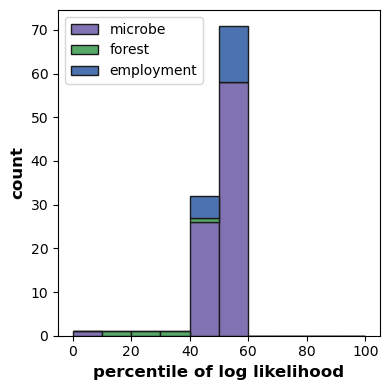

In [5]:
pct_microbe_data=[]
pct_city_absabu_data=[]
pct_city_data=[]
pct_BCIclust_data=[]
pct_BCIrel_clust_data=[]
for i,logLik_data in enumerate(logLik_microbe_data_list):
#     logLik_sim= np.sort(logLik_microbe_sim_list[i])
    logLik_sim= logLik_microbe_sim_list[i]
    if np.any(logLik_sim>logLik_data):
        percentile_score=np.sum(logLik_sim>logLik_data)*100./len(logLik_sim)
    pct_microbe_data.append(percentile_score)
    
#### for all trees as one category
logLik_sim= logLik_BCI_sim_list
if np.any(logLik_sim>logLik_BCI_data):
    percentile_score=np.sum(logLik_sim>logLik_BCI_data)*100./len(logLik_sim)
pct_BCI_data=percentile_score
#### for absolute abundnaces in each tree cluster
for i,logLik_data in enumerate(logLik_BCIclust_data_list):
    logLik_sim= logLik_BCIclust_sim_list[i]
    if np.any(logLik_sim>logLik_data):
        percentile_score=np.sum(logLik_sim>logLik_data)*100./len(logLik_sim)
    pct_BCIclust_data.append(percentile_score)
#### for relative abundnaces in each tree cluster
for i,logLik_data in enumerate(logLik_BCIrel_clust_data_list):
    logLik_sim= logLik_BCIrel_clust_sim_list[i]
    if np.any(logLik_sim>logLik_data):
        percentile_score=np.sum(logLik_sim>logLik_data)*100./len(logLik_sim)
    pct_BCIrel_clust_data.append(percentile_score)
    

#### for relative abundnaces in each sector
for i,logLik_data in enumerate(logLik_city_data_list):
    logLik_sim= logLik_city_sim_list[i]
    if np.any(logLik_sim>logLik_data):
        percentile_score=np.sum(logLik_sim>logLik_data)*100./len(logLik_sim)
    pct_city_data.append(percentile_score)

#### for absolute abundnaces in each sector    
for i,logLik_data in enumerate(logLik_city_absabu_data_list):
    logLik_sim= logLik_city_absabu_sim_list[i]
    if np.any(logLik_sim>logLik_data):
        percentile_score=np.sum(logLik_sim>logLik_data)*100./len(logLik_sim)
    pct_city_absabu_data.append(percentile_score)    

combined_SSD_pctile_scores={'pct_microbe_data':pct_microbe_data,
                            'pct_BCIclust_data':pct_BCIclust_data,
                            'pct_BCIrel_clust_data':pct_BCIrel_clust_data,
                            'pct_BCI_data':pct_BCI_data,
                           'pct_city_data':pct_city_data,
                            'pct_city_absabu_data':pct_city_absabu_data,
                            }
with open(combined_params_path+'combined_SSD_pctile_scores.pkl', 'wb') as handle:
    pickle.dump(combined_SSD_pctile_scores, handle,protocol=4)      

    
    
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig3_SSD_gamma_distribution/'
n_bins=5
fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot()

x_multi=[]
x_multi.append(pct_microbe_data)
x_multi.append(pct_BCIrel_clust_data)
x_multi.append(pct_city_data)
# ax1.hist(x_multi, bins=np.linspace(0,100,11) , histtype='bar', color=['m','g','b'],
#          label=['microbe','forest','employment'], rwidth=.8)
ax1.hist(x_multi, bins=np.linspace(0,100,11) , histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbe','forest','employment'])


ax1.set_xlabel('percentile of log likelihood')
ax1.set_ylabel('count')
ax1.legend(loc='best')
fig.patch.set_facecolor('white')  
fig.tight_layout()
plt.savefig(dest_path+'llk_data_vs_sampling_SSD.png')
plt.show()



## cdf 9 panel with gof included

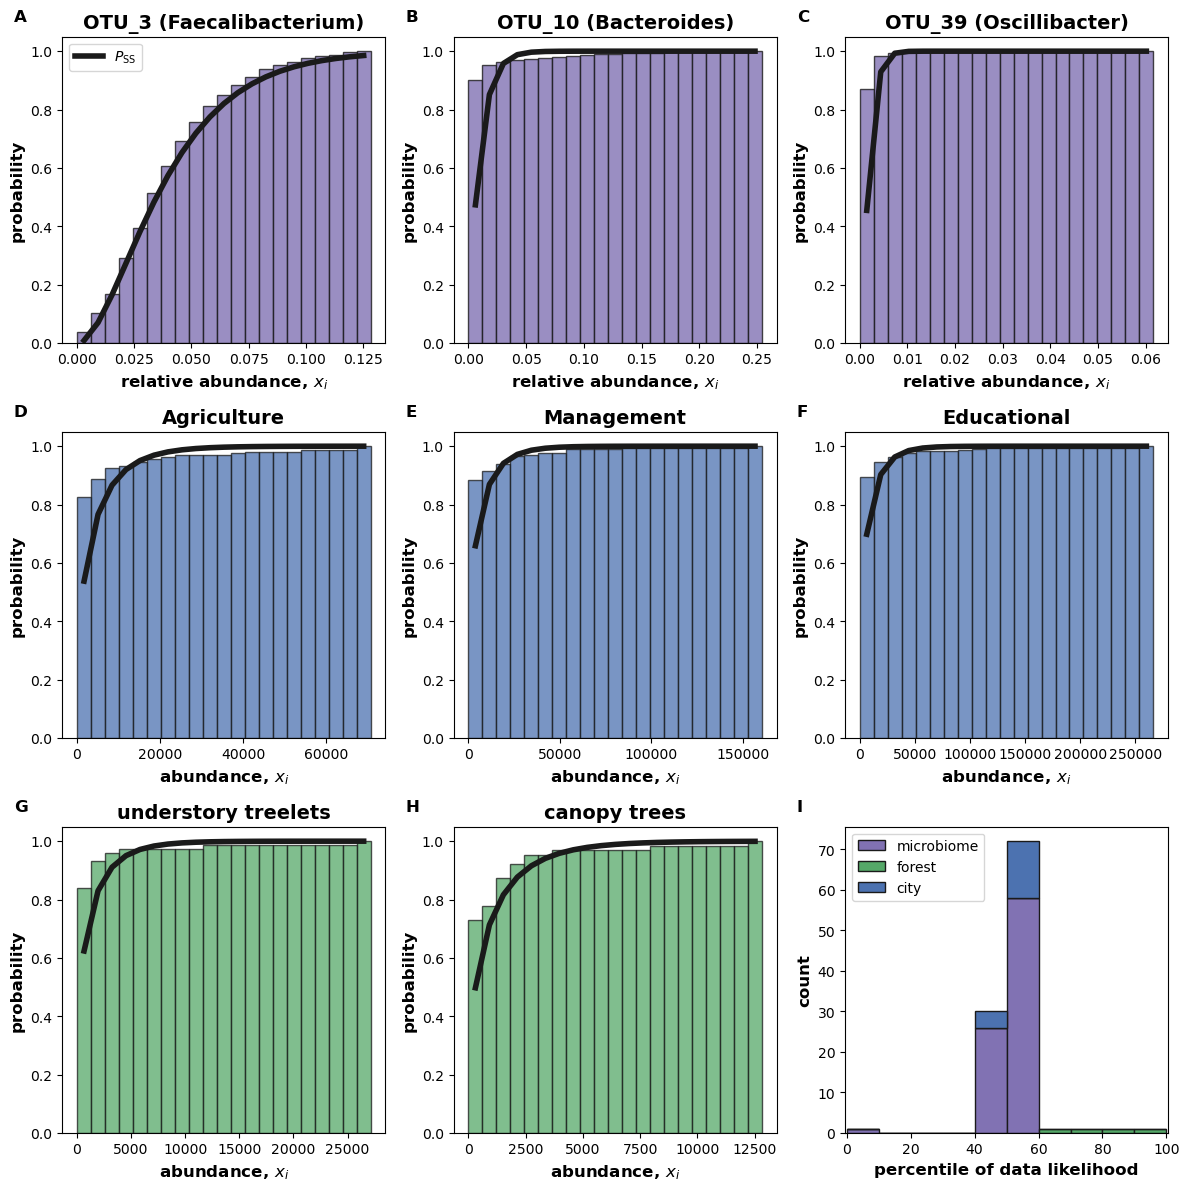

In [7]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
# weibull_inst = shared_func.symmetric_weibull_gen() 
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig3_SSD_gamma_distribution/'
n_bins=21
is_rel_abundances=False



fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)
ax7 = fig.add_subplot(3,3,7)
ax8 = fig.add_subplot(3,3,8)
ax9 = fig.add_subplot(3,3,9)
ax_list=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]


sp_list=[3,10,39]#,39]
tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]
genus_names_list=genus_names_full[sp_idx]

for i,sp in enumerate(sp_list):
    ax=ax_list[i]
    
    otu_abu=rel_abu_mat[sp]
    
    a_gamma,dummy_loc_gamma, scale_gamma=scipy.stats.gamma.fit(
                            otu_abu[otu_abu>0], 10,floc=0.,scale=2 )
    histogram, bins = np.histogram(otu_abu, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    
    ax.hist(otu_abu, bins=bins, density=True,facecolor='m', edgecolor='k', 
            cumulative=True,alpha=0.8)
    ax.plot(bin_centers, scipy.stats.gamma.cdf(bin_centers, a_gamma,
                                               loc=0, scale= scale_gamma),
             'k-',lw=4,label=r'$P_{\mathrm{SS}}$') 
#     ax.set_ylim(4e-3,1) 
    genus_name=genus_names_list[sp][0][0]
    ax.set_title('OTU_'+str(int(sp))  +' ('+genus_name+')')
    ax.text(-0.15,1.05,subplot_label_list[i],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)
    if i ==0:
        ax.legend(loc=2)


cluster_id_list=[2,4] 
# tree_titles=['understory treelets', 'midstory trees']
for i, clust_id in enumerate(cluster_id_list):
    ax=ax_list[i+6]
    if is_rel_abundances:
        clust_popn_1995=df_BCI_rel_clust[df_BCI_rel_clust['height_cluster']==clust_id]['Y1995'].values
    else:
        clust_popn_1995=df_counts[df_counts['height_cluster']==clust_id]['Y1995'].values
    clust_popn_1995=clust_popn_1995[clust_popn_1995>0]
    
    a_gamma,dummy_loc_gamma, scale_gamma=scipy.stats.gamma.fit(
                                clust_popn_1995, 10,floc=0.,scale=2 )

    BCI_shape_gamma=a_gamma
    BCI_scale_gamma=scale_gamma
    histogram, bins = np.histogram(clust_popn_1995, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(clust_popn_1995, bins=bins, density=True,facecolor='g',edgecolor='k', 
             cumulative=True,alpha=0.75)
    ax.plot(bin_centers, scipy.stats.gamma.cdf(bin_centers, a_gamma,
            loc=0, scale= scale_gamma), 'k-',lw=4,label=r'$P_{\mathrm{SS}}$') 
#     ax.set_title(tree_titles[i])
    ax.set_title(tree_clust_names[clust_id-1])
    ax.text(-0.15,1.05,subplot_label_list[i+6],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)
#     ax.legend(loc=2)

# naics_plot_list=['naics_11','naics_31-33','naics_55','naics_61' ]
naics_plot_list=['naics_11','naics_55','naics_61' ]
for i,naics in enumerate(naics_plot_list):
    ax=ax_list[i+3]
    if is_rel_abundances:
        emp,indxs=shared_func.get_nonimputed_data(df_metroF_time,[naics],'16-Q3-M1')
    else:
        emp,indxs=shared_func.get_nonimputed_data(df_metro_time,[naics],'16-Q3-M1')
    emp=emp[indxs]

    a_gamma,dummy_loc_gamma, scale_gamma=scipy.stats.gamma.fit(
                            emp, .8,floc=0.,scale=2 )
    histogram, bins = np.histogram(emp, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(emp, bins=bins, density=True,facecolor='b',edgecolor='k', 
            cumulative=True,alpha=0.75)
    ax.plot(bin_centers, scipy.stats.gamma.cdf(bin_centers, a_gamma,
            loc=0, scale= scale_gamma),'k-',lw=4,label=r'$P_{\mathrm{SS}}$') 
#     ax.set_ylim(1e-4,10) 
#     ax.legend(loc=2)
    sector_name=shared_func.sector_from_naics(df_naics_ref, naics, shorten=True)
    ax.set_title(sector_name)
    ax.text(-0.15,1.05,subplot_label_list[i+3],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)

################ likelihood stack bar plot ##############

with open(combined_params_path+'combined_SSD_pctile_scores.pkl', 'rb') as handle:
    combined_SSD_pctile_scores=pickle.load(handle)      
x_multi=[]
x_multi.append(combined_SSD_pctile_scores ['pct_microbe_data'])
if is_rel_abundances:
    x_multi.append(combined_SSD_pctile_scores['pct_BCIrel_clust_data'])
else:
    x_multi.append(combined_SSD_pctile_scores['pct_BCIclust_data'])
    
if is_rel_abundances:    
    x_multi.append(combined_SSD_pctile_scores ['pct_city_data'])
else:
    x_multi.append(combined_SSD_pctile_scores ['pct_city_absabu_data'])
# ax1.hist(x_multi, bins=np.linspace(0,100,11) , histtype='bar', color=['m','g','b'],
#          label=['microbe','forest','employment'], rwidth=.8)
ax9.hist(x_multi, bins=np.linspace(0,100,11) , histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbiome','forest','city'])


ax9.set_xlabel('percentile of data likelihood')
ax9.set_ylabel('count')
ax9.set_xlim(-0.5,100.5)
ax9.legend(loc='best')
ax9.text(-0.15,1.05,'I',fontweight="bold",
            transform=ax9.transAxes,fontsize=MEDIUM_SIZE)

#################################
    
    
for i, ax in enumerate(ax_list):
    ax.set_ylabel(r'probability')
    if is_rel_abundances:
        ax.set_xlabel(r'relative abundance, $x_i$')
    else:    
        if i >2:
            ax.set_xlabel(r'abundance, $x_i$')
        else:
            ax.set_xlabel(r'relative abundance, $x_i$')
#     ax.set_yscale('log')
    

fig.patch.set_facecolor('white')  
fig.tight_layout()
if is_rel_abundances:
    plt.savefig(dest_path+'SSD_CDF_9panel.png')
    plt.savefig(dest_path+'SSD_CDF_9panel.pdf')
else:
    plt.savefig(dest_path+'SSD_CDF_9panel_absabu.png')
    plt.savefig(dest_path+'SSD_CDF_9panel_absabu.pdf')
plt.show()

## 1-CDF 9panel with gof

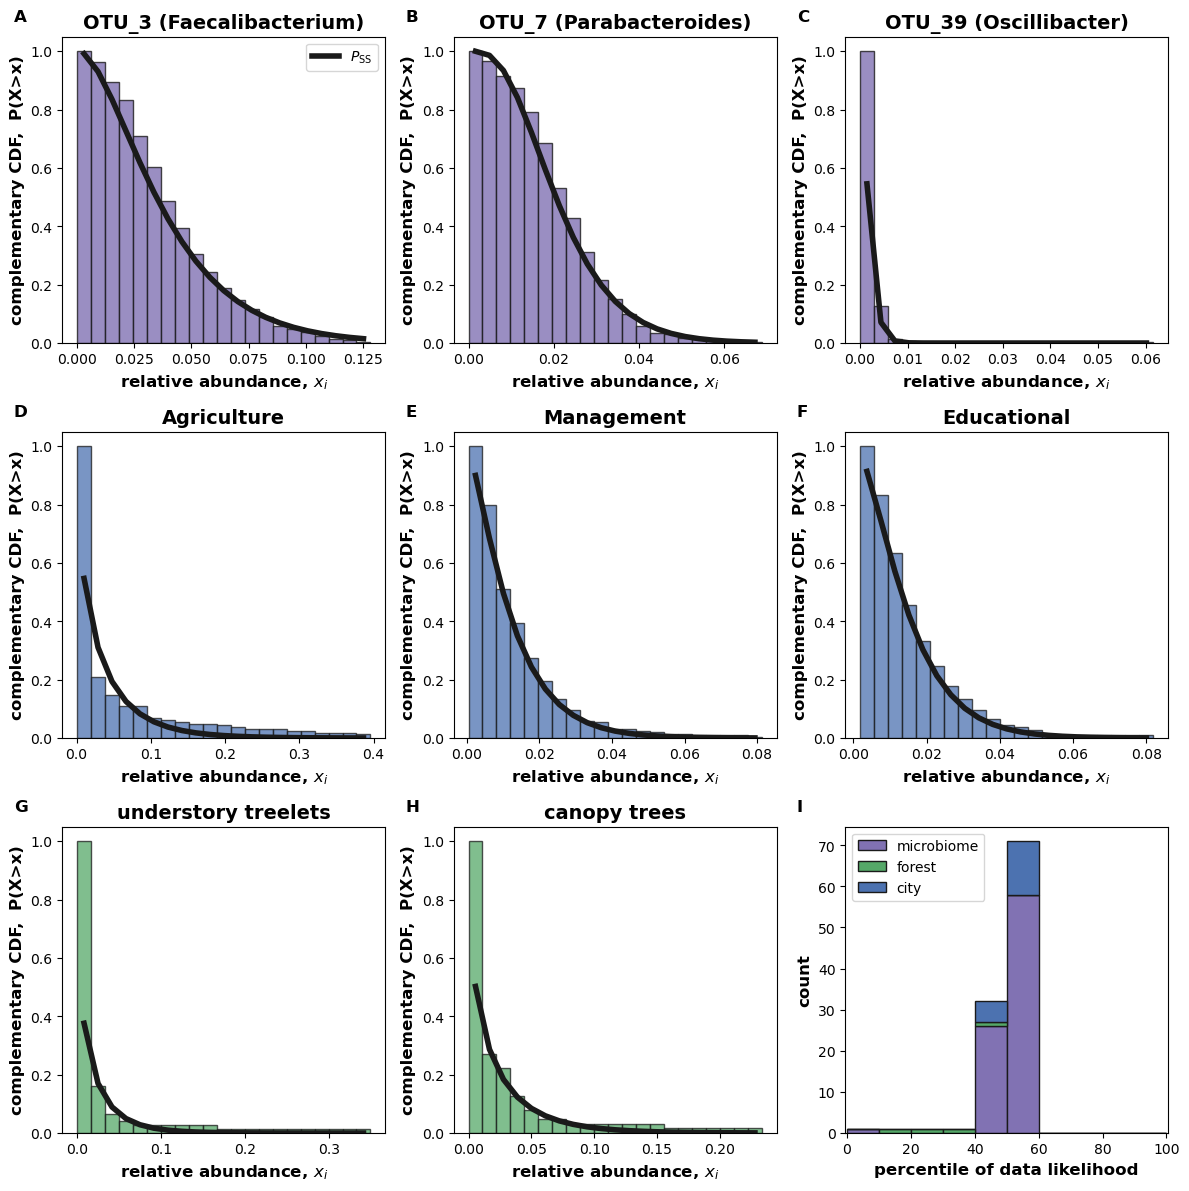

In [74]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
# weibull_inst = shared_func.symmetric_weibull_gen() 
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig3_SSD_gamma_distribution/'
n_bins=21
is_rel_abundances=True



fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)
ax7 = fig.add_subplot(3,3,7)
ax8 = fig.add_subplot(3,3,8)
ax9 = fig.add_subplot(3,3,9)
ax_list=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]


sp_list=[3,7,39]#,39]
tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]
genus_names_list=genus_names_full[sp_idx]

for i,sp in enumerate(sp_list):
    ax=ax_list[i]
    
    otu_abu=rel_abu_mat[sp]
    
    a_gamma,dummy_loc_gamma, scale_gamma=scipy.stats.gamma.fit(
                            otu_abu[otu_abu>0], 10,floc=0.,scale=2 )
    histogram, bins = np.histogram(otu_abu, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    
    ax.hist(otu_abu, bins=bins, density=True,facecolor='m', edgecolor='k', 
            cumulative=-1,alpha=0.8)
    ax.plot(bin_centers, 1-scipy.stats.gamma.cdf(bin_centers, a_gamma,
                                               loc=0, scale= scale_gamma),
             'k-',lw=4,label=r'$P_{\mathrm{SS}}$') 
#     ax.set_ylim(4e-3,1) 
    genus_name=genus_names_list[sp][0][0]
    ax.set_title('OTU_'+str(int(sp))  +' ('+genus_name+')')
    ax.text(-0.15,1.05,subplot_label_list[i],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)
    if i ==0:
        ax.legend(loc=1)


cluster_id_list=[2,4] 
# tree_titles=['understory treelets', 'midstory trees']
for i, clust_id in enumerate(cluster_id_list):
    ax=ax_list[i+6]
    if is_rel_abundances:
        clust_popn_1995=df_BCI_rel_clust[df_BCI_rel_clust['height_cluster']==clust_id]['Y1995'].values
    else:
        clust_popn_1995=df_counts[df_counts['height_cluster']==clust_id]['Y1995'].values
    clust_popn_1995=clust_popn_1995[clust_popn_1995>0]
    
    a_gamma,dummy_loc_gamma, scale_gamma=scipy.stats.gamma.fit(
                                clust_popn_1995, 10,floc=0.,scale=2 )

    BCI_shape_gamma=a_gamma
    BCI_scale_gamma=scale_gamma
    histogram, bins = np.histogram(clust_popn_1995, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(clust_popn_1995, bins=bins, density=True,facecolor='g',edgecolor='k', 
             cumulative=-1,alpha=0.75)
    ax.plot(bin_centers, 1-scipy.stats.gamma.cdf(bin_centers, a_gamma,
            loc=0, scale= scale_gamma), 'k-',lw=4,label=r'$P_{\mathrm{SS}}$') 
#     ax.set_title(tree_titles[i])
    ax.set_title(tree_clust_names[clust_id-1])
    ax.text(-0.15,1.05,subplot_label_list[i+6],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)
#     ax.legend(loc=2)

# naics_plot_list=['naics_11','naics_31-33','naics_55','naics_61' ]
naics_plot_list=['naics_11','naics_55','naics_61' ]
for i,naics in enumerate(naics_plot_list):
    ax=ax_list[i+3]
    if is_rel_abundances:
        emp,indxs=shared_func.get_nonimputed_data(df_metroF_time,[naics],'16-Q3-M1')
    else:
        emp,indxs=shared_func.get_nonimputed_data(df_metro_time,[naics],'16-Q3-M1')
    emp=emp[indxs]

    a_gamma,dummy_loc_gamma, scale_gamma=scipy.stats.gamma.fit(
                            emp, .8,floc=0.,scale=2 )
    histogram, bins = np.histogram(emp, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(emp, bins=bins, density=True,facecolor='b',edgecolor='k', 
            cumulative=-1,alpha=0.75)
    ax.plot(bin_centers, 1-scipy.stats.gamma.cdf(bin_centers, a_gamma,
            loc=0, scale= scale_gamma),'k-',lw=4,label=r'$P_{\mathrm{SS}}$') 
#     ax.set_ylim(1e-4,10) 
#     ax.legend(loc=2)
    sector_name=shared_func.sector_from_naics(df_naics_ref, naics, shorten=True)
    ax.set_title(sector_name)
    ax.text(-0.15,1.05,subplot_label_list[i+3],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)

################ likelihood stack bar plot ##############

with open(combined_params_path+'combined_SSD_pctile_scores.pkl', 'rb') as handle:
    combined_SSD_pctile_scores=pickle.load(handle)      
x_multi=[]
x_multi.append(combined_SSD_pctile_scores ['pct_microbe_data'])
if is_rel_abundances:
    x_multi.append(combined_SSD_pctile_scores['pct_BCIrel_clust_data'])
else:
    x_multi.append(combined_SSD_pctile_scores['pct_BCIclust_data'])
    
if is_rel_abundances:    
    x_multi.append(combined_SSD_pctile_scores ['pct_city_data'])
else:
    x_multi.append(combined_SSD_pctile_scores ['pct_city_absabu_data'])
# ax1.hist(x_multi, bins=np.linspace(0,100,11) , histtype='bar', color=['m','g','b'],
#          label=['microbe','forest','employment'], rwidth=.8)
ax9.hist(x_multi, bins=np.linspace(0,100,11) , histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbiome','forest','city'])


ax9.set_xlabel('percentile of data likelihood')
ax9.set_ylabel('count')
ax9.set_xlim(-0.5,100.5)
ax9.legend(loc='best')
ax9.text(-0.15,1.05,'I',fontweight="bold",
            transform=ax9.transAxes,fontsize=MEDIUM_SIZE)

#################################
    
    
for i, ax in enumerate(ax_list):
    ax.set_ylabel(r'complementary CDF,  P(X>x)')
    if is_rel_abundances:
        ax.set_xlabel(r'relative abundance, $x_i$')
    else:    
        if i >2:
            ax.set_xlabel(r'abundance, $x_i$')
        else:
            ax.set_xlabel(r'relative abundance, $x_i$')
#     ax.set_yscale('log')
    

fig.patch.set_facecolor('white')  
fig.tight_layout()
if is_rel_abundances:
    plt.savefig(dest_path+'SSD_1-CDF_9panel.png')
    plt.savefig(dest_path+'SSD_1-CDF_9panel.pdf')
else:
    plt.savefig(dest_path+'SSD_1-CDF_9panel_absabu.png')
    plt.savefig(dest_path+'SSD_1-CDF_9panel_absabu.pdf')
plt.show()

## 3 panel for absolute abundances

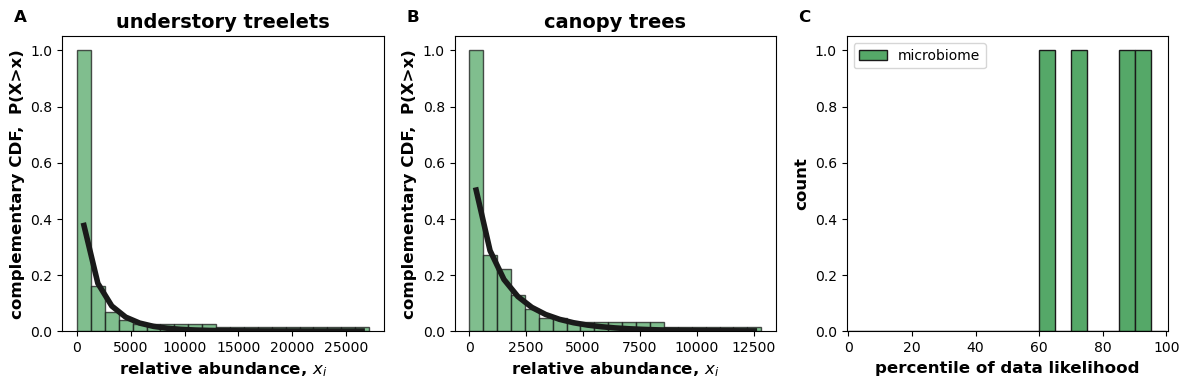

In [124]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
# weibull_inst = shared_func.symmetric_weibull_gen() 
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig3_SSD_gamma_distribution/'
n_bins=21
is_rel_abundances=False 
assert is_rel_abundances==False 



fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)
# ax4 = fig.add_subplot(3,3,4)
# ax5 = fig.add_subplot(3,3,5)
# ax6 = fig.add_subplot(3,3,6)
# ax7 = fig.add_subplot(3,3,7)
# ax8 = fig.add_subplot(3,3,8)
# ax9 = fig.add_subplot(3,3,9)
ax_list=[ax1,ax2]




cluster_id_list=[2,4] 
# tree_titles=['understory treelets', 'midstory trees']
for i, clust_id in enumerate(cluster_id_list):
    ax=ax_list[i]
    if is_rel_abundances:
        clust_popn_1995=df_BCI_rel_clust[df_BCI_rel_clust['height_cluster']==clust_id]['Y1995'].values
    else:
        clust_popn_1995=df_counts[df_counts['height_cluster']==clust_id]['Y1995'].values
    clust_popn_1995=clust_popn_1995[clust_popn_1995>0]
    
    a_gamma,dummy_loc_gamma, scale_gamma=scipy.stats.gamma.fit(
                                clust_popn_1995, 10,floc=0.,scale=2 )

    BCI_shape_gamma=a_gamma
    BCI_scale_gamma=scale_gamma
    histogram, bins = np.histogram(clust_popn_1995, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(clust_popn_1995, bins=bins, density=True,facecolor='g',edgecolor='k', 
             cumulative=-1,alpha=0.75)
    ax.plot(bin_centers, 1-scipy.stats.gamma.cdf(bin_centers, a_gamma,
            loc=0, scale= scale_gamma), 'k-',lw=4,label=r'$P_{\mathrm{SS}}$') 
#     ax.set_title(tree_titles[i])
    ax.set_title(tree_clust_names[clust_id-1])
    ax.text(-0.15,1.05,subplot_label_list[i],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)
#     ax.legend(loc=2)



################ likelihood stack bar plot ##############

with open(combined_params_path+'combined_SSD_pctile_scores.pkl', 'rb') as handle:
    combined_SSD_pctile_scores=pickle.load(handle)      
x_multi=[]
# x_multi.append(combined_SSD_pctile_scores ['pct_microbe_data'])
if is_rel_abundances:
    x_multi.append(combined_SSD_pctile_scores['pct_BCIrel_clust_data'])
else:
    x_multi.append(combined_SSD_pctile_scores['pct_BCIclust_data'])
    
# if is_rel_abundances:    
#     x_multi.append(combined_SSD_pctile_scores ['pct_city_data'])
# else:
#     x_multi.append(combined_SSD_pctile_scores ['pct_city_absabu_data'])
# ax1.hist(x_multi, bins=np.linspace(0,100,11) , histtype='bar', color=['m','g','b'],
#          label=['microbe','forest','employment'], rwidth=.8)
ax3.hist(x_multi, bins=np.linspace(0,100,21) , histtype='barstacked', color=['g'],
         edgecolor='k',label=['microbiome','forest','city'])


ax3.set_xlabel('percentile of data likelihood')
ax3.set_ylabel('count')
ax3.set_xlim(-0.5,100.5)
ax3.legend(loc='best')
ax3.text(-0.15,1.05,'C',fontweight="bold",
            transform=ax3.transAxes,fontsize=MEDIUM_SIZE)

#################################
    
    
for i, ax in enumerate(ax_list):
    ax.set_ylabel(r'complementary CDF,  P(X>x)')
    if is_rel_abundances:
        ax.set_xlabel(r'relative abundance, $x_i$')
    else:    
        if i >2:
            ax.set_xlabel(r'abundance, $x_i$')
        else:
            ax.set_xlabel(r'relative abundance, $x_i$')
#     ax.set_yscale('log')
    

fig.patch.set_facecolor('white')  
fig.tight_layout()
if not is_rel_abundances:
    plt.savefig(dest_path+'SSD_1-CDF_3panel_absabu.png')
    plt.savefig(dest_path+'SSD_1-CDF_3panel_absabu.pdf')
plt.show()

# Alternative gof test (JSD, KS) -SI Fig

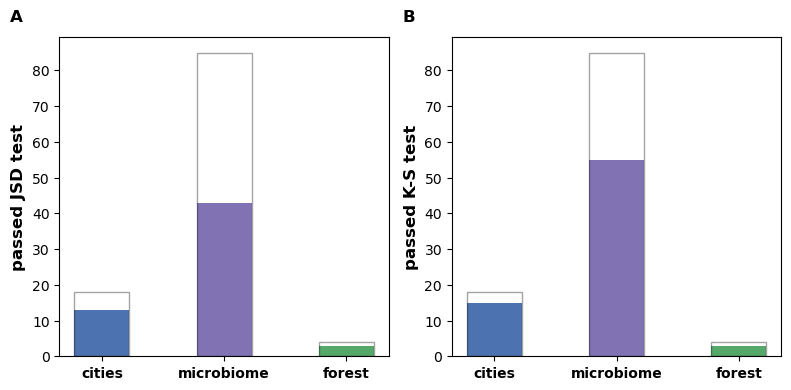

In [17]:
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/SI_gof_tests_JSD_KS/'


with open(combined_params_path+'JSD_pctile_scores_dict.pkl', 'rb') as handle:
        JSD_pctile_scores_dict=pickle.load( handle) 
        
with open(combined_params_path+'microbe_AFD_kstest.pkl', 'rb') as handle:
        microbe_AFD_kstest=pickle.load( handle) 
with open(combined_params_path+'city_AFD_kstest.pkl', 'rb') as handle:
        city_AFD_kstest=pickle.load( handle) 
with open(combined_params_path+'BCI_rel_clust_AFD_kstest.pkl', 'rb') as handle:
        BCI_rel_clust_AFD_kstest=pickle.load( handle) 


# n_bins=5
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)



width=.45
city_passed=np.sum(np.array(JSD_pctile_scores_dict['pct_score_city_JSD']>1))
city_failed=len(JSD_pctile_scores_dict['pct_score_city_JSD'])-city_passed
city_total=len(JSD_pctile_scores_dict['pct_score_city_JSD'])
# ax1.bar(1-width/2,city_passed, width, color='b')
# ax1.bar(1+width/2,city_failed, width, color='b',  alpha=0.4)
ax1.bar(1,city_passed, width, color='b')
ax1.bar(1,city_total, width, 
        facecolor='None', edgecolor='k',  alpha=0.4)


microbe_passed=np.sum(np.array(JSD_pctile_scores_dict['pct_score_microbe_JSD']>1))
microbe_total=len(JSD_pctile_scores_dict['pct_score_microbe_JSD'])
# ax1.bar(2-width/2,microbe_passed, width, color='m')
# ax1.bar(2+width/2,microbe_failed, width, color='m',  alpha=0.4)
ax1.bar(2,microbe_passed, width, color='m')
ax1.bar(2,microbe_total, width, color='m', 
        facecolor='None', edgecolor='k', alpha=0.4)

BCI_rel_clust_passed=np.sum(np.array(JSD_pctile_scores_dict['pct_score_BCI_rel_clust_JSD']>1))
BCI_rel_clust_total=len(JSD_pctile_scores_dict['pct_score_BCI_rel_clust_JSD'])
# ax1.bar(3-width/2,BCI_rel_clust_passed, width, color='g')
# ax1.bar(3+width/2,BCI_rel_clust_failed, width, color='g',  alpha=0.4)
ax1.bar(3,BCI_rel_clust_passed, width, color='g')
ax1.bar(3,BCI_rel_clust_total, width, color='g', 
        facecolor='None', edgecolor='k', alpha=0.4)

## ks test

city_passed=np.sum(np.array(city_AFD_kstest['pval'])>.01)
city_total=len(city_AFD_kstest['pval'])
ax2.bar(1,city_passed, width, color='b')
ax2.bar(1,city_total, width, 
        facecolor='None', edgecolor='k',  alpha=0.4)

microbe_passed=np.sum(np.array(microbe_AFD_kstest['pval'])>.01)
microbe_total=len(microbe_AFD_kstest['pval'])
ax2.bar(2,microbe_passed, width, color='m')
ax2.bar(2,microbe_total, width, color='m', 
        facecolor='None', edgecolor='k', alpha=0.4)

BCI_rel_clust_passed=np.sum(np.array(BCI_rel_clust_AFD_kstest['pval'])>.01)
BCI_rel_clust_total=len(BCI_rel_clust_AFD_kstest['pval'])
ax2.bar(3,BCI_rel_clust_passed, width, color='g')
ax2.bar(3,BCI_rel_clust_total, width, color='g', 
        facecolor='None', edgecolor='k', alpha=0.4)


ax1.set_xticks([1,2,3])
ax1.set_xticklabels(['cities','microbiome','forest'], fontweight='bold')
ax1.set_ylabel('passed JSD test')
ax2.set_xticks([1,2,3])
ax2.set_xticklabels(['cities','microbiome','forest'], fontweight='bold')
ax2.set_ylabel('passed K-S test')

ax1.text(-0.15,1.05,'A',fontweight="bold",
            transform=ax1.transAxes,fontsize=MEDIUM_SIZE)
ax2.text(-0.15,1.05,'B',fontweight="bold",
            transform=ax2.transAxes,fontsize=MEDIUM_SIZE)

fig.patch.set_facecolor('white')  
fig.tight_layout()
plt.savefig(dest_path+'alt_gof_tests.pdf')
plt.show()

In [18]:
JSD_pctile_scores_dict['pct_score_microbe_JSD']

array([ 0. ,  0. ,  0. , 69.5, 14.5, 59.4,  0.5, 16.9,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. , 98. , 43.3, 35.4,  1.9, 97.3, 21.4, 45.6, 72.5,
       16.5, 13.4,  0. , 34.7,  0. ,  0. ,  0. , 23.2,  0. ,  0. , 31.8,
        2.9, 86.4,  3.8,  0. , 41.5,  0.1,  0. , 32.5, 37.7, 28. ,  1.1,
        0. ,  0. ,  0. ,  0.1,  0. , 73.8,  2.1,  0. , 61.1, 18.8,  0. ,
        0. ,  6. , 45.5,  0. ,  0. ,  0. , 40.5,  0. ,  1.6, 19.1, 18. ,
        0.1, 28.1, 23.2,  0.4, 58.8,  2.4, 44.9, 18.9,  0. ,  0.5,  0. ,
        1.1,  0.5,  0. ,  0.8,  0. ,  0.3,  0. , 36.1])

In [20]:
scipy.stats.spearmanr(microbe_AFD_kstest['pval'],JSD_pctile_scores_dict['pct_score_microbe_JSD'] )


SpearmanrResult(correlation=0.8398878380860278, pvalue=9.709863994345644e-24)

In [68]:
genus_names_full=caporaso['gtax']
tree_clust_names=['shrubs','understory treelets', 'midstory trees', 'canopy trees']  
subplot_label_list=['A','B','C','D','E','F','G','H','I','J','K','L']
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/SI_gof_tests_JSD_KS/'
n_bins=21
is_rel_abundances=True



fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)
ax7 = fig.add_subplot(3,3,7)
ax8 = fig.add_subplot(3,3,8)
ax9 = fig.add_subplot(3,3,9)
ax_list=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8, ax9]


sp_list=[3,7,39]#,39]
tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]
genus_names_list=genus_names_full[sp_idx]

for i,sp in enumerate(sp_list):
    ax=ax_list[i]
    
    otu_abu=rel_abu_mat[sp]
    
    a_gamma,dummy_loc_gamma, scale_gamma=scipy.stats.gamma.fit(
                            otu_abu[otu_abu>0], 10,floc=0.,scale=2 )
    histogram, bins = np.histogram(otu_abu, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    
    ax.hist(otu_abu, bins=bins, density=True,facecolor='m', edgecolor='k', 
            cumulative=-1,alpha=0.8)
    ax.plot(bin_centers, 1.-scipy.stats.gamma.cdf(bin_centers, a_gamma,
                                               loc=0, scale= scale_gamma),
             'k-',lw=4,label=r'$P_{\mathrm{SS}}$') 
#     ax.set_ylim(4e-3,1) 
    genus_name=genus_names_list[sp][0][0]
    ax.set_title('OTU_'+str(int(sp))  +' ('+genus_name+')')
    ax.text(-0.15,1.05,subplot_label_list[i],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)
    
    ax.text(.4,.9,'JSD % = {:.1f}'.format(
        JSD_pctile_scores_dict['pct_score_microbe_JSD'][sp]) ,
            fontweight="normal",transform=ax.transAxes,fontsize=MEDIUM_SIZE)
    
    ax.text(.4,.8,r'KS $p$ = {:.1f}'.format(microbe_AFD_kstest['pval'][sp]) ,
            fontweight="normal",transform=ax.transAxes,fontsize=MEDIUM_SIZE)
    
#     if i ==0:
#         ax.legend(loc=2)


cluster_id_list=[1,3,4] 

for i, clust_id in enumerate(cluster_id_list):
    ax=ax_list[i+6]
    if is_rel_abundances:
        clust_popn_1995=df_BCI_rel_clust[df_BCI_rel_clust['height_cluster']==clust_id]['Y1995'].values
    else:
        clust_popn_1995=df_counts[df_counts['height_cluster']==clust_id]['Y1995'].values
    clust_popn_1995=clust_popn_1995[clust_popn_1995>0]
    
    a_gamma,dummy_loc_gamma, scale_gamma=scipy.stats.gamma.fit(
                                clust_popn_1995, 10,floc=0.,scale=2 )

    BCI_shape_gamma=a_gamma
    BCI_scale_gamma=scale_gamma
    histogram, bins = np.histogram(clust_popn_1995, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(clust_popn_1995, bins=bins, density=True,facecolor='g',edgecolor='k', 
             cumulative=-1,alpha=0.75)
    ax.plot(bin_centers,1- scipy.stats.gamma.cdf(bin_centers, a_gamma,
            loc=0, scale= scale_gamma), 'k-',lw=4,label=r'$P_{\mathrm{SS}}$') 
#     ax.set_title(tree_titles[i])
    ax.set_title(tree_clust_names[clust_id-1])
    ax.text(-0.15,1.05,subplot_label_list[i+6],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)
    ax.text(.4,.9,'JSD percentile = {:.1f}'.format(
        JSD_pctile_scores_dict['pct_score_BCI_rel_clust_JSD'][clust_id-1]) ,
            fontweight="normal",transform=ax.transAxes,fontsize=MEDIUM_SIZE)
    ax.text(.4,.8,r'KS $p$ = {:.1f}'.format(BCI_rel_clust_AFD_kstest['pval'][clust_id-1]) ,
            fontweight="normal",transform=ax.transAxes,fontsize=MEDIUM_SIZE)

#     ax.legend(loc=2)

# naics_plot_list=['naics_11','naics_31-33','naics_55','naics_61' ]
naics_plot_list=['naics_11','naics_55','naics_61' ]
for i,naics in enumerate(naics_plot_list):
    ax=ax_list[i+3]
    
    emp,indxs=shared_func.get_nonimputed_data(df_metroF_time,[naics],'16-Q3-M1')
    emp=emp[indxs]

    a_gamma,dummy_loc_gamma, scale_gamma=scipy.stats.gamma.fit(
                            emp, .8,floc=0.,scale=2 )
    histogram, bins = np.histogram(emp, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(emp, bins=bins, density=True,facecolor='b',edgecolor='k', 
            cumulative=-1,alpha=0.75)
    ax.plot(bin_centers, 1-scipy.stats.gamma.cdf(bin_centers, a_gamma,
            loc=0, scale= scale_gamma),'k-',lw=4,label=r'$P_{\mathrm{SS}}$') 
#     ax.set_ylim(1e-4,10) 
#     ax.legend(loc=2)
    sector_name=shared_func.sector_from_naics(df_naics_ref, naics, shorten=True)
    ax.set_title(sector_name)
    ax.text(-0.15,1.05,subplot_label_list[i+3],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)
    
    for idx in range(len(naics_keys_to_plot)):
        if naics_keys_to_plot[idx]==naics:
            print(idx,naics)
            break
    ax.text(.4,.9,'JSD percentile = {:.1f}'.format(
        JSD_pctile_scores_dict['pct_score_city_JSD'][idx]) ,
            fontweight="normal",transform=ax.transAxes,fontsize=MEDIUM_SIZE)
    ax.text(.4,.8,r'KS $p$ = {:.1f}'.format(city_AFD_kstest['pval'][idx]) ,
            fontweight="normal",transform=ax.transAxes,fontsize=MEDIUM_SIZE)


################ likelihood stack bar plot ##############

#################################
    
    
for i, ax in enumerate(ax_list):
    ax.set_ylabel(r'complementary CDF,  P(X>x)')
#     ax.set_yscale('log')
    if is_rel_abundances:
        ax.set_xlabel(r'relative abundance, $x_i$')
    else:    
        if i >5:
            ax.set_xlabel(r'abundance, $x_i$')
        else:
            ax.set_xlabel(r'relative abundance, $x_i$')
#     ax.set_yscale('log')
    

fig.patch.set_facecolor('white')  
fig.tight_layout()
if is_rel_abundances:
#     plt.savefig(dest_path+'.png')
    plt.savefig(dest_path+'SSD_with_gofval.pdf')
# else:
#     plt.savefig(dest_path+'.png')
plt.show()

0 naics_11
12 naics_55
14 naics_61


In [73]:
clust_popn_1995=df_BCI_rel_clust[df_BCI_rel_clust['height_cluster']==1]['Y1995'].values
temp=clust_popn_1995[clust_popn_1995>0]
temp[temp>.1]

array([0.5342618 , 0.10556338])

# confidence interval of fluctuations

plot the size of rare, large fluctuations predicted by SLRM, laplace and gaussian models.
(where CDF =0.01).
i.e, small and  big lambda regions have  1% chance of happening i.e, 2% chance of observing one of the two.


In [63]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()

dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_fluctuation_intervals/'

pctile_score=0.01
pctile_score_city=0.001
n_bins=21

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)
ax7 = fig.add_subplot(3,3,7)
ax8 = fig.add_subplot(3,3,8)
ax9 = fig.add_subplot(3,3,9)

ax_list=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

sp_list=[3,10,39]#,39]
genus_names_full=caporaso['gtax']
tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)

rel_abu_mat=rel_abu_t_mat_full[sp_idx]
genus_names_list=genus_names_full[sp_idx]
idx_1_list=[]
idx_2_list=[]
for j,t2 in enumerate(time_points):
    if np.any(time_points==t2-tau):
        i=int(np.where(time_points==t2-tau)[0])
        t1=time_points[i]
#         print (i,j, t1, t2)
        idx_1_list.append(i)
        idx_2_list.append(j)
idxs_1=np.array(idx_1_list)
idxs_2=np.array(idx_2_list)

for i,sp in enumerate(sp_list):
    ax=ax_list[i+3]
    otu_t2=np.ravel(rel_abu_mat[sp,idxs_2])
    otu_t1=np.ravel(rel_abu_mat[sp,idxs_1])
    idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
    growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
    logG=np.log(growth_rates)
    ylim_l=4e-3
    ylim_u=1
    
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            logG,10., 1., floc=0,fscale=1.)
    mu, sigma=scipy.stats.norm.fit(logG,floc=0)
    _, scale_laplace=scipy.stats.laplace.fit(logG,floc=0)
    histogram, bins = np.histogram(logG, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(logG, bins=n_bins, density=True,facecolor='m', edgecolor='k')
    ax.plot(bin_centers, scipy.stats.norm.pdf(bin_centers,loc=0,scale=sigma),
            'c-',lw=3,label='normal')   
    ll=scipy.stats.norm.ppf(pctile_score, loc=0, scale=sigma)
    ub=scipy.stats.norm.ppf(1.-pctile_score, loc=0, scale=sigma)
    ax.axvline(x=ll, ymin=ylim_l,ymax=ylim_u, color='c',linestyle='--')
    ax.axvline(x=ub, ymin=ylim_l,ymax=ylim_u, color='c',linestyle='--')
    
    ax.plot(bin_centers, scipy.stats.laplace.pdf(bin_centers,loc=0,scale=scale_laplace),
            'y-',lw=3,label='Laplace')     
    ll=scipy.stats.laplace.ppf(pctile_score, loc=0, scale=scale_laplace)
    ub=scipy.stats.laplace.ppf(1.-pctile_score, loc=0, scale=scale_laplace)
    ax.axvline(x=ll, ymin=ylim_l,ymax=ylim_u, color='y',linestyle='--')
    ax.axvline(x=ub, ymin=ylim_l,ymax=ylim_u, color='y',linestyle='--')

    yvals=neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut)
    ax.plot(bin_centers, yvals,'r-',lw=3,label=r'$P_{fluc}$') 
    
    ll=neutral_inst.ppf(pctile_score,neut_tp, neut_bd, loc=loc_neut,scale= scale_neut)
    ub=neutral_inst.ppf(1.-pctile_score, neut_tp, neut_bd,loc=loc_neut,scale= scale_neut)
    ax.axvline(x=ll, ymin=ylim_l,ymax=ylim_u, color='r',linestyle='--')
    ax.axvline(x=ub, ymin=ylim_l,ymax=ylim_u, color='r',linestyle='--')
    
    
    ax.set_ylim(ylim_l,ylim_u) 
    genus_name=genus_names_list[sp][0][0]
    ax.set_title('OTU_'+str(int(sp))  +' ('+genus_name+')')
    ax.text(-0.15,1.05,subplot_label_list[i+3],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)
#     ax.set_title('taxa '+str(int(sp)))

cluster_id_list=[2,4] 
# tree_titles=['understory treelets', 'midstory trees']
for i, clust_id in enumerate(cluster_id_list):
    ax=ax_list[i+6]
    BCI_logG_clusti=get_BCI_clust_logG(df_BCI_rel_clust,clust_id)  
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            BCI_logG_clusti,10., 1., floc=0,fscale=1.)
    
    ylim_l=4e-2
    ylim_u=5
    mu, sigma=scipy.stats.norm.fit(BCI_logG_clusti,floc=0)
    _, scale_laplace=scipy.stats.laplace.fit(BCI_logG_clusti,floc=0)
    histogram, bins = np.histogram(BCI_logG_clusti, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(BCI_logG_clusti, bins=n_bins, density=True,facecolor='g',edgecolor='k')
    ax.plot(bin_centers, scipy.stats.norm.pdf(bin_centers,loc=0,scale=sigma),
            'c-',lw=3,label='normal') 
    ll=scipy.stats.norm.ppf(pctile_score, loc=0, scale=sigma)
    ub=scipy.stats.norm.ppf(1.-pctile_score, loc=0, scale=sigma)
    ax.axvline(x=ll, ymin=ylim_l,ymax=ylim_u, color='c',linestyle='--')
    ax.axvline(x=ub, ymin=ylim_l,ymax=ylim_u, color='c',linestyle='--')
    
    ax.plot(bin_centers, scipy.stats.laplace.pdf(bin_centers,loc=0,scale=scale_laplace),
            'y-',lw=3,label='Laplace')    
    ll=scipy.stats.laplace.ppf(pctile_score, loc=0, scale=scale_laplace)
    ub=scipy.stats.laplace.ppf(1.-pctile_score, loc=0, scale=scale_laplace)
    ax.axvline(x=ll, ymin=ylim_l,ymax=ylim_u, color='y',linestyle='--')
    ax.axvline(x=ub, ymin=ylim_l,ymax=ylim_u, color='y',linestyle='--')
    
    ax.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut),
             'r-',lw=3,label=r'$P_{fluc}$') 
    ll=neutral_inst.ppf(pctile_score,neut_tp, neut_bd, loc=loc_neut,scale= scale_neut)
    ub=neutral_inst.ppf(1.-pctile_score, neut_tp, neut_bd,loc=loc_neut,scale= scale_neut)
    ax.axvline(x=ll, ymin=ylim_l,ymax=ylim_u, color='r',linestyle='--')
    ax.axvline(x=ub, ymin=ylim_l,ymax=ylim_u, color='r',linestyle='--')
    

    ax.set_title(tree_clust_names[clust_id-1])
    ax.text(-0.15,1.05,subplot_label_list[i+6],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)
    ax.set_ylim(ylim_l,ylim_u) 
    
    
    
naics_plot_list=['naics_11','naics_55','naics_61' ]
for i,naics in enumerate(naics_plot_list):
    ax=ax_list[i]
    logratio_list=shared_func.get_LogRatio(df_metroF_time, [naics],
                                       time_stamps_likeCBP_list,tau=12)
    ylim_l=1e-4
    ylim_u=10
    
    emp_logG=np.ravel(logratio_list)
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            emp_logG,10., 1., floc=0,fscale=1.)
    mu, sigma=scipy.stats.norm.fit(emp_logG,floc=0)
    _, scale_laplace=scipy.stats.laplace.fit(emp_logG,floc=0)
    histogram, bins = np.histogram(emp_logG, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(emp_logG, bins=n_bins, density=True,facecolor='b',edgecolor='k')
    ax.plot(bin_centers, scipy.stats.norm.pdf(bin_centers,loc=0,scale=sigma),
            'c-',lw=3,label='normal') 
    ll=scipy.stats.norm.ppf(pctile_score_city, loc=0, scale=sigma)
    ub=scipy.stats.norm.ppf(1.-pctile_score_city, loc=0, scale=sigma)
    ax.axvline(x=ll, ymin=ylim_l,ymax=ylim_u, color='c',linestyle='--')
    ax.axvline(x=ub, ymin=ylim_l,ymax=ylim_u, color='c',linestyle='--')
    
    ax.plot(bin_centers, scipy.stats.laplace.pdf(bin_centers,loc=0,scale=scale_laplace),
            'y-',lw=3,label='Laplace') 
    ll=scipy.stats.laplace.ppf(pctile_score_city, loc=0, scale=scale_laplace)
    ub=scipy.stats.laplace.ppf(1.-pctile_score_city, loc=0, scale=scale_laplace)
    ax.axvline(x=ll, ymin=ylim_l,ymax=ylim_u, color='y',linestyle='--')
    ax.axvline(x=ub, ymin=ylim_l,ymax=ylim_u, color='y',linestyle='--')
    
    ax.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut),
             'r-',lw=3,label=r'$P_{fluc}$') 
    ll=neutral_inst.ppf(pctile_score_city,neut_tp, neut_bd, loc=loc_neut,scale= scale_neut)
    ub=neutral_inst.ppf(1.-pctile_score_city, neut_tp, neut_bd,loc=loc_neut,scale= scale_neut)
    ax.axvline(x=ll, ymin=ylim_l,ymax=ylim_u, color='r',linestyle='--')
    ax.axvline(x=ub, ymin=ylim_l,ymax=ylim_u, color='r',linestyle='--')

    ax.set_ylim(ylim_l,ylim_u) 
    sector_name=shared_func.sector_from_naics(df_naics_ref, naics, shorten=True)
    ax.set_title(sector_name)
    ax.text(-0.15,1.05,subplot_label_list[i],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)
    
for ax in ax_list:
    ax.set_xlabel(r'logarithmic fold-change')
    ax.set_yscale('log')
    ax.set_ylabel(r'probability')



########################## panel I excess size of rare events######################

## decorator function to calculate the expected value of large events.
## integration limited at 100 for numerical stability.
def expected_value(func,lb,*args, **kwargs):   
    a=scipy.integrate.quad(
        lambda x: x*func(x,*args, **kwargs), lb,100)
    b=scipy.integrate.quad(
        lambda x: 1*func(x,*args, **kwargs), lb,100)
    if a[1] >1e-6 or b[1]>1e-6:
        print ('error threshold',a[1],b[1])
        print( func)   
    return a[0]/b[0]


with open(combined_params_path+'microbe_logG_compare_dists.pkl', 'rb') as handle:
    microbe_logG_compare_dists=pickle.load( handle)  
with open(combined_params_path+'city_logG_compare_dists.pkl', 'rb') as handle:
    city_logG_compare_dists=pickle.load( handle) 
with open(combined_params_path+'BCI_rel_logG_compare_dists.pkl', 'rb') as handle:
        BCI_logG_compare_dists=pickle.load( handle)     

ax9_inset = ax9.inset_axes([0.58, 0.62, 0.4, 0.35])

pctile_score_microbe=.01
pctile_score_BCI=.01
pctile_score_city=.001

lambda_SLRM_minus_Laplace_microbes=[]
lambda_SLRM_minus_Normal_microbes=[]
expected_lambda_SLRM_minus_Laplace_microbes=[]
expected_lambda_SLRM_minus_Normal_microbes=[]

lambda_SLRM_minus_Laplace_BCI=[]
lambda_SLRM_minus_Normal_BCI=[]
expected_lambda_SLRM_minus_Laplace_BCI=[]
expected_lambda_SLRM_minus_Normal_BCI=[]


lambda_SLRM_minus_Laplace_cities=[]
lambda_SLRM_minus_Normal_cities=[]
expected_lambda_SLRM_minus_Laplace_cities=[]
expected_lambda_SLRM_minus_Normal_cities=[]

## expectation calculated by integration upto lambda =100 for numerical stability

genus_names_full=caporaso['gtax']
tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)

rel_abu_mat=rel_abu_t_mat_full[sp_idx]
genus_names_list=genus_names_full[sp_idx]
idx_1_list=[]
idx_2_list=[]
for j,t2 in enumerate(time_points):
    if np.any(time_points==t2-tau):
        i=int(np.where(time_points==t2-tau)[0])
        t1=time_points[i]
#         print (i,j, t1, t2)
        idx_1_list.append(i)
        idx_2_list.append(j)
idxs_1=np.array(idx_1_list)
idxs_2=np.array(idx_2_list)

sp_list=np.arange(len(rel_abu_mat))
for i,sp in enumerate(sp_list):
    
    otu_t2=np.ravel(rel_abu_mat[sp,idxs_2])
    otu_t1=np.ravel(rel_abu_mat[sp,idxs_1])
    idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
    growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
    logG=np.log(growth_rates)  
    
    row=int(np.where(microbe_logG_compare_dists['sp']==sp)[0])
    neut_tp=microbe_logG_compare_dists['tp_fit'][row]
    neut_bd=microbe_logG_compare_dists['bd_fit'][row]
#     if sp in [0,12,31]:
#         neut_tp_true, neut_bd_true, loc_neut, scale_neut = neutral_inst.fit(
#                 logG,10., 1., floc=0,fscale=1.)       
#         print ('comparing saved and current fit.')
#         print (microbe_logG_compare_dists['tp_fit'][row],
#                microbe_logG_compare_dists['bd_fit'][row] )
#         print (neut_tp_true, neut_bd_true)    
    lambda_low_SLRM=neutral_inst.ppf(pctile_score_microbe,neut_tp, neut_bd, loc=0,scale= 1.)
    lambda_high_SLRM=neutral_inst.ppf(1.-pctile_score_microbe, neut_tp, neut_bd,loc=0,scale= 1.)
    
    
    mu, sigma=scipy.stats.norm.fit(logG,floc=0)
    lambda_low_norm=scipy.stats.norm.ppf(pctile_score_microbe, loc=0, scale=sigma)
    lambda_high_norm=scipy.stats.norm.ppf(1.-pctile_score_microbe, loc=0, scale=sigma)

    
    _, scale_laplace=scipy.stats.laplace.fit(logG,floc=0)
    lambda_low_laplace=scipy.stats.laplace.ppf(pctile_score_microbe,loc=0, scale=scale_laplace)
    lambda_high_laplace=scipy.stats.laplace.ppf(1.-pctile_score_microbe, loc=0, scale=scale_laplace) 


    
    lambda_SLRM_minus_Laplace_microbes.append(lambda_high_SLRM-lambda_high_laplace)
    lambda_SLRM_minus_Normal_microbes.append(lambda_high_SLRM-lambda_high_norm)
    
#     expected_lambda_high_SLRM,err=scipy.integrate.quad(lambda x: x*neutral_inst.pdf(x,neut_tp, neut_bd,loc=0,scale= 1.), 
#                     lambda_high_SLRM,100)
#     if err>1e-6: print (err, 'SLRM microbe', neut_tp , neut_bd  )
    
#     expected_lambda_high_norm,err=scipy.integrate.quad(
#         lambda x: x*scipy.stats.norm.pdf(x,loc=0,scale=sigma), lambda_high_norm,100)
#     if err>1e-6: print (err, 'norm microbe', sigma  )
#     expected_lambda_high_laplace,err=scipy.integrate.quad(
#         lambda x: x*scipy.stats.laplace.pdf(x,loc=0,scale=scale_laplace),
#         lambda_high_laplace,100)
#     if err>1e-6: print (err, 'laplace microbe', scale_laplace  )

    expected_lambda_high_SLRM=expected_value(neutral_inst.pdf,
                                             lambda_high_SLRM,neut_tp,neut_bd,loc=0,scale=1)
    expected_lambda_high_norm=expected_value(scipy.stats.norm.pdf,
                                             lambda_high_norm,loc=0,scale=sigma)
    expected_lambda_high_laplace=expected_value(scipy.stats.laplace.pdf,
                                             lambda_high_laplace,loc=0,scale=scale_laplace )
    
    expected_lambda_SLRM_minus_Laplace_microbes.append(expected_lambda_high_SLRM-expected_lambda_high_laplace)
    expected_lambda_SLRM_minus_Normal_microbes.append(expected_lambda_high_SLRM-expected_lambda_high_norm)
    
    
    
for i, clust_id in enumerate(np.arange(1,5)):
    BCI_logG_clusti=get_BCI_clust_logG(df_BCI_rel_clust,clust_id)  
    
    row=int(np.where(BCI_logG_compare_dists['height_cluster']==clust_id)[0])
    neut_tp=BCI_logG_compare_dists['tp_fit'][row]
    neut_bd=BCI_logG_compare_dists['bd_fit'][row]  
    lambda_low_SLRM=neutral_inst.ppf(pctile_score_BCI,neut_tp, neut_bd, loc=0,scale= 1.)
    lambda_high_SLRM=neutral_inst.ppf(1.-pctile_score_BCI, neut_tp, neut_bd,loc=0,scale= 1.)
            
    mu, sigma=scipy.stats.norm.fit(BCI_logG_clusti,floc=0)
    lambda_low_norm=scipy.stats.norm.ppf(pctile_score_BCI, loc=0, scale=sigma)
    lambda_high_norm=scipy.stats.norm.ppf(1.-pctile_score_BCI, loc=0, scale=sigma)
    
    _, scale_laplace=scipy.stats.laplace.fit(BCI_logG_clusti,floc=0)
    lambda_low_laplace=scipy.stats.laplace.ppf(pctile_score_BCI,loc=0, scale=scale_laplace)
    lambda_high_laplace=scipy.stats.laplace.ppf(1.-pctile_score_BCI, loc=0, scale=scale_laplace)   
    
    lambda_SLRM_minus_Laplace_BCI.append(lambda_high_SLRM-lambda_high_laplace)
    lambda_SLRM_minus_Normal_BCI.append(lambda_high_SLRM-lambda_high_norm)
    
    expected_lambda_high_SLRM=expected_value(neutral_inst.pdf,
                                             lambda_high_SLRM,neut_tp,neut_bd,loc=0,scale=1)
    expected_lambda_high_norm=expected_value(scipy.stats.norm.pdf,
                                             lambda_high_norm,loc=0,scale=sigma)
    expected_lambda_high_laplace=expected_value(scipy.stats.laplace.pdf,
                                             lambda_high_laplace,loc=0,scale=scale_laplace )
    expected_lambda_SLRM_minus_Laplace_BCI.append(expected_lambda_high_SLRM-expected_lambda_high_laplace)
    expected_lambda_SLRM_minus_Normal_BCI.append(expected_lambda_high_SLRM-expected_lambda_high_norm)
    

    
    

for i,naics in enumerate(naics_keys_to_plot):
    
    logratio_list=shared_func.get_LogRatio(df_metroF_time, [naics],
                                       time_stamps_likeCBP_list,tau=12)
    emp_logG=np.ravel(logratio_list)
    
    for row,n in enumerate(city_logG_compare_dists['naics']):
        if n==naics: break
#     print (row, city_logG_compare_dists['naics'][row], naics)

    neut_tp=city_logG_compare_dists['tp_fit'][row]
    neut_bd=city_logG_compare_dists['bd_fit'][row]
    lambda_low_SLRM=neutral_inst.ppf(pctile_score_city,neut_tp, neut_bd, loc=0,scale= 1.)
    lambda_high_SLRM=neutral_inst.ppf(1.-pctile_score_city, neut_tp, neut_bd,loc=0,scale= 1.)
            
    mu, sigma=scipy.stats.norm.fit(emp_logG,floc=0)
    lambda_low_norm=scipy.stats.norm.ppf(pctile_score_city, loc=0, scale=sigma)
    lambda_high_norm=scipy.stats.norm.ppf(1.-pctile_score_city, loc=0, scale=sigma)
    
    _, scale_laplace=scipy.stats.laplace.fit(emp_logG,floc=0)
    lambda_low_laplace=scipy.stats.laplace.ppf(pctile_score_city,loc=0, scale=scale_laplace)
    lambda_high_laplace=scipy.stats.laplace.ppf(1.-pctile_score_city, loc=0, scale=scale_laplace)   
    
    lambda_SLRM_minus_Laplace_cities.append(lambda_high_SLRM-lambda_high_laplace)
    lambda_SLRM_minus_Normal_cities.append(lambda_high_SLRM-lambda_high_norm)
    
    expected_lambda_high_SLRM=expected_value(neutral_inst.pdf,
                                             lambda_high_SLRM,neut_tp,neut_bd,loc=0,scale=1)
    expected_lambda_high_norm=expected_value(scipy.stats.norm.pdf,
                                             lambda_high_norm,loc=0,scale=sigma)
    expected_lambda_high_laplace=expected_value(scipy.stats.laplace.pdf,
                                             lambda_high_laplace,loc=0,scale=scale_laplace )
    expected_lambda_SLRM_minus_Laplace_cities.append(expected_lambda_high_SLRM-expected_lambda_high_laplace)
    expected_lambda_SLRM_minus_Normal_cities.append(expected_lambda_high_SLRM-expected_lambda_high_norm)
    
    
    
    
# x_multi=[]
# x_multi.append(lambda_SLRM_minus_Normal_microbes)
# x_multi.append(lambda_SLRM_minus_Normal_BCI)
# x_multi.append(lambda_SLRM_minus_Normal_cities)
# ax9.hist(x_multi, histtype='barstacked', color=['m','g','b'],
#          edgecolor='k',label=['microbiome','forest','city']) 
# ax9.set_title('fold-increase in rare event size')
# ax9.set_xlabel(r'$\mathbf{\lambda^{\mathrm{rare}}_{\mathrm{SLRM}} -\lambda^{\mathrm{rare}}_{\mathrm{normal}}}$ ')

# x_multi=[]
# x_multi.append(lambda_SLRM_minus_Laplace_microbes)
# x_multi.append(lambda_SLRM_minus_Laplace_BCI)
# x_multi.append(lambda_SLRM_minus_Laplace_cities)
# ax9_inset.hist(x_multi, histtype='barstacked', color=['m','g','b'],
#          edgecolor='k',label=['microbiome','forest','city']) 
# ax9_inset.set_xlabel(r'$\mathbf{\lambda^{\mathrm{rare}}_{\mathrm{SLRM}} -\lambda^{\mathrm{rare}}_{\mathrm{laplace}}}$ ')
# ax9.set_ylabel('count')

# 
        
x_multi=[]
x_multi.append(expected_lambda_SLRM_minus_Normal_microbes)
x_multi.append(expected_lambda_SLRM_minus_Normal_BCI)
x_multi.append(expected_lambda_SLRM_minus_Normal_cities)
ax9.hist(x_multi, histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbiome','forest','city']) 
ax9.set_title('fold-increase in size of rare events')
# ax9.set_xlabel(r'$\mathbf{\langle\lambda^{\mathrm{rare}}_{\mathrm{SLRM}} \rangle - \langle\lambda^{\mathrm{rare}}_{\mathrm{normal}} \rangle}$ ')
ax9.set_xlabel(r'$\mathbf{\left \langle\lambda^{\mathrm{rare}}_{\mathrm{SLRM}} \right \rangle - \left \langle\lambda^{\mathrm{rare}}_{\mathrm{normal}} \right \rangle}$ ')


x_multi=[]
x_multi.append(expected_lambda_SLRM_minus_Laplace_microbes)
x_multi.append(expected_lambda_SLRM_minus_Laplace_BCI)
x_multi.append(expected_lambda_SLRM_minus_Laplace_cities)
ax9_inset.hist(x_multi, histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbiome','forest','city']) 
# ax9_inset.set_xlabel(r'$ \mathbf{\langle\lambda^{\mathrm{rare}}_{\mathrm{SLRM}} \rangle - \langle\lambda^{\mathrm{rare}}_{\mathrm{laplace}} \rangle}$ ')
ax9_inset.set_xlabel(r'$ \mathbf{\left \langle\lambda^{\mathrm{rare}}_{\mathrm{SLRM}} \right \rangle - \left \langle\lambda^{\mathrm{rare}}_{\mathrm{laplace}}\right \rangle} $ ',
                    fontsize=11)
ax9.set_ylabel('count')
ax9.set_yticks([0,10,20])

ax9.text(-0.15,1.05,'I',fontweight="bold",
            transform=ax9.transAxes,fontsize=MEDIUM_SIZE)
ax9.legend(loc='upper right', bbox_to_anchor=(1, .45))
#########################################################################################################


ax1.legend(loc=2,fontsize=12)

fig.patch.set_facecolor('white')  
fig.tight_layout()
 
plt.savefig(dest_path+'fig1_9panel_confidence_intervals.png')
plt.savefig(dest_path+'fig1_9panel_confidence_intervals.pdf')
plt.show()

/Users/ashish/Dropbox/research/James-research/city establishment data/shared_analysis_functions.py:100: RuntimeWarning: overflow encountered in power
  np.power( (np.square(l+1)*q-4*l), bd+1./2 ) )
/Users/ashish/Dropbox/research/James-research/city establishment data/shared_analysis_functions.py:99: RuntimeWarning: overflow encountered in multiply
  return A* (l+1)*np.power(l,bd) *np.power(2,bd)*np.power(q-1,bd)*q2/(
/Users/ashish/Dropbox/research/James-research/city establishment data/shared_analysis_functions.py:100: RuntimeWarning: invalid value encountered in true_divide
  np.power( (np.square(l+1)*q-4*l), bd+1./2 ) )
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:190: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:192: IntegrationWarning: Th

### last panel difference histogram

/Users/ashish/Dropbox/research/James-research/city establishment data/shared_analysis_functions.py:100: RuntimeWarning: overflow encountered in power
  np.power( (np.square(l+1)*q-4*l), bd+1./2 ) )
/Users/ashish/Dropbox/research/James-research/city establishment data/shared_analysis_functions.py:99: RuntimeWarning: overflow encountered in multiply
  return A* (l+1)*np.power(l,bd) *np.power(2,bd)*np.power(q-1,bd)*q2/(
/Users/ashish/Dropbox/research/James-research/city establishment data/shared_analysis_functions.py:100: RuntimeWarning: invalid value encountered in true_divide
  np.power( (np.square(l+1)*q-4*l), bd+1./2 ) )
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  del sys.path[0]
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:15: Integr

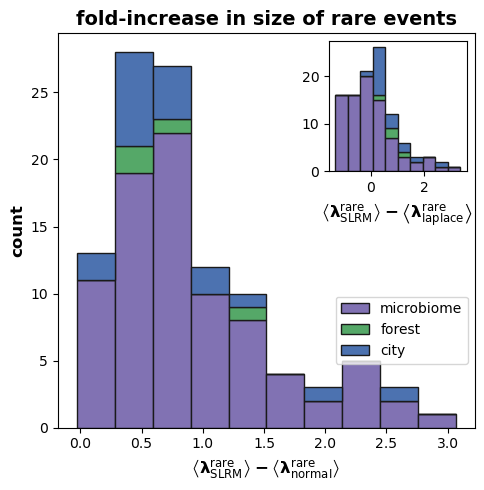

In [57]:
with open(combined_params_path+'microbe_logG_compare_dists.pkl', 'rb') as handle:
    microbe_logG_compare_dists=pickle.load( handle)  

with open(combined_params_path+'city_logG_compare_dists.pkl', 'rb') as handle:
    city_logG_compare_dists=pickle.load( handle) 
     
with open(combined_params_path+'BCI_rel_logG_compare_dists.pkl', 'rb') as handle:
    BCI_logG_compare_dists=pickle.load( handle) 
    
    
def expected_value(func,lb,*args, **kwargs):   
    a=scipy.integrate.quad(
        lambda x: x*func(x,*args, **kwargs), lb,100)
    b=scipy.integrate.quad(
        lambda x: 1*func(x,*args, **kwargs), lb,100)
    if a[1] >1e-6 or b[1]>1e-6:
        print ('error threshold',a[1],b[1])
        print( func)   
    return a[0]/b[0]


pctile_score_microbe=.01
pctile_score_BCI=.01
pctile_score_city=.001

lambda_SLRM_minus_Laplace_microbes=[]
lambda_SLRM_minus_Normal_microbes=[]
expected_lambda_SLRM_minus_Laplace_microbes=[]
expected_lambda_SLRM_minus_Normal_microbes=[]

lambda_SLRM_minus_Laplace_BCI=[]
lambda_SLRM_minus_Normal_BCI=[]
expected_lambda_SLRM_minus_Laplace_BCI=[]
expected_lambda_SLRM_minus_Normal_BCI=[]


lambda_SLRM_minus_Laplace_cities=[]
lambda_SLRM_minus_Normal_cities=[]
expected_lambda_SLRM_minus_Laplace_cities=[]
expected_lambda_SLRM_minus_Normal_cities=[]

## expectation calculated by integration upto lambda =100 for numerical stability

genus_names_full=caporaso['gtax']
tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)

rel_abu_mat=rel_abu_t_mat_full[sp_idx]
genus_names_list=genus_names_full[sp_idx]
idx_1_list=[]
idx_2_list=[]
for j,t2 in enumerate(time_points):
    if np.any(time_points==t2-tau):
        i=int(np.where(time_points==t2-tau)[0])
        t1=time_points[i]
#         print (i,j, t1, t2)
        idx_1_list.append(i)
        idx_2_list.append(j)
idxs_1=np.array(idx_1_list)
idxs_2=np.array(idx_2_list)

sp_list=np.arange(len(rel_abu_mat))
for i,sp in enumerate(sp_list):
    
    otu_t2=np.ravel(rel_abu_mat[sp,idxs_2])
    otu_t1=np.ravel(rel_abu_mat[sp,idxs_1])
    idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
    growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
    logG=np.log(growth_rates)  
    
    row=int(np.where(microbe_logG_compare_dists['sp']==sp)[0])
    neut_tp=microbe_logG_compare_dists['tp_fit'][row]
    neut_bd=microbe_logG_compare_dists['bd_fit'][row]
#     if sp in [0,12,31]:
#         neut_tp_true, neut_bd_true, loc_neut, scale_neut = neutral_inst.fit(
#                 logG,10., 1., floc=0,fscale=1.)       
#         print ('comparing saved and current fit.')
#         print (microbe_logG_compare_dists['tp_fit'][row],
#                microbe_logG_compare_dists['bd_fit'][row] )
#         print (neut_tp_true, neut_bd_true)    
    lambda_low_SLRM=neutral_inst.ppf(pctile_score_microbe,neut_tp, neut_bd, loc=0,scale= 1.)
    lambda_high_SLRM=neutral_inst.ppf(1.-pctile_score_microbe, neut_tp, neut_bd,loc=0,scale= 1.)
    
    
    mu, sigma=scipy.stats.norm.fit(logG,floc=0)
    lambda_low_norm=scipy.stats.norm.ppf(pctile_score_microbe, loc=0, scale=sigma)
    lambda_high_norm=scipy.stats.norm.ppf(1.-pctile_score_microbe, loc=0, scale=sigma)

    
    _, scale_laplace=scipy.stats.laplace.fit(logG,floc=0)
    lambda_low_laplace=scipy.stats.laplace.ppf(pctile_score_microbe,loc=0, scale=scale_laplace)
    lambda_high_laplace=scipy.stats.laplace.ppf(1.-pctile_score_microbe, loc=0, scale=scale_laplace) 


    
    lambda_SLRM_minus_Laplace_microbes.append(lambda_high_SLRM-lambda_high_laplace)
    lambda_SLRM_minus_Normal_microbes.append(lambda_high_SLRM-lambda_high_norm)
    
#     expected_lambda_high_SLRM,err=scipy.integrate.quad(lambda x: x*neutral_inst.pdf(x,neut_tp, neut_bd,loc=0,scale= 1.), 
#                     lambda_high_SLRM,100)
#     if err>1e-6: print (err, 'SLRM microbe', neut_tp , neut_bd  )
    
#     expected_lambda_high_norm,err=scipy.integrate.quad(
#         lambda x: x*scipy.stats.norm.pdf(x,loc=0,scale=sigma), lambda_high_norm,100)
#     if err>1e-6: print (err, 'norm microbe', sigma  )
#     expected_lambda_high_laplace,err=scipy.integrate.quad(
#         lambda x: x*scipy.stats.laplace.pdf(x,loc=0,scale=scale_laplace),
#         lambda_high_laplace,100)
#     if err>1e-6: print (err, 'laplace microbe', scale_laplace  )

    expected_lambda_high_SLRM=expected_value(neutral_inst.pdf,
                                             lambda_high_SLRM,neut_tp,neut_bd,loc=0,scale=1)
    expected_lambda_high_norm=expected_value(scipy.stats.norm.pdf,
                                             lambda_high_norm,loc=0,scale=sigma)
    expected_lambda_high_laplace=expected_value(scipy.stats.laplace.pdf,
                                             lambda_high_laplace,loc=0,scale=scale_laplace )
    
    expected_lambda_SLRM_minus_Laplace_microbes.append(expected_lambda_high_SLRM-expected_lambda_high_laplace)
    expected_lambda_SLRM_minus_Normal_microbes.append(expected_lambda_high_SLRM-expected_lambda_high_norm)
    
    
    
for i, clust_id in enumerate(np.arange(1,5)):
    BCI_logG_clusti=get_BCI_clust_logG(df_BCI_rel_clust,clust_id)  
    
    row=int(np.where(BCI_logG_compare_dists['height_cluster']==clust_id)[0])
    neut_tp=BCI_logG_compare_dists['tp_fit'][row]
    neut_bd=BCI_logG_compare_dists['bd_fit'][row]  
    lambda_low_SLRM=neutral_inst.ppf(pctile_score_BCI,neut_tp, neut_bd, loc=0,scale= 1.)
    lambda_high_SLRM=neutral_inst.ppf(1.-pctile_score_BCI, neut_tp, neut_bd,loc=0,scale= 1.)
            
    mu, sigma=scipy.stats.norm.fit(BCI_logG_clusti,floc=0)
    lambda_low_norm=scipy.stats.norm.ppf(pctile_score_BCI, loc=0, scale=sigma)
    lambda_high_norm=scipy.stats.norm.ppf(1.-pctile_score_BCI, loc=0, scale=sigma)
    
    _, scale_laplace=scipy.stats.laplace.fit(BCI_logG_clusti,floc=0)
    lambda_low_laplace=scipy.stats.laplace.ppf(pctile_score_BCI,loc=0, scale=scale_laplace)
    lambda_high_laplace=scipy.stats.laplace.ppf(1.-pctile_score_BCI, loc=0, scale=scale_laplace)   
    
    lambda_SLRM_minus_Laplace_BCI.append(lambda_high_SLRM-lambda_high_laplace)
    lambda_SLRM_minus_Normal_BCI.append(lambda_high_SLRM-lambda_high_norm)
    
    expected_lambda_high_SLRM=expected_value(neutral_inst.pdf,
                                             lambda_high_SLRM,neut_tp,neut_bd,loc=0,scale=1)
    expected_lambda_high_norm=expected_value(scipy.stats.norm.pdf,
                                             lambda_high_norm,loc=0,scale=sigma)
    expected_lambda_high_laplace=expected_value(scipy.stats.laplace.pdf,
                                             lambda_high_laplace,loc=0,scale=scale_laplace )
    expected_lambda_SLRM_minus_Laplace_BCI.append(expected_lambda_high_SLRM-expected_lambda_high_laplace)
    expected_lambda_SLRM_minus_Normal_BCI.append(expected_lambda_high_SLRM-expected_lambda_high_norm)
    

    
    

for i,naics in enumerate(naics_keys_to_plot):
    
    logratio_list=shared_func.get_LogRatio(df_metroF_time, [naics],
                                       time_stamps_likeCBP_list,tau=12)
    emp_logG=np.ravel(logratio_list)
    
    for row,n in enumerate(city_logG_compare_dists['naics']):
        if n==naics: break
#     print (row, city_logG_compare_dists['naics'][row], naics)

    neut_tp=city_logG_compare_dists['tp_fit'][row]
    neut_bd=city_logG_compare_dists['bd_fit'][row]
    lambda_low_SLRM=neutral_inst.ppf(pctile_score_city,neut_tp, neut_bd, loc=0,scale= 1.)
    lambda_high_SLRM=neutral_inst.ppf(1.-pctile_score_city, neut_tp, neut_bd,loc=0,scale= 1.)
            
    mu, sigma=scipy.stats.norm.fit(emp_logG,floc=0)
    lambda_low_norm=scipy.stats.norm.ppf(pctile_score_city, loc=0, scale=sigma)
    lambda_high_norm=scipy.stats.norm.ppf(1.-pctile_score_city, loc=0, scale=sigma)
    
    _, scale_laplace=scipy.stats.laplace.fit(emp_logG,floc=0)
    lambda_low_laplace=scipy.stats.laplace.ppf(pctile_score_city,loc=0, scale=scale_laplace)
    lambda_high_laplace=scipy.stats.laplace.ppf(1.-pctile_score_city, loc=0, scale=scale_laplace)   
    
    lambda_SLRM_minus_Laplace_cities.append(lambda_high_SLRM-lambda_high_laplace)
    lambda_SLRM_minus_Normal_cities.append(lambda_high_SLRM-lambda_high_norm)
    
    expected_lambda_high_SLRM=expected_value(neutral_inst.pdf,
                                             lambda_high_SLRM,neut_tp,neut_bd,loc=0,scale=1)
    expected_lambda_high_norm=expected_value(scipy.stats.norm.pdf,
                                             lambda_high_norm,loc=0,scale=sigma)
    expected_lambda_high_laplace=expected_value(scipy.stats.laplace.pdf,
                                             lambda_high_laplace,loc=0,scale=scale_laplace )
    expected_lambda_SLRM_minus_Laplace_cities.append(expected_lambda_high_SLRM-expected_lambda_high_laplace)
    expected_lambda_SLRM_minus_Normal_cities.append(expected_lambda_high_SLRM-expected_lambda_high_norm)
    
    
    
    
fig = plt.figure(figsize=(5,5))
ax9 = fig.add_subplot()
ax9_inset = ax9.inset_axes([0.65, 0.65, 0.33, 0.33])
    
x_multi=[]
x_multi.append(lambda_SLRM_minus_Normal_microbes)
x_multi.append(lambda_SLRM_minus_Normal_BCI)
x_multi.append(lambda_SLRM_minus_Normal_cities)
ax9.hist(x_multi, histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbiome','forest','city']) 
ax9.set_title('fold-increase in size of rare events')
ax9.set_xlabel(r'$\mathbf{\lambda^{\mathrm{rare}}_{\mathrm{SLRM}} -\lambda^{\mathrm{rare}}_{\mathrm{normal}}}$ ')

x_multi=[]
x_multi.append(lambda_SLRM_minus_Laplace_microbes)
x_multi.append(lambda_SLRM_minus_Laplace_BCI)
x_multi.append(lambda_SLRM_minus_Laplace_cities)
ax9_inset.hist(x_multi, histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbiome','forest','city']) 
ax9_inset.set_xlabel(r'$\mathbf{\lambda^{\mathrm{rare}}_{\mathrm{SLRM}} -\lambda^{\mathrm{rare}}_{\mathrm{laplace}}}$ ')
ax9.set_ylabel('count')
ax9.legend(loc='upper right', bbox_to_anchor=(1, .35))
plt.tight_layout()   


fig2 = plt.figure(figsize=(5,5))
ax9 = fig2.add_subplot()
ax9_inset = ax9.inset_axes([0.65, 0.65, 0.33, 0.33])
    
x_multi=[]
x_multi.append(expected_lambda_SLRM_minus_Normal_microbes)
x_multi.append(expected_lambda_SLRM_minus_Normal_BCI)
x_multi.append(expected_lambda_SLRM_minus_Normal_cities)
ax9.hist(x_multi, histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbiome','forest','city']) 
ax9.set_title('fold-increase in size of rare events')
# ax9.set_xlabel(r'$\mathbf{\langle\lambda^{\mathrm{rare}}_{\mathrm{SLRM}} \rangle - \langle\lambda^{\mathrm{rare}}_{\mathrm{normal}} \rangle}$ ')
ax9.set_xlabel(r'$\mathbf{\left \langle\lambda^{\mathrm{rare}}_{\mathrm{SLRM}} \right \rangle - \left \langle\lambda^{\mathrm{rare}}_{\mathrm{normal}} \right \rangle}$ ')


x_multi=[]
x_multi.append(expected_lambda_SLRM_minus_Laplace_microbes)
x_multi.append(expected_lambda_SLRM_minus_Laplace_BCI)
x_multi.append(expected_lambda_SLRM_minus_Laplace_cities)
ax9_inset.hist(x_multi, histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbiome','forest','city']) 
# ax9_inset.set_xlabel(r'$ \mathbf{\langle\lambda^{\mathrm{rare}}_{\mathrm{SLRM}} \rangle - \langle\lambda^{\mathrm{rare}}_{\mathrm{laplace}} \rangle}$ ')
ax9_inset.set_xlabel(r'$ \mathbf{\left \langle\lambda^{\mathrm{rare}}_{\mathrm{SLRM}} \right \rangle - \left \langle\lambda^{\mathrm{rare}}_{\mathrm{laplace}}\right \rangle} $ ')
ax9.set_ylabel('count')
ax9.legend(loc='upper right', bbox_to_anchor=(1, .35))
plt.tight_layout()   



plt.show()

1.0384716280695518 0.48502561155225377


In [40]:
a=scipy.integrate.quad(lambda x: x*neutral_inst.pdf(x,neut_tp, neut_bd,loc=0,scale= 1.), 
                    lambda_high_SLRM,100)
b=scipy.integrate.quad(lambda x: 1*neutral_inst.pdf(x,neut_tp, neut_bd,loc=0,scale= 1.), 
                    lambda_high_SLRM,100)

In [42]:
a[0]/b[0]

1.5278298598039555

In [32]:

expected_lambda_SLRM_minus_Normal_cities

[]

##### alternate plots testing.

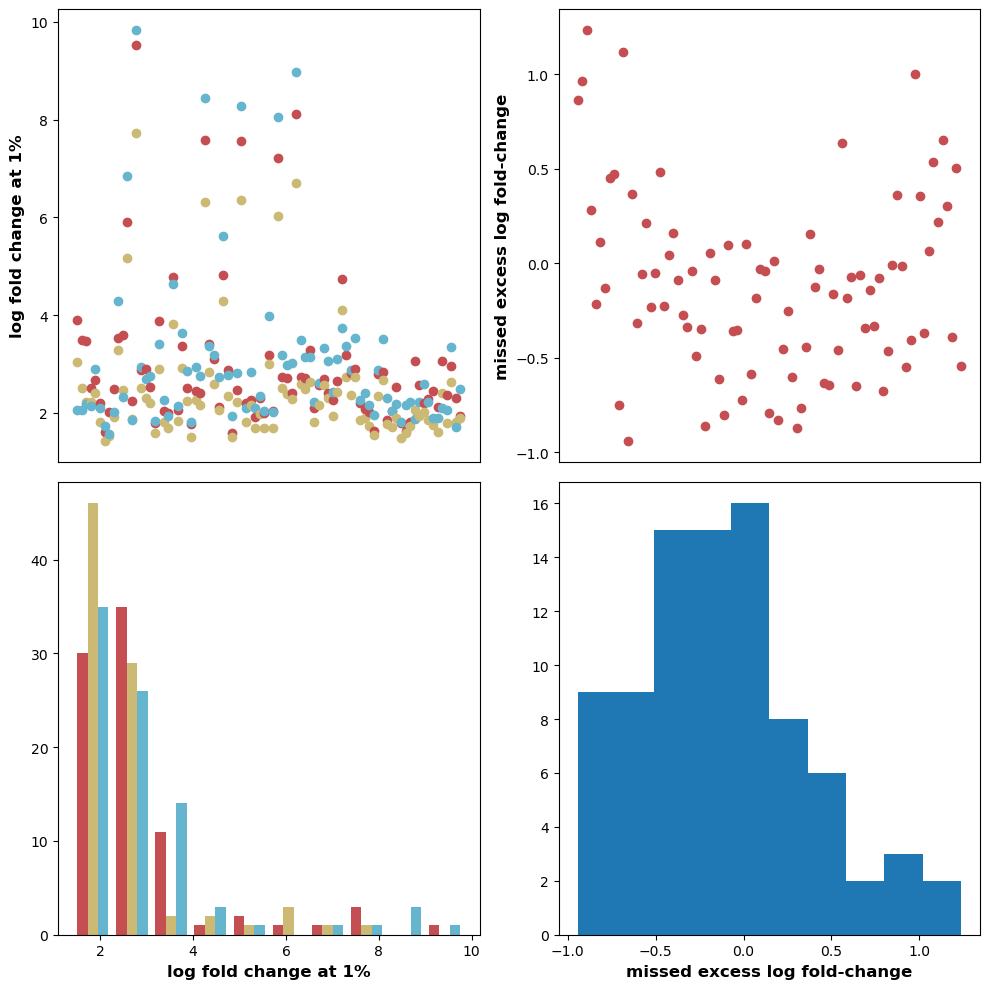

In [29]:
with open(combined_params_path+'microbe_logG_compare_dists.pkl', 'rb') as handle:
    microbe_logG_compare_dists=pickle.load( handle)  

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
pctile_score=.01
genus_names_full=caporaso['gtax']
tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)

rel_abu_mat=rel_abu_t_mat_full[sp_idx]
genus_names_list=genus_names_full[sp_idx]
idx_1_list=[]
idx_2_list=[]
for j,t2 in enumerate(time_points):
    if np.any(time_points==t2-tau):
        i=int(np.where(time_points==t2-tau)[0])
        t1=time_points[i]
#         print (i,j, t1, t2)
        idx_1_list.append(i)
        idx_2_list.append(j)
idxs_1=np.array(idx_1_list)
idxs_2=np.array(idx_2_list)
lambda_high_SLRM_list=[]
lambda_high_norm_list=[]
lambda_high_laplace_list=[]
lambda_excess_list=[]
sp_list=np.arange(len(rel_abu_mat))
for i,sp in enumerate(sp_list):
    
    otu_t2=np.ravel(rel_abu_mat[sp,idxs_2])
    otu_t1=np.ravel(rel_abu_mat[sp,idxs_1])
    idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
    growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
    logG=np.log(growth_rates)  
    
    row=int(np.where(microbe_logG_compare_dists['sp']==sp)[0])
    neut_tp=microbe_logG_compare_dists['tp_fit'][row]
    neut_bd=microbe_logG_compare_dists['bd_fit'][row]
#     if sp in [0,12,31]:
#         neut_tp_true, neut_bd_true, loc_neut, scale_neut = neutral_inst.fit(
#                 logG,10., 1., floc=0,fscale=1.)       
#         print ('comparing saved and current fit.')
#         print (microbe_logG_compare_dists['tp_fit'][row],
#                microbe_logG_compare_dists['bd_fit'][row] )
#         print (neut_tp_true, neut_bd_true)
    
    lambda_low_SLRM=neutral_inst.ppf(pctile_score,neut_tp, neut_bd, loc=0,scale= 1.)
    lambda_high_SLRM=neutral_inst.ppf(1.-pctile_score, neut_tp, neut_bd,loc=0,scale= 1.)
            
    mu, sigma=scipy.stats.norm.fit(logG,floc=0)
    lambda_low_norm=scipy.stats.norm.ppf(pctile_score, loc=0, scale=sigma)
    lambda_high_norm=scipy.stats.norm.ppf(1.-pctile_score, loc=0, scale=sigma)
    
    _, scale_laplace=scipy.stats.laplace.fit(logG,floc=0)
    lambda_low_laplace=scipy.stats.laplace.ppf(pctile_score,loc=0, scale=scale_laplace)
    lambda_high_laplace=scipy.stats.laplace.ppf(1.-pctile_score, loc=0, scale=scale_laplace)
    
    lambda_high_SLRM_list.append(lambda_high_SLRM)
    lambda_high_laplace_list.append(lambda_high_laplace)
    lambda_high_norm_list.append(lambda_high_norm)
    
    ax1.scatter(i,lambda_high_SLRM, color='r')
    ax1.scatter(i,lambda_high_norm, color='y')
    ax1.scatter(i,lambda_high_laplace, color='c')    
    ax1.set_ylabel('log fold change at 1%')
    ax1.set_xticks([])
    
    
    excess=lambda_high_SLRM-max(lambda_high_norm,lambda_high_laplace)
    lambda_excess_list.append(excess)
    ax2.scatter(i,excess, color='r')
    ax2.set_ylabel('missed excess log fold-change')
    ax2.set_xticks([])
    
    
# ax3.hist(lambda_high_SLRM_list,color='r',alpha=.4)    
# ax3.hist(lambda_high_norm_list,color='y',alpha=.4)    
# ax3.hist(lambda_high_laplace_list,color='c',alpha=.4)   

ax3.hist([lambda_high_SLRM_list,lambda_high_norm_list,lambda_high_laplace_list],
         color=['r','y','c'])
ax3.set_xlabel('log fold change at 1%')

ax4.hist(lambda_excess_list)   
ax4.set_xlabel('missed excess log fold-change')    
    
plt.tight_layout()   
plt.show()

In [7]:
microbe_logG_compare_dists.keys()

dict_keys(['sp', 'tp_fit', 'bd_fit', 'data_length', 'logLk', 'll_normal_list', 'll_Laplace_list', 'll_normal_list_non0mean', 'll_Laplace_list_non0mean', 'ctr_list', 'ctr_names', 'best_dist_list', 'ctr_list_onlymean0', 'ctr_names_onlymean0'])

In [3]:
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_fluctuation_intervals/'
is_rel_abundances=True
neutral_inst = shared_func.azaele_neutral_logG_distribution()
microbe_div_time=.175 ## 5.7 divisions per day
forest_div_time=55## 55 years
city_div_time=10 ## 10 years
# Delta_t=12  
with open(combined_params_path+'city_logG_fit_and_simvals.pkl', 'rb') as handle:
    city_logG_df=pd.DataFrame(pickle.load(handle)  )
city_mD_vals=  city_logG_df['bd_fit'].values
city_tau_vals= 1./city_logG_df['tp_fit'].values
city_rescaled_tau_divs=city_tau_vals/city_div_time
city_rescaled_tau_obs=city_tau_vals/17

with open(combined_params_path+'microbe_logG_fit_and_simvals.pkl', 'rb') as handle:
    microbe_logG_df=pd.DataFrame(pickle.load(handle)  )
microbe_mD_vals=  microbe_logG_df['bd_fit'].values
microbe_tau_vals= 1./microbe_logG_df['tp_fit'].values
microbe_rescaled_tau_divs=microbe_tau_vals/microbe_div_time ##5 divs per day
microbe_rescaled_tau_obs=microbe_tau_vals/300 ## by observation timescale

if is_rel_abundances:
    with open(combined_params_path+'BCI_rel_logG_clustfit_and_simvals.pkl', 'rb') as handle:
        BCI_ll_dict=pickle.load(handle)  
        del BCI_ll_dict['sp'] ## empty column prevents converting to dataframe
        BCIclust_logG_df=pd.DataFrame(BCI_ll_dict)
else:
    with open(combined_params_path+'BCI_logG_clustfit_and_simvals.pkl', 'rb') as handle:
        BCI_ll_dict=pickle.load(handle)  
        del BCI_ll_dict['sp'] ## empty column prevents converting to dataframe
        BCIclust_logG_df=pd.DataFrame(BCI_ll_dict)
BCIclust_mD_vals=  BCIclust_logG_df['bd_fit'].values
BCIclust_tau_vals= 5./BCIclust_logG_df['tp_fit'].values ## Delta t =5 years!
BCI_rescaled_tau_divs=BCIclust_tau_vals/forest_div_time# # assuming 100 year lifetime of a tree
BCI_rescaled_tau_obs=BCIclust_tau_vals/20

#### old params files
# city_fit_params_path='/Users/ashish/Box/research/James/BLS data/processed_BLS_data/fit_parameters/'
# with open(city_fit_params_path+'log_growth_F_fitvals-Delta_t'+str(Delta_t)+'.pkl', 'rb') as handle:
#     logG_F_fitvals = pickle.load(handle)
# city_mD_vals=  np.array(logG_F_fitvals ['NeutralTheory'])[:,1]
# city_tau_vals= 1./np.array(logG_F_fitvals ['NeutralTheory'])[:,0]
# microbiome_fit_fold='/Users/ashish/Box/research/James/microbiome data/microbiome_fits/'
# Delta_t=1  
# with open(microbiome_fit_fold+'fit_AFD_with_logG_K-fitvals-tau_'+str(Delta_t)+'.pkl', 'rb') as handle:
#     microbe_fit_vals = pickle.load(handle)  
# microbe_mD_vals=  microbe_fit_vals['m/D_logG']
# microbe_tau_vals= Delta_t/np.array(microbe_fit_vals['tau'] )  
# Delta_t=5
# BCI_fit_params_path='/Users/ashish/Box/research/James/BCI data/processed_BCI_data/fit_parameters/'
# with open(BCI_fit_params_path+'fit_logG_-fitvals.pkl', 'rb') as handle:
#     BCI_fit_vals_logG = pickle.load(handle)
# BCI_mD_vals=BCI_fit_vals_logG ['m/D_logG']
# BCI_logG_tau=Delta_t/BCI_fit_vals_logG ['tp']





# fig2 = plt.figure(figsize=(8, 4))
# ax1 = fig2.add_subplot(1,2,2)

# ax1.plot(microbe_rescaled_tau_divs,microbe_mD_vals,'m^')
# ax1.plot(city_rescaled_tau_divs,city_mD_vals,'bo')
# ax1.plot(BCI_rescaled_tau_divs,BCIclust_mD_vals,'g*', ms=10)
# ax1.set_xlabel(r'eq. time-scale/generation time, $\tau /t_{gen}$')
# ax1.set_ylabel('immigration to noise')
# ax1.set_xscale('log')
# ax1.set_yscale('log')
# ax1.set_ylim(1e-1, 10)
# ax1.set_xlim(1e-1, 1000)
# ax1.text(-0.15,1.05,'B',fontweight="bold",transform=ax1.transAxes,fontsize=MEDIUM_SIZE)

# ax2 = fig2.add_subplot(1,2,1)
# ax2.loglog(microbe_rescaled_tau_obs,microbe_mD_vals,'m^',label='microbe')
# ax2.loglog(city_rescaled_tau_obs,city_mD_vals,'bo',label='urban')
# ax2.loglog(BCI_rescaled_tau_obs,BCIclust_mD_vals,'g*',label='forest')
# ax2.legend(loc=3)
# ax2.set_xlabel(r'eq. time-scale/observation time, $\tau /t_{obs}$')
# ax2.set_ylabel('immigration to noise')
# ax2.set_ylim(1e-1, 10)
# ax2.set_xlim(1e-5, 1000)
# ax2.axvspan(ax2.get_xlim()[0],1, color='y', alpha=0.4, lw=0)
# ax2.axvspan(1, ax2.get_xlim()[1], color='r', alpha=0.4, lw=0)
# ax2.text(-0.15,1.05,'A',fontweight="bold",transform=ax2.transAxes,fontsize=MEDIUM_SIZE)
# fig2.tight_layout()

# if is_rel_abundances:
#     plt.savefig(dest_path+'phase_dig_2panel.png')
#     plt.savefig(dest_path+'phase_dig_2panel.pdf')
# else:
#     plt.savefig(dest_path+'phase_dig_2panel_abs.png')
# plt.show()

In [4]:
microbe_logG_df

sp     tp_fit    bd_fit  data_length       logLk  \
0    0   0.008802  0.481262          277 -224.078376   
1    1   0.017497  0.562214          275 -252.933504   
2    2   0.029288  0.611102          273 -287.873408   
3    3   0.083868  0.931739          273 -285.062562   
4    4   0.409789  1.336315          241 -329.548388   
..  ..        ...       ...          ...         ...   
80  80   0.033763  0.674554          275 -271.631599   
81  81   0.106165  1.030795          260 -275.865302   
82  82   0.824013  1.437466          245 -374.357682   
83  83   0.034351  0.802002          273 -219.883142   
84  84  25.432194  3.502266          244 -295.171913   

                                           logLk_sims  
0   [-228.92866490651912, -213.30507347454827, -24...  
1   [-246.60455713056257, -221.03008979429012, -21...  
2   [-301.05326088077715, -268.06437694128175, -27...  
3   [-313.0403683607791, -274.52646620930665, -326...  
4   [-359.12040662480496, -341.73653499546987, -33...  
..                                                ...  
80  [-292.8926235554344, -269.24375207205657, -303...  
81  [-256.9235865718937, -258.04605232132064, -278...  
82  [-380.05017339589847, -371.5830156565137, -404...  
83  [-221.74860137761726, -225.28187966836373, -21...  
84  [-293.99600677783553, -308.30874604559966, -30...  

[85 rows x 6 columns]

# distribution of inferred parameters

## logG params phase plot

### 2 panel phase plot

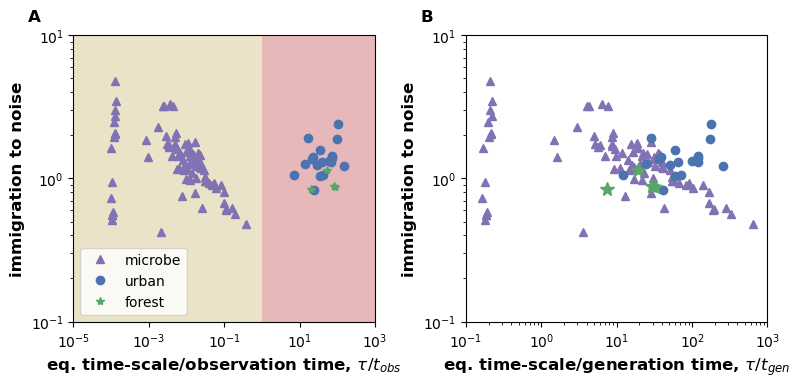

In [32]:
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_distribution_fit_params/'
is_rel_abundances=True

microbe_div_time=.175 ## 5.7 divisions per day
forest_div_time=55## 55 years
city_div_time=10 ## 10 years
# Delta_t=12  
with open(combined_params_path+'city_logG_fit_and_simvals.pkl', 'rb') as handle:
    city_logG_df=pd.DataFrame(pickle.load(handle)  )
city_mD_vals=  city_logG_df['bd_fit'].values
city_tau_vals= 1./city_logG_df['tp_fit'].values
city_rescaled_tau_divs=city_tau_vals/city_div_time
city_rescaled_tau_obs=city_tau_vals/17
with open(combined_params_path+'microbe_logG_fit_and_simvals.pkl', 'rb') as handle:
    microbe_logG_df=pd.DataFrame(pickle.load(handle)  )
microbe_mD_vals=  microbe_logG_df['bd_fit'].values
microbe_tau_vals= 1./microbe_logG_df['tp_fit'].values
microbe_rescaled_tau_divs=microbe_tau_vals/microbe_div_time ##5 divs per day
microbe_rescaled_tau_obs=microbe_tau_vals/300 ## by observation timescale

if is_rel_abundances:
    with open(combined_params_path+'BCI_rel_logG_clustfit_and_simvals.pkl', 'rb') as handle:
        BCI_ll_dict=pickle.load(handle)  
        del BCI_ll_dict['sp'] ## empty column prevents converting to dataframe
        BCIclust_logG_df=pd.DataFrame(BCI_ll_dict)
else:
    with open(combined_params_path+'BCI_logG_clustfit_and_simvals.pkl', 'rb') as handle:
        BCI_ll_dict=pickle.load(handle)  
        del BCI_ll_dict['sp'] ## empty column prevents converting to dataframe
        BCIclust_logG_df=pd.DataFrame(BCI_ll_dict)
BCIclust_mD_vals=  BCIclust_logG_df['bd_fit'].values
BCIclust_tau_vals= 5./BCIclust_logG_df['tp_fit'].values ## Delta t =5 years!
BCI_rescaled_tau_divs=BCIclust_tau_vals/forest_div_time# # assuming 100 year lifetime of a tree
BCI_rescaled_tau_obs=BCIclust_tau_vals/20

#### old params files
# city_fit_params_path='/Users/ashish/Box/research/James/BLS data/processed_BLS_data/fit_parameters/'
# with open(city_fit_params_path+'log_growth_F_fitvals-Delta_t'+str(Delta_t)+'.pkl', 'rb') as handle:
#     logG_F_fitvals = pickle.load(handle)
# city_mD_vals=  np.array(logG_F_fitvals ['NeutralTheory'])[:,1]
# city_tau_vals= 1./np.array(logG_F_fitvals ['NeutralTheory'])[:,0]
# microbiome_fit_fold='/Users/ashish/Box/research/James/microbiome data/microbiome_fits/'
# Delta_t=1  
# with open(microbiome_fit_fold+'fit_AFD_with_logG_K-fitvals-tau_'+str(Delta_t)+'.pkl', 'rb') as handle:
#     microbe_fit_vals = pickle.load(handle)  
# microbe_mD_vals=  microbe_fit_vals['m/D_logG']
# microbe_tau_vals= Delta_t/np.array(microbe_fit_vals['tau'] )  
# Delta_t=5
# BCI_fit_params_path='/Users/ashish/Box/research/James/BCI data/processed_BCI_data/fit_parameters/'
# with open(BCI_fit_params_path+'fit_logG_-fitvals.pkl', 'rb') as handle:
#     BCI_fit_vals_logG = pickle.load(handle)
# BCI_mD_vals=BCI_fit_vals_logG ['m/D_logG']
# BCI_logG_tau=Delta_t/BCI_fit_vals_logG ['tp']





fig2 = plt.figure(figsize=(8, 4))
ax1 = fig2.add_subplot(1,2,2)

ax1.plot(microbe_rescaled_tau_divs,microbe_mD_vals,'m^')
ax1.plot(city_rescaled_tau_divs,city_mD_vals,'bo')
ax1.plot(BCI_rescaled_tau_divs,BCIclust_mD_vals,'g*', ms=10)
ax1.set_xlabel(r'eq. time-scale/generation time, $\tau /t_{gen}$')
ax1.set_ylabel('immigration to noise')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(1e-1, 10)
ax1.set_xlim(1e-1, 1000)
ax1.text(-0.15,1.05,'B',fontweight="bold",transform=ax1.transAxes,fontsize=MEDIUM_SIZE)

ax2 = fig2.add_subplot(1,2,1)
ax2.loglog(microbe_rescaled_tau_obs,microbe_mD_vals,'m^',label='microbe')
ax2.loglog(city_rescaled_tau_obs,city_mD_vals,'bo',label='urban')
ax2.loglog(BCI_rescaled_tau_obs,BCIclust_mD_vals,'g*',label='forest')
ax2.legend(loc=3)
ax2.set_xlabel(r'eq. time-scale/observation time, $\tau /t_{obs}$')
ax2.set_ylabel('immigration to noise')
ax2.set_ylim(1e-1, 10)
ax2.set_xlim(1e-5, 1000)
ax2.axvspan(ax2.get_xlim()[0],1, color='y', alpha=0.4, lw=0)
ax2.axvspan(1, ax2.get_xlim()[1], color='r', alpha=0.4, lw=0)
ax2.text(-0.15,1.05,'A',fontweight="bold",transform=ax2.transAxes,fontsize=MEDIUM_SIZE)
fig2.tight_layout()

if is_rel_abundances:
    plt.savefig(dest_path+'phase_dig_2panel.png')
    plt.savefig(dest_path+'phase_dig_2panel.pdf')
else:
    plt.savefig(dest_path+'phase_dig_2panel_abs.png')
plt.show()

##### old, for single BCI data(neutral)

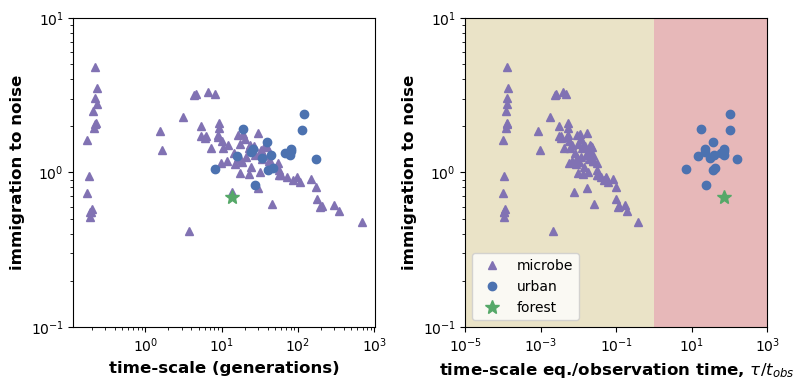

In [6]:
city_fit_params_path='/Users/ashish/Box/research/James/BLS data/processed_BLS_data/fit_parameters/'
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_distribution_fit_params/'
Delta_t=12
with open(city_fit_params_path+'log_growth_F_fitvals-Delta_t'+str(Delta_t)+'.pkl', 'rb') as handle:
    logG_F_fitvals = pickle.load(handle)
    
city_mD_vals=  np.array(logG_F_fitvals ['NeutralTheory'])[:,1]
city_tau_vals= 1./np.array(logG_F_fitvals ['NeutralTheory'])[:,0]
city_rescaled_tau_divs=city_tau_vals/15
city_rescaled_tau_obs=city_tau_vals/17
microbiome_fit_fold='/Users/ashish/Box/research/James/microbiome data/microbiome_fits/'
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_distribution_fit_params/'
Delta_t=1  
with open(microbiome_fit_fold+'fit_AFD_with_logG_K-fitvals-tau_'+str(Delta_t)+'.pkl', 'rb') as handle:
    microbe_fit_vals = pickle.load(handle)
    
microbe_mD_vals=  microbe_fit_vals['m/D_logG']
microbe_tau_vals= Delta_t/np.array(microbe_fit_vals['tau'] )  
microbe_rescaled_tau_divs=microbe_tau_vals*6 ## by number of divisions
microbe_rescaled_tau_obs=microbe_tau_vals/300 ## by observation timescale

Delta_t=5
BCI_fit_params_path='/Users/ashish/Box/research/James/BCI data/processed_BCI_data/fit_parameters/'
with open(BCI_fit_params_path+'fit_logG_-fitvals.pkl', 'rb') as handle:
    BCI_fit_vals_logG = pickle.load(handle)
BCI_mD_vals=BCI_fit_vals_logG ['m/D_logG']
BCI_logG_tau=Delta_t/BCI_fit_vals_logG ['tp']

BCI_rescaled_tau_divs=BCI_logG_tau/100 ## assuming 100 year lifetime of a tree
BCI_rescaled_tau_obs=BCI_logG_tau/20


# fig = plt.figure(figsize=(8, 4))
# ax1 = fig.add_subplot(1,2,1)
# ax1.plot(microbe_mD_vals,microbe_rescaled_tau_divs,'mo')
# ax1.plot(city_mD_vals,city_rescaled_tau_divs,'bo')
# ax1.set_ylabel('time-scale (divisions)')
# ax1.set_xlabel('immigration to noise')

# ax2 = fig.add_subplot(1,2,2)
# ax2.loglog(microbe_mD_vals,microbe_rescaled_tau_obs,'mo')
# ax2.loglog(city_mD_vals,city_rescaled_tau_obs,'bo')
# ax2.set_ylabel('time-scale eq./ time of observation')
# ax2.set_xlabel('immigration to noise')

# fig.tight_layout()
# plt.show()


fig2 = plt.figure(figsize=(8, 4))
ax1 = fig2.add_subplot(1,2,1)

ax1.plot(microbe_rescaled_tau_divs,microbe_mD_vals,'m^')
ax1.plot(city_rescaled_tau_divs,city_mD_vals,'bo')
ax1.plot(BCI_rescaled_tau_divs,BCI_mD_vals,'g*', ms=10)
ax1.set_xlabel('time-scale (generations)')
ax1.set_ylabel('immigration to noise')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(1e-1, 10)

ax2 = fig2.add_subplot(1,2,2)
ax2.loglog(microbe_rescaled_tau_obs,microbe_mD_vals,'m^',label='microbe')
ax2.loglog(city_rescaled_tau_obs,city_mD_vals,'bo',label='urban')
ax2.loglog(BCI_rescaled_tau_obs,BCI_mD_vals,'g*', ms=10,label='forest')
ax2.legend(loc=3)
ax2.set_xlabel(r'time-scale eq./observation time, $\tau /t_{obs}$')
ax2.set_ylabel('immigration to noise')
ax2.set_ylim(1e-1, 10)
ax2.set_xlim(1e-5, 1000)
ax2.axvspan(ax2.get_xlim()[0],1, color='y', alpha=0.4, lw=0)
ax2.axvspan(1, ax2.get_xlim()[1], color='r', alpha=0.4, lw=0)
fig2.tight_layout()

plt.savefig(dest_path+'phase_dig_2panel.png')
plt.show()

## phase plot + histogram

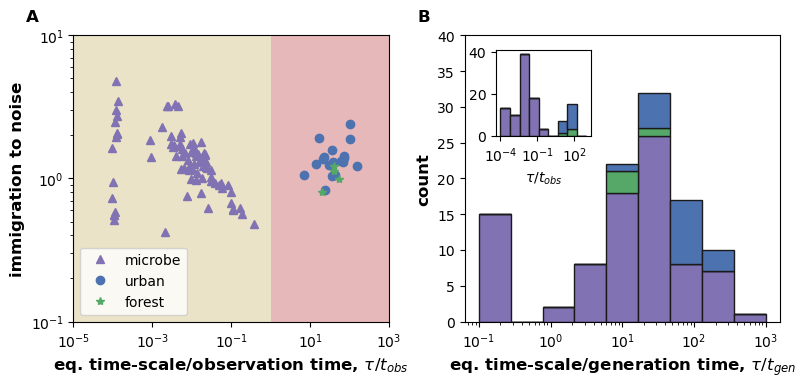

In [245]:
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_distribution_fit_params/'
microbe_div_time=.175 ## 5.7 divisions per day
forest_div_time=55## 55 years
city_div_time=10 ## 10 years
# Delta_t=12  
with open(combined_params_path+'city_logG_fit_and_simvals.pkl', 'rb') as handle:
    city_logG_df=pd.DataFrame(pickle.load(handle)  )
city_mD_vals=  city_logG_df['bd_fit'].values
city_tau_vals= 1./city_logG_df['tp_fit'].values
city_rescaled_tau_divs=city_tau_vals/city_div_time
city_rescaled_tau_obs=city_tau_vals/17
with open(combined_params_path+'microbe_logG_fit_and_simvals.pkl', 'rb') as handle:
    microbe_logG_df=pd.DataFrame(pickle.load(handle)  )
microbe_mD_vals=  microbe_logG_df['bd_fit'].values
microbe_tau_vals= 1./microbe_logG_df['tp_fit'].values
microbe_rescaled_tau_divs=microbe_tau_vals/microbe_div_time ##5 divs per day
microbe_rescaled_tau_obs=microbe_tau_vals/300 ## by observation timescale

with open(combined_params_path+'BCI_logG_clustfit_and_simvals.pkl', 'rb') as handle:
    BCI_ll_dict=pickle.load(handle)  
    del BCI_ll_dict['sp'] ## empty column prevents converting to dataframe
    BCIclust_logG_df=pd.DataFrame(BCI_ll_dict)
BCIclust_mD_vals=  BCIclust_logG_df['bd_fit'].values
BCIclust_tau_vals= 5./BCIclust_logG_df['tp_fit'].values ## Delta t =5 years!
BCI_rescaled_tau_divs=BCIclust_tau_vals/forest_div_time# # assuming 100 year lifetime of a tree
BCI_rescaled_tau_obs=BCIclust_tau_vals/20

#### old params files
# city_fit_params_path='/Users/ashish/Box/research/James/BLS data/processed_BLS_data/fit_parameters/'
# with open(city_fit_params_path+'log_growth_F_fitvals-Delta_t'+str(Delta_t)+'.pkl', 'rb') as handle:
#     logG_F_fitvals = pickle.load(handle)
# city_mD_vals=  np.array(logG_F_fitvals ['NeutralTheory'])[:,1]
# city_tau_vals= 1./np.array(logG_F_fitvals ['NeutralTheory'])[:,0]
# microbiome_fit_fold='/Users/ashish/Box/research/James/microbiome data/microbiome_fits/'
# Delta_t=1  
# with open(microbiome_fit_fold+'fit_AFD_with_logG_K-fitvals-tau_'+str(Delta_t)+'.pkl', 'rb') as handle:
#     microbe_fit_vals = pickle.load(handle)  
# microbe_mD_vals=  microbe_fit_vals['m/D_logG']
# microbe_tau_vals= Delta_t/np.array(microbe_fit_vals['tau'] )  
# Delta_t=5
# BCI_fit_params_path='/Users/ashish/Box/research/James/BCI data/processed_BCI_data/fit_parameters/'
# with open(BCI_fit_params_path+'fit_logG_-fitvals.pkl', 'rb') as handle:
#     BCI_fit_vals_logG = pickle.load(handle)
# BCI_mD_vals=BCI_fit_vals_logG ['m/D_logG']
# BCI_logG_tau=Delta_t/BCI_fit_vals_logG ['tp']





fig2 = plt.figure(figsize=(8, 4))
ax1 = fig2.add_subplot(1,2,2)


x_multi=[]
x_multi.append(microbe_rescaled_tau_divs)
x_multi.append(BCI_rescaled_tau_divs)
x_multi.append(city_rescaled_tau_divs)
ax1.hist(x_multi, bins=np.logspace(-1,3,10) , histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbiome','forest','city'])

ax1.set_xlabel(r'eq. time-scale/generation time, $\tau /t_{gen}$')
ax1.set_ylabel('count')
ax1.set_xscale('log')
ax1.set_ylim(0, 40)
ax1.text(-0.15,1.05,'B',fontweight="bold",transform=ax1.transAxes,fontsize=MEDIUM_SIZE)

ax1_inset = ax1.inset_axes([0.1, 0.65, 0.3, 0.3])
x_multi=[]
x_multi.append(microbe_rescaled_tau_obs)
x_multi.append(BCI_rescaled_tau_obs)
x_multi.append(city_rescaled_tau_obs)
ax1_inset.hist(x_multi, bins=np.logspace(-4,3,10) , histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbiome','forest','city'])
ax1_inset.set_xlabel(r'$\tau /t_{obs}$',fontsize=SMALL_SIZE)
# ax1_inset.set_ylabel('count')
ax1_inset.set_xscale('log')
ax1_inset.set_xticks([1e-4, 1e-1, 1e2])
# ax1.set_yscale('log')
# 


ax2 = fig2.add_subplot(1,2,1)
ax2.loglog(microbe_rescaled_tau_obs,microbe_mD_vals,'m^',label='microbe')
ax2.loglog(city_rescaled_tau_obs,city_mD_vals,'bo',label='urban')
ax2.loglog(BCI_rescaled_tau_obs,BCIclust_mD_vals,'g*',label='forest')
ax2.legend(loc=3)
ax2.set_xlabel(r'eq. time-scale/observation time, $\tau /t_{obs}$')
ax2.set_ylabel('immigration to noise')
ax2.set_ylim(1e-1, 10)
ax2.set_xlim(1e-5, 1000)
ax2.axvspan(ax2.get_xlim()[0],1, color='y', alpha=0.4, lw=0)
ax2.axvspan(1, ax2.get_xlim()[1], color='r', alpha=0.4, lw=0)
ax2.text(-0.15,1.05,'A',fontweight="bold",transform=ax2.transAxes,fontsize=MEDIUM_SIZE)
fig2.tight_layout()

plt.savefig(dest_path+'phase_dig+histogram_inset.png')
plt.show()

### gridspec 2 horizontal panel

/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


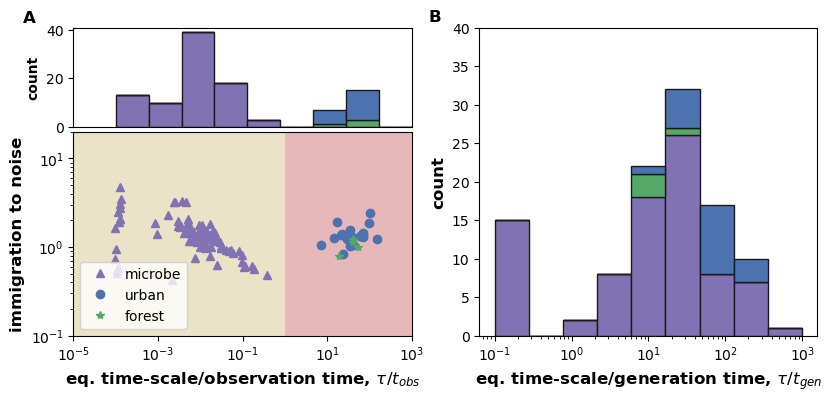

In [260]:
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_distribution_fit_params/'
microbe_div_time=.175 ## 5.7 divisions per day
forest_div_time=55## 55 years
city_div_time=10 ## 10 years
# Delta_t=12  
with open(combined_params_path+'city_logG_fit_and_simvals.pkl', 'rb') as handle:
    city_logG_df=pd.DataFrame(pickle.load(handle)  )
city_mD_vals=  city_logG_df['bd_fit'].values
city_tau_vals= 1./city_logG_df['tp_fit'].values
city_rescaled_tau_divs=city_tau_vals/city_div_time
city_rescaled_tau_obs=city_tau_vals/17
with open(combined_params_path+'microbe_logG_fit_and_simvals.pkl', 'rb') as handle:
    microbe_logG_df=pd.DataFrame(pickle.load(handle)  )
microbe_mD_vals=  microbe_logG_df['bd_fit'].values
microbe_tau_vals= 1./microbe_logG_df['tp_fit'].values
microbe_rescaled_tau_divs=microbe_tau_vals/microbe_div_time ##5 divs per day
microbe_rescaled_tau_obs=microbe_tau_vals/300 ## by observation timescale

with open(combined_params_path+'BCI_logG_clustfit_and_simvals.pkl', 'rb') as handle:
    BCI_ll_dict=pickle.load(handle)  
    del BCI_ll_dict['sp'] ## empty column prevents converting to dataframe
    BCIclust_logG_df=pd.DataFrame(BCI_ll_dict)
BCIclust_mD_vals=  BCIclust_logG_df['bd_fit'].values
BCIclust_tau_vals= 5./BCIclust_logG_df['tp_fit'].values ## Delta t =5 years!
BCI_rescaled_tau_divs=BCIclust_tau_vals/forest_div_time# # assuming 100 year lifetime of a tree
BCI_rescaled_tau_obs=BCIclust_tau_vals/20

#### old params files
# city_fit_params_path='/Users/ashish/Box/research/James/BLS data/processed_BLS_data/fit_parameters/'
# with open(city_fit_params_path+'log_growth_F_fitvals-Delta_t'+str(Delta_t)+'.pkl', 'rb') as handle:
#     logG_F_fitvals = pickle.load(handle)
# city_mD_vals=  np.array(logG_F_fitvals ['NeutralTheory'])[:,1]
# city_tau_vals= 1./np.array(logG_F_fitvals ['NeutralTheory'])[:,0]
# microbiome_fit_fold='/Users/ashish/Box/research/James/microbiome data/microbiome_fits/'
# Delta_t=1  
# with open(microbiome_fit_fold+'fit_AFD_with_logG_K-fitvals-tau_'+str(Delta_t)+'.pkl', 'rb') as handle:
#     microbe_fit_vals = pickle.load(handle)  
# microbe_mD_vals=  microbe_fit_vals['m/D_logG']
# microbe_tau_vals= Delta_t/np.array(microbe_fit_vals['tau'] )  
# Delta_t=5
# BCI_fit_params_path='/Users/ashish/Box/research/James/BCI data/processed_BCI_data/fit_parameters/'
# with open(BCI_fit_params_path+'fit_logG_-fitvals.pkl', 'rb') as handle:
#     BCI_fit_vals_logG = pickle.load(handle)
# BCI_mD_vals=BCI_fit_vals_logG ['m/D_logG']
# BCI_logG_tau=Delta_t/BCI_fit_vals_logG ['tp']



from matplotlib.gridspec import GridSpec




fig = plt.figure(figsize=(8, 4))
gs2 = GridSpec(3, 2, left=0.05, right=0.98, hspace=0.05)
ax1 = fig.add_subplot(gs2[1:, 0])
ax1_top = fig.add_subplot(gs2[0, 0])
ax2 = fig.add_subplot(gs2[:, 1])

# fig = plt.figure(figsize=(3.5, 7))
# gs2 = GridSpec(100, 1, left=0.05, right=0.98, hspace=0.05)
# ax1 = fig.add_subplot(gs2[25:70, 0])
# ax1_top = fig.add_subplot(gs2[:25, 0])
# ax2 = fig.add_subplot(gs2[73:, 0])





x_multi=[]
x_multi.append(microbe_rescaled_tau_divs)
x_multi.append(BCI_rescaled_tau_divs)
x_multi.append(city_rescaled_tau_divs)
ax2.hist(x_multi, bins=np.logspace(-1,3,10) , histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbiome','forest','city'])

ax2.set_xlabel(r'eq. time-scale/generation time, $\tau /t_{gen}$')
ax2.set_ylabel('count')
ax2.set_xscale('log')
ax2.set_ylim(0, 40)
ax2.text(-0.15,1.02,'B',fontweight="bold",transform=ax2.transAxes,fontsize=MEDIUM_SIZE)

# ax1_top = ax2.inset_axes([0.1, 0.65, 0.3, 0.3])
x_multi=[]
x_multi.append(microbe_rescaled_tau_obs)
x_multi.append(BCI_rescaled_tau_obs)
x_multi.append(city_rescaled_tau_obs)
ax1_top.hist(x_multi, bins=np.logspace(-4,3,10) , histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbiome','forest','city'])
# ax1_top.set_xlabel(r'$\tau /t_{obs}$',fontsize=SMALL_SIZE)
ax1_top.set_ylabel('count',fontsize=SMALL_SIZE)
ax1_top.set_xscale('log')
ax1_top.set_xlim(1e-5, 1000)

ax1_top.text(-0.15,1.05,'A',fontweight="bold",transform=ax1_top.transAxes,fontsize=MEDIUM_SIZE)
ax1_top.set_xticks([])
plt.setp(ax1_top.get_xticklabels(), visible=False)

 


# ax1 = fig2.add_subplot(1,2,1)
ax1.loglog(microbe_rescaled_tau_obs,microbe_mD_vals,'m^',label='microbe')
ax1.loglog(city_rescaled_tau_obs,city_mD_vals,'bo',label='urban')
ax1.loglog(BCI_rescaled_tau_obs,BCIclust_mD_vals,'g*',label='forest')
ax1.legend(loc=3)
ax1.set_xlabel(r'eq. time-scale/observation time, $\tau /t_{obs}$')
ax1.set_ylabel('immigration to noise')
ax1.set_ylim(1e-1, 20)
ax1.set_xlim(1e-5, 1000)
ax1.axvspan(ax1.get_xlim()[0],1, color='y', alpha=0.4, lw=0)
ax1.axvspan(1, ax1.get_xlim()[1], color='r', alpha=0.4, lw=0)




fig.tight_layout()
plt.savefig(dest_path+'phase_dig+histogram.png')

plt.show()

### gridspec vertical version

/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:134: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:135: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:135: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


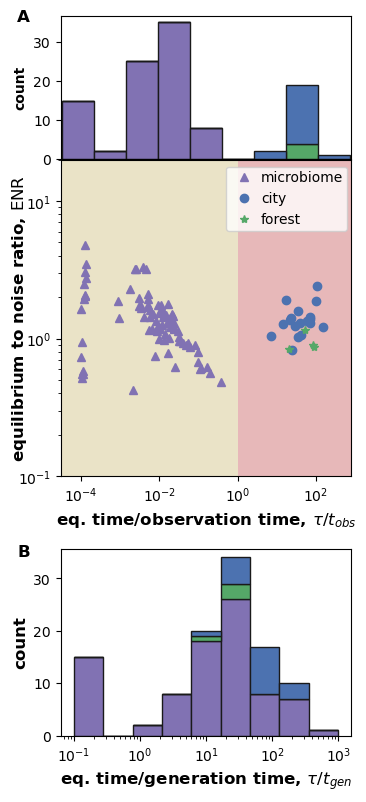

In [33]:
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_distribution_fit_params/'
is_rel_abundances=True
microbe_div_time=.175 ## 5.7 divisions per day
forest_div_time=55## 55 years
city_div_time=10 ## 10 years
# Delta_t=12  
with open(combined_params_path+'city_logG_fit_and_simvals.pkl', 'rb') as handle:
    city_logG_df=pd.DataFrame(pickle.load(handle)  )
city_mD_vals=  city_logG_df['bd_fit'].values
city_tau_vals= 1./city_logG_df['tp_fit'].values
city_rescaled_tau_divs=city_tau_vals/city_div_time
city_rescaled_tau_obs=city_tau_vals/17
with open(combined_params_path+'microbe_logG_fit_and_simvals.pkl', 'rb') as handle:
    microbe_logG_df=pd.DataFrame(pickle.load(handle)  )
microbe_mD_vals=  microbe_logG_df['bd_fit'].values
microbe_tau_vals= 1./microbe_logG_df['tp_fit'].values
microbe_rescaled_tau_divs=microbe_tau_vals/microbe_div_time ##5 divs per day
microbe_rescaled_tau_obs=microbe_tau_vals/300 ## by observation timescale

if is_rel_abundances:
    with open(combined_params_path+'BCI_rel_logG_clustfit_and_simvals.pkl', 'rb') as handle:
        BCI_ll_dict=pickle.load(handle)  
        del BCI_ll_dict['sp'] ## empty column prevents converting to dataframe
        BCIclust_logG_df=pd.DataFrame(BCI_ll_dict)
else:
    with open(combined_params_path+'BCI_logG_clustfit_and_simvals.pkl', 'rb') as handle:
        BCI_ll_dict=pickle.load(handle)  
        del BCI_ll_dict['sp'] ## empty column prevents converting to dataframe
        BCIclust_logG_df=pd.DataFrame(BCI_ll_dict)
BCIclust_mD_vals=  BCIclust_logG_df['bd_fit'].values
BCIclust_tau_vals= 5./BCIclust_logG_df['tp_fit'].values ## Delta t =5 years!
BCI_rescaled_tau_divs=BCIclust_tau_vals/forest_div_time# # assuming 100 year lifetime of a tree
BCI_rescaled_tau_obs=BCIclust_tau_vals/20

#### old params files
# city_fit_params_path='/Users/ashish/Box/research/James/BLS data/processed_BLS_data/fit_parameters/'
# with open(city_fit_params_path+'log_growth_F_fitvals-Delta_t'+str(Delta_t)+'.pkl', 'rb') as handle:
#     logG_F_fitvals = pickle.load(handle)
# city_mD_vals=  np.array(logG_F_fitvals ['NeutralTheory'])[:,1]
# city_tau_vals= 1./np.array(logG_F_fitvals ['NeutralTheory'])[:,0]
# microbiome_fit_fold='/Users/ashish/Box/research/James/microbiome data/microbiome_fits/'
# Delta_t=1  
# with open(microbiome_fit_fold+'fit_AFD_with_logG_K-fitvals-tau_'+str(Delta_t)+'.pkl', 'rb') as handle:
#     microbe_fit_vals = pickle.load(handle)  
# microbe_mD_vals=  microbe_fit_vals['m/D_logG']
# microbe_tau_vals= Delta_t/np.array(microbe_fit_vals['tau'] )  
# Delta_t=5
# BCI_fit_params_path='/Users/ashish/Box/research/James/BCI data/processed_BCI_data/fit_parameters/'
# with open(BCI_fit_params_path+'fit_logG_-fitvals.pkl', 'rb') as handle:
#     BCI_fit_vals_logG = pickle.load(handle)
# BCI_mD_vals=BCI_fit_vals_logG ['m/D_logG']
# BCI_logG_tau=Delta_t/BCI_fit_vals_logG ['tp']



from matplotlib.gridspec import GridSpec




# fig = plt.figure(figsize=(8, 4))
# gs2 = GridSpec(3, 2, left=0.05, right=0.98, hspace=0.05)
# ax1 = fig.add_subplot(gs2[1:, 0])
# ax1_top = fig.add_subplot(gs2[0, 0])
# ax2 = fig.add_subplot(gs2[:, 1])

fig = plt.figure(figsize=(3.5, 8.),constrained_layout=True)
gs2 = GridSpec(100, 1, left=0.15, right=0.98,top=.98, bottom=.08, hspace=0.05)
ax1 = fig.add_subplot(gs2[20:64, 0])
ax1_top = fig.add_subplot(gs2[:20, 0])
ax2 = fig.add_subplot(gs2[74:, 0])





x_multi=[]
x_multi.append(microbe_rescaled_tau_divs)
x_multi.append(BCI_rescaled_tau_divs)
x_multi.append(city_rescaled_tau_divs)
ax2.hist(x_multi, bins=np.logspace(-1,3,10) , histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbiome','forest','city'])

ax2.set_xlabel(r'eq. time/generation time, $\tau /t_{gen}$')
ax2.set_ylabel('count')
ax2.set_xscale('log')

ax2.text(-0.15,.96,'B',fontweight="bold",transform=ax2.transAxes,fontsize=MEDIUM_SIZE)


# xmin=3e-5
# xmax=400

xmin=3e-5
xmax=800

# ax1_top = ax2.inset_axes([0.1, 0.65, 0.3, 0.3])
x_multi=[]
x_multi.append(microbe_rescaled_tau_obs)
x_multi.append(BCI_rescaled_tau_obs)
x_multi.append(city_rescaled_tau_obs)
ax1_top.hist(x_multi, bins=np.logspace(np.log10(xmin*1.1),np.log10(xmax*.9),10) , histtype='barstacked', color=['m','g','b'],
         edgecolor='k',label=['microbiome','forest','city'])
# ax1_top.set_xlabel(r'$\tau /t_{obs}$',fontsize=SMALL_SIZE)
ax1_top.set_ylabel('count',fontsize=SMALL_SIZE)
ax1_top.set_xscale('log')
ax1_top.set_xlim(xmin, xmax)

ax1_top.text(-0.15,.96,'A',fontweight="bold",transform=ax1_top.transAxes,fontsize=MEDIUM_SIZE)
ax1_top.set_xticks([])
plt.setp(ax1_top.get_xticklabels(), visible=False)

 


# ax1 = fig2.add_subplot(1,2,1)
ax1.loglog(microbe_rescaled_tau_obs,microbe_mD_vals,'m^',label='microbiome')
ax1.loglog(city_rescaled_tau_obs,city_mD_vals,'bo',label='city')
ax1.loglog(BCI_rescaled_tau_obs,BCIclust_mD_vals,'g*',label='forest')
ax1.legend(loc=1,borderpad=0.3,handletextpad=0.2, bbox_to_anchor=(1.01, 1.0))
ax1.set_xlabel(r'eq. time/observation time, $\tau /t_{obs}$')
ax1.set_ylabel(r'equilibrium to noise ratio, $\mathrm{ENR}$',labelpad=-8)
ax1.set_ylim(1e-1, 20)
ax1.set_xlim(xmin, xmax)
ax1.set_xticks([1e-4,1e-2,1, 100])
ax1.axvspan(ax1.get_xlim()[0],1, color='y', alpha=0.4, lw=0)
ax1.axvspan(1, ax1.get_xlim()[1], color='r', alpha=0.4, lw=0)
# ax1.text(-0.15,.96,'B',fontweight="bold",transform=ax1.transAxes,fontsize=MEDIUM_SIZE)



# fig.tight_layout(hpad=)
if is_rel_abundances:
    plt.savefig(dest_path+'phase_dig+histogram_vert.png')
    plt.savefig(dest_path+'phase_dig+histogram_vert.pdf')
else:
    plt.savefig(dest_path+'phase_dig+histogram_vert_abs.png')

plt.show()

### equal aspect ratio figure panel B

14.280968479353765 2.4337633615277103


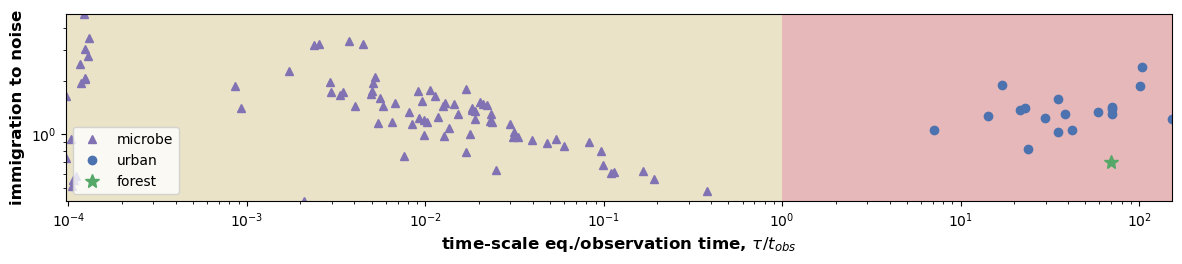

In [28]:
city_fit_params_path='/Users/ashish/Box/research/James/BLS data/processed_BLS_data/fit_parameters/'
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_distribution_fit_params/'
Delta_t=12
with open(city_fit_params_path+'log_growth_F_fitvals-Delta_t'+str(Delta_t)+'.pkl', 'rb') as handle:
    logG_F_fitvals = pickle.load(handle)
    
city_mD_vals=  np.array(logG_F_fitvals ['NeutralTheory'])[:,1]
city_tau_vals= 1./np.array(logG_F_fitvals ['NeutralTheory'])[:,0]
city_rescaled_tau_divs=city_tau_vals/15
city_rescaled_tau_obs=city_tau_vals/17
microbiome_fit_fold='/Users/ashish/Box/research/James/microbiome data/microbiome_fits/'
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_distribution_fit_params/'
Delta_t=1  
with open(microbiome_fit_fold+'fit_AFD_with_logG_K-fitvals-tau_'+str(Delta_t)+'.pkl', 'rb') as handle:
    microbe_fit_vals = pickle.load(handle)
    
microbe_mD_vals=  microbe_fit_vals['m/D_logG']
microbe_tau_vals= Delta_t/np.array(microbe_fit_vals['tau'] )  
microbe_rescaled_tau_divs=microbe_tau_vals*6 ## by number of divisions
microbe_rescaled_tau_obs=microbe_tau_vals/300 ## by observation timescale

Delta_t=5
BCI_fit_params_path='/Users/ashish/Box/research/James/BCI data/processed_BCI_data/fit_parameters/'
with open(BCI_fit_params_path+'fit_logG_-fitvals.pkl', 'rb') as handle:
    BCI_fit_vals_logG = pickle.load(handle)
BCI_mD_vals=BCI_fit_vals_logG ['m/D_logG']
BCI_logG_tau=Delta_t/BCI_fit_vals_logG ['tp']

BCI_rescaled_tau_divs=BCI_logG_tau/100 ## assuming 100 year lifetime of a tree
BCI_rescaled_tau_obs=BCI_logG_tau/20


xmin=np.min([np.min(microbe_rescaled_tau_obs),
              np.min(city_rescaled_tau_obs),np.min(BCI_rescaled_tau_obs)])
xmax=np.max([np.max(microbe_rescaled_tau_obs),
              np.max(city_rescaled_tau_obs),np.max(BCI_rescaled_tau_obs)])
ymin=np.min([np.min(microbe_mD_vals),
              np.min(city_mD_vals),np.min(BCI_mD_vals)])
ymax=np.max([np.max(microbe_mD_vals),
              np.max(city_mD_vals),np.max(BCI_mD_vals)])


xwidth=np.log(xmax)-np.log(xmin)
ywidth=np.log(ymax)-np.log(ymin)
print(xwidth,ywidth)
fig2 = plt.figure(figsize=(xwidth, ywidth))
ax2 = fig2.add_subplot()

ax2.loglog(microbe_rescaled_tau_obs,microbe_mD_vals,'m^',label='microbe')
ax2.loglog(city_rescaled_tau_obs,city_mD_vals,'bo',label='urban')
ax2.loglog(BCI_rescaled_tau_obs,BCI_mD_vals,'g*', ms=10,label='forest')
ax2.legend(loc=3)
ax2.set_xlabel(r'time-scale eq./observation time, $\tau /t_{obs}$')
ax2.set_ylabel('immigration to noise')
# ax2.set_ylim(1e-1, 10)
# ax2.set_xlim(1e-5, 1000)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)
ax2.axvspan(ax2.get_xlim()[0],1, color='y', alpha=0.4, lw=0)
ax2.axvspan(1, ax2.get_xlim()[1], color='r', alpha=0.4, lw=0)

xwidth=np.log(ax2.get_xlim()[1])-np.log(ax2.get_xlim()[0])
ywidth=np.log(ax2.get_ylim()[1])-np.log(ax2.get_ylim()[0])
# ax2.set_aspect(ywidth/xwidth)
# fig2.tight_layout()

# plt.savefig(dest_path+'equal_aspect_ratio.png')
plt.show()

### histograms

#### plot fit of species that had very small tau <1 generation

In [11]:
idx_small_tau=np.where(microbe_rescaled_tau_divs<1)[0]

15
[11 28 31 32 36 38 42 44 48 49 54 55 67 72 84]
34.52855266098192 0.02896153829030962
3.4528552660981924 0.2896153829030962
30.96169546406398 0.032297972866526664
3.096169546406398 0.3229797286652666
27.039594343956644 0.036982803339411056
2.7039594343956646 0.3698280333941105
32.270411339351746 0.03098813924260589
3.2270411339351748 0.3098813924260589
28.767028577934234 0.034762019208582795
2.8767028577934233 0.34762019208582795
28.320249234630722 0.03531042370831873
2.8320249234630723 0.3531042370831873
27.132762720883907 0.036855811930655576
2.7132762720883905 0.3685581193065558
25.432193888441653 0.03932024128105114
2.5432193888441654 0.3932024128105114


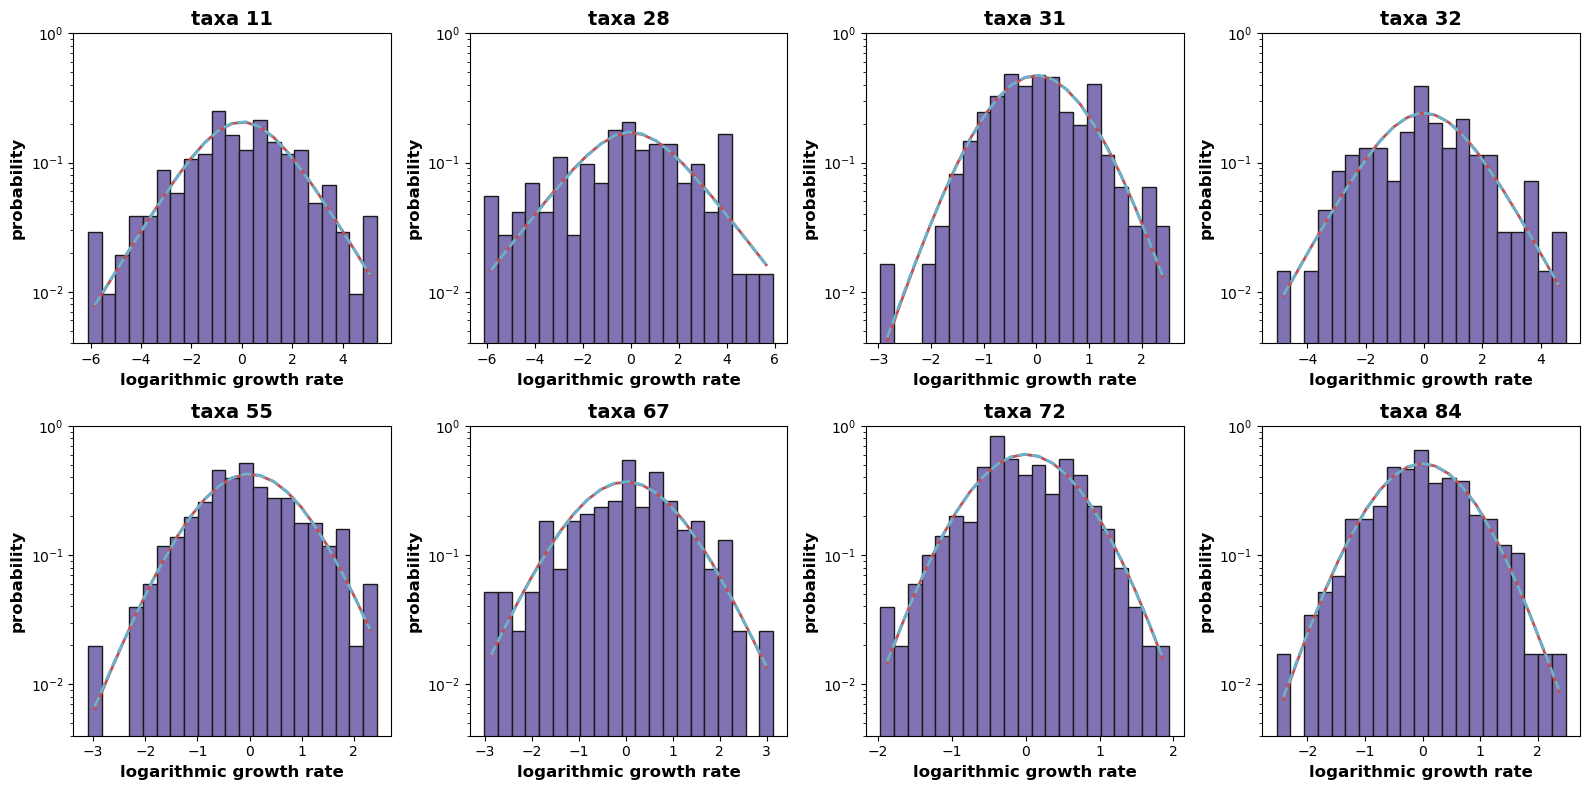

In [24]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
# weibull_inst = shared_func.symmetric_weibull_gen() 
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig1_growth_distribution/'
n_bins=21

idx_small_tau=np.where(microbe_rescaled_tau_divs<1)[0]
print (len(idx_small_tau))
print(idx_small_tau)
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(2,4,1)
ax2 = fig.add_subplot(2,4,2)
ax3 = fig.add_subplot(2,4,3)
ax4 = fig.add_subplot(2,4,4)
ax5 = fig.add_subplot(2,4,5)
ax6 = fig.add_subplot(2,4,6)
ax7 = fig.add_subplot(2,4,7)
ax8 = fig.add_subplot(2,4,8)
ax_list=[ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

sp_list=list(idx_small_tau[:4])+list(idx_small_tau[-4:])
tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]
idx_1_list=[]
idx_2_list=[]
for j,t2 in enumerate(time_points):
    if np.any(time_points==t2-tau):
        i=int(np.where(time_points==t2-tau)[0])
        t1=time_points[i]
#         print (i,j, t1, t2)
        idx_1_list.append(i)
        idx_2_list.append(j)
idxs_1=np.array(idx_1_list)
idxs_2=np.array(idx_2_list)

for i,sp in enumerate(sp_list):
    otu_t2=np.ravel(rel_abu_mat[sp,idxs_2])
    otu_t1=np.ravel(rel_abu_mat[sp,idxs_1])
    idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
    growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
    logG=np.log(growth_rates)
    
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            logG,10., 1., floc=0,fscale=1.)
    print(neut_tp, 1./neut_tp)
    neut_tp_by10, neut_bd_newfit, loc_neut, scale_neut = neutral_inst.fit(
            logG,ftp=neut_tp/10,  floc=0,fscale=1.)
    print(neut_tp_by10,1./neut_tp_by10)
    histogram, bins = np.histogram(logG, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax=ax_list[i]
    ax.hist(logG, bins=n_bins, density=True,facecolor='m', edgecolor='k')
    yvals=neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut)
    ax.plot(bin_centers, yvals,
             'r-',lw=2,label='BDI model') 
    
    yvals=neutral_inst.pdf(bin_centers, neut_tp_by10, neut_bd_newfit, loc=loc_neut,scale= scale_neut)
    ax.plot(bin_centers, yvals,
             'c--',lw=2,label='BDI 10xtau') 

    ax.set_ylim(4e-3,1) 
    ax.set_title('taxa '+str(int(sp)))
    

for ax in ax_list:
    ax.set_xlabel(r'logarithmic growth rate')
    ax.set_yscale('log')
    ax.set_ylabel(r'probability')
#     ax.set_ylim(5e-3,3.5) /
#     ax1.legend(loc='best')


# plt.tick_params(axis='both', which='both') 
fig.patch.set_facecolor('white')  
fig.tight_layout()
plt.show()
# plt.savefig(dest_path+'test.png')

## Variation of inferred parameters

In [51]:
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_distribution_fit_params/'
city_fit_params_path='/Users/ashish/Box/research/James/BLS data/processed_BLS_data/fit_parameters/'
BCI_fit_params_path='/Users/ashish/Box/research/James/BCI data/processed_BCI_data/fit_parameters/'
microbiome_fit_fold='/Users/ashish/Box/research/James/microbiome data/microbiome_fits/'

microbe_params={}
Delta_t=1
with open(combined_params_path+'microbe_logG_fitvals.pkl', 'rb') as handle:
    microbe_fit_vals_logG = pickle.load(handle)
microbe_params.update({'m/D_logG':np.array(microbe_fit_vals_logG['bd_fit'])})
microbe_params.update({'tau_logG':1./np.array(microbe_fit_vals_logG['tp_fit'])})
with open(combined_params_path+'microbe_AFD_shape_error_estimates.pkl', 'rb') as handle:
    microbe_fit_vals_AFD = pickle.load(handle)
microbe_params.update({'m/D_AFD':np.array(microbe_fit_vals_AFD['a_gamma_true'])})
microbe_params.update({'Dtau_AFD':np.array(microbe_fit_vals_AFD['scale_gamma_true'])})
assert len(microbe_params['m/D_AFD'])==len(microbe_params['m/D_logG'])
gm=np.exp((np.log(microbe_params['m/D_AFD'])+np.log(microbe_params['m/D_logG']))/2)
microbe_params.update({'m/D_GeomMean':gm})

microbe_params.update(
    {'m_i': microbe_params['m/D_GeomMean']*microbe_params['Dtau_AFD']/microbe_params['tau_logG'] })
microbe_params.update(
    {'D_i': microbe_params['m_i']/microbe_params['m/D_GeomMean']})


# with open(BCI_fit_params_path+'fit_logG_-fitvals.pkl', 'rb') as handle:
#     BCI_fit_vals_logG = pickle.load(handle)
# BCI_logG_shape=BCI_fit_vals_logG ['m/D_logG']
# BCI_AFD_atlogG_params={'m/D':BCI_logG_shape}

# Delta_t=12
# with open(city_fit_params_path+'log_growth_F_fitvals-Delta_t'+str(Delta_t)+'.pkl', 'rb') as handle:
#     city_AFD_atlogG_params = pickle.load(handle)
# city_logG_shape= np.array(city_fit_vals_logG['NeutralTheory'])[:,1]
# city_AFD_atlogG_params={'m/D':city_logG_shape}



BCI_params={}
with open(combined_params_path+'BCI_logG_fitvals.pkl', 'rb') as handle:
    BCI_fit_vals_logG = pickle.load(handle)
BCI_params.update({'m/D_logG':np.array(BCI_fit_vals_logG['bd_fit'])})
BCI_params.update({'tau_logG':1./np.array(BCI_fit_vals_logG['tp_fit'])})
with open(combined_params_path+'BCI_AFD_shape_error_estimates.pkl', 'rb') as handle:
    BCI_fit_vals_AFD = pickle.load(handle)
BCI_params.update({'m/D_AFD':np.array(BCI_fit_vals_AFD['a_gamma_true'])})
BCI_params.update({'Dtau_AFD':np.array(BCI_fit_vals_AFD['scale_gamma_true'])})
assert len(BCI_params['m/D_AFD'])==len(BCI_params['m/D_logG'])
gm=np.exp((np.log(BCI_params['m/D_AFD'])+np.log(BCI_params['m/D_logG']))/2)
BCI_params.update({'m/D_GeomMean':gm})

BCI_params.update(
    {'m_i': BCI_params['m/D_GeomMean']*BCI_params['Dtau_AFD']/BCI_params['tau_logG'] })
BCI_params.update(
    {'D_i': BCI_params['m_i']/BCI_params['m/D_GeomMean']})



city_params={}
with open(combined_params_path+'city_logG_fitvals.pkl', 'rb') as handle:
    city_fit_vals_logG = pickle.load(handle)
city_params.update({'m/D_logG':np.array(city_fit_vals_logG['bd_fit'])})
city_params.update({'tau_logG':1./np.array(city_fit_vals_logG['tp_fit'])})
with open(combined_params_path+'city_AFD_shape_error_estimates.pkl', 'rb') as handle:
    city_fit_vals_AFD = pickle.load(handle)
city_params.update({'m/D_AFD':np.array(city_fit_vals_AFD['a_gamma_true'])})
city_params.update({'Dtau_AFD':np.array(city_fit_vals_AFD['scale_gamma_true'])})
assert len(city_params['m/D_AFD'])==len(city_params['m/D_logG'])
gm=np.exp((np.log(city_params['m/D_AFD'])+np.log(city_params['m/D_logG']))/2)
city_params.update({'m/D_GeomMean':gm})

city_params.update(
    {'m_i': city_params['m/D_GeomMean']*city_params['Dtau_AFD']/city_params['tau_logG'] })
city_params.update(
    {'D_i': city_params['m_i']/city_params['m/D_GeomMean']})

In [52]:
fig2 = plt.figure(figsize=(8, 8))
ax1 = fig2.add_subplot(2,2,1)



ax1.plot(microbe_params['m_i'],microbe_params['D_i'],'m^')
ax1.plot(city_params['m_i'],city_params['D_i'],'bo')
ax1.plot(BCI_params['m_i'],BCI_params['D_i'],'g*',ms=10)

ax1.set_xlabel('m_i')

ax1.set_ylabel('D_i')
ax1.set_xscale('log')
ax1.set_yscale('log')
# ax1.set_ylim(1e-1, 10)

ax2 = fig2.add_subplot(2,2,2)
ax2.loglog(microbe_params['tau_logG'],microbe_params['m_i'],'m^',label='microbe')
ax2.loglog(city_params['tau_logG'],city_params['m_i'],'bo',label='urban')
ax2.loglog(BCI_params['tau_logG'],BCI_params['m_i'],'g*',label='forest')
# ax2.legend(loc=3)
ax2.set_ylabel(r'm')
ax2.set_xlabel(r'$\tau$')



ax3 = fig2.add_subplot(2,2,3)
ax3.loglog(microbe_params['tau_logG']*microbe_params['D_i'],microbe_params['m_i']*microbe_params['tau_logG'],'m^',label='microbe')
ax3.loglog(city_params['tau_logG']*city_params['D_i'],city_params['m_i']*city_params['tau_logG'],'bo',label='urban')
# ax3.loglog(BCI_params['tau_logG']*BCI_params['D_i'],BCI_params['m_i']*BCI_params['tau_logG'],'g*',label='forest')

ax3.set_ylabel(r'$m \tau$')
ax3.set_xlabel(r' $D \tau$')

ax4 = fig2.add_subplot(2,2,4)
ax4.loglog(microbe_params['m_i']/microbe_params['D_i'],microbe_params['m_i']*microbe_params['tau_logG'],'m^',label='microbe',alpha=.5)
ax4.loglog(city_params['m_i']/city_params['D_i'],city_params['m_i']*city_params['tau_logG'],'bo',label='urban')
# ax3.loglog(BCI_params['tau_logG']*BCI_params['D_i'],BCI_params['m_i']*BCI_params['tau_logG'],'g*',label='forest')


temp=microbe_params['m_i']*microbe_params['tau_logG']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
ax4.set_ylabel(r'$m \tau$, CV={:.2e}'.format(cv)+ r', $\sigma_{\log x}=$'+ '{:.2e}'.format(std_log), fontweight='normal' )
m_ov_D=microbe_params['m_i']/microbe_params['D_i']
cv=np.std(m_ov_D)/np.mean(m_ov_D)
std_log=np.std(np.log(m_ov_D))
ax4.set_xlabel(r'$m/D$, CV={:.1e}'.format(cv) +r', $\sigma_{\log x}=$'+ '{:.1e}'.format(std_log), fontweight='normal' )

 

m_ov_D=microbe_params['m_i']/microbe_params['D_i']
cv=np.std(m_ov_D)/np.mean(m_ov_D)
std_log=np.std(np.log(m_ov_D))
print('microbe m/D CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))


m_ov_D=city_params['m_i']/city_params['D_i']
cv=np.std(m_ov_D)/np.mean(m_ov_D)
std_log=np.std(np.log(m_ov_D))
print('city m/D CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))

fig2.tight_layout()

plt.savefig(dest_path+'params_scatterplots.png')
plt.show()

microbe m/D CV, 4.2e-01,  std_log=4.8e-01
city m/D CV, 6.7e-01,  std_log=6.3e-01


In [53]:
m_ov_D=microbe_params['m_i']/microbe_params['D_i']
cv=np.std(m_ov_D)/np.mean(m_ov_D)
std_log=np.std(np.log(m_ov_D))
print('microbe m/D CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))

temp=microbe_params['m_i']*microbe_params['tau_logG']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
print('microbe m tau CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))

temp=microbe_params['D_i']*microbe_params['tau_logG']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
print('microbe D tau CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))

temp=microbe_params['m_i']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
print('microbe m CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))

temp=microbe_params['D_i']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
print('microbe D  CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))

temp=microbe_params['tau_logG']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
print('microbe tau  CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))


m_ov_D=city_params['m_i']/city_params['D_i']
cv=np.std(m_ov_D)/np.mean(m_ov_D)
std_log=np.std(np.log(m_ov_D))
print('city m/D CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))

temp=city_params['m_i']*city_params['tau_logG']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
print('city mtau CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))


temp=city_params['m_i']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
print('city m CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))

temp=city_params['D_i']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
print('city D  CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))



temp=city_params['tau_logG']
cv=np.std(temp)/np.mean(temp)
std_log=np.std(np.log(temp))
print('city tau  CV, {:.1e}'.format(cv)+',  std_log={:.1e}'.format(std_log))


microbe m/D CV, 4.2e-01,  std_log=4.8e-01
microbe m tau CV, 1.6e+00,  std_log=1.0e+00
microbe D tau CV, 1.7e+00,  std_log=1.3e+00
microbe m CV, 2.6e+00,  std_log=2.2e+00
microbe D  CV, 3.3e+00,  std_log=2.5e+00
microbe tau  CV, 2.1e+00,  std_log=2.1e+00
city m/D CV, 6.7e-01,  std_log=6.3e-01
city mtau CV, 7.7e-01,  std_log=7.9e-01
city m CV, 1.0e+00,  std_log=8.9e-01
city D  CV, 1.9e+00,  std_log=1.2e+00
city tau  CV, 7.3e-01,  std_log=7.7e-01


# parameter consistency parameters from logG and AFD fits.

- data files used here are made by the relevant section in the notebook combined_analysis and individual python scripts used to sample the distribustions on the cluster.

n_invalid and n_valid microbes  29 56
n_invalid and n_valid trees  0 4
n_invalid and n_valid employment sectors  0 18


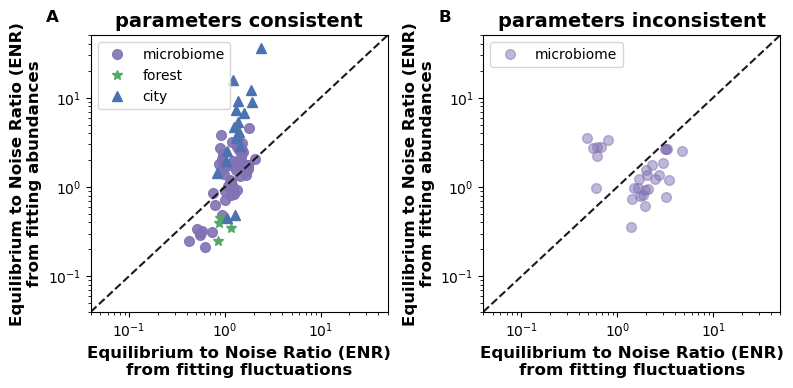

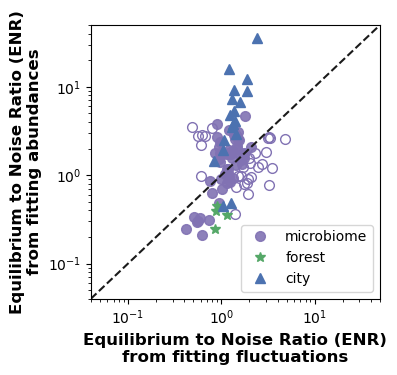

In [31]:
threshold=95 # for rejection (only if both pctile scores>95 is data rejected)
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_distribution_fit_params/'

is_rel_abundances=True
with open(combined_params_path+'microbe_AFD_atlogG_params_pctiles.pkl', 'rb') as handle:
    microbe_AFD_atlogG_params=pickle.load(handle)     
with open(combined_params_path+'city_AFD_atlogG_params_pctiles.pkl', 'rb') as handle:
    city_AFD_atlogG_params=pickle.load( handle)  
if is_rel_abundances:
    with open(combined_params_path+'BCI_rel_clust_AFD_atlogG_params_pctiles.pkl', 'rb') as handle:
        BCIclust_AFD_atlogG_params=pickle.load(handle)  
else:
    with open(combined_params_path+'BCIclust_AFD_atlogG_params_pctiles.pkl', 'rb') as handle:
        BCIclust_AFD_atlogG_params=pickle.load(handle) 


with open(combined_params_path+'microbe_logG_atAFD_fit_and_simvals_pctiles.pkl', 'rb') as handle:
    microbe_logG_atAFD_params=pickle.load( handle)   
with open(combined_params_path+'city_logG_atAFD_fit_and_simvals_pctiles.pkl', 'rb') as handle:
    city_logG_atAFD_params=pickle.load( handle)  
if is_rel_abundances:
    with open(combined_params_path+'BCI_rel_clust_logG_atAFD_fit_and_simvals_pctiles.pkl', 'rb') as handle:
        BCIclust_logG_atAFD_params=pickle.load( handle)  
else:
    with open(combined_params_path+'BCIclust_logG_atAFD_fit_and_simvals_pctiles.pkl', 'rb') as handle:
        BCIclust_logG_atAFD_params=pickle.load( handle)  



fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
fig2 = plt.figure(figsize=(4, 3.7))
ax2_1 = fig2.add_subplot()

microbe_logG_shape=np.array(microbe_AFD_atlogG_params['m/D'])
microbe_AFD_shape=np.array(microbe_logG_atAFD_params['bd_fit'])
idx_valid=np.zeros(len(microbe_logG_shape)).astype(bool)
### if idx is cannot be rejected in one of the two cases, then it is valid (cannto be rejected )
for idx,val in enumerate(microbe_AFD_atlogG_params['pctile_scores']):
    if val < threshold:
        idx_valid[idx]=True
for idx,val in enumerate(microbe_logG_atAFD_params['pctile_scores']):
    if val < threshold:
        idx_valid[idx]=True      
        
idx_invalid=np.logical_not(idx_valid)

print ('n_invalid and n_valid microbes ',np.sum(idx_invalid) ,np.sum(idx_valid))
if np.any(idx_valid==True):
    ax1.plot(microbe_logG_shape[idx_valid],microbe_AFD_shape[idx_valid],'mo', markersize=7,alpha=0.9,label='microbiome')
    ax2_1.plot(microbe_logG_shape[idx_valid],microbe_AFD_shape[idx_valid],'o', color='m', markersize=7,alpha=0.9,label='microbiome')
if np.any(idx_valid==False):
    ax2.plot(microbe_logG_shape[idx_invalid],microbe_AFD_shape[idx_invalid],'mo', markersize=7,alpha=0.5,label='microbiome')
    ax2_1.plot(microbe_logG_shape[idx_invalid],microbe_AFD_shape[idx_invalid],'o', mec='m', mfc='None', markersize=7)
    
    
BCIclust_logG_shape=np.array(BCIclust_AFD_atlogG_params['m/D'])
BCIclust_AFD_shape=np.array(BCIclust_logG_atAFD_params['bd_fit'])
# BCIclust_pctile_score1=float(BCIclust_AFD_atlogG_params['pctile_scores'][0])
# BCIclust_pctile_score2=float(BCIclust_logG_atAFD_params['pctile_scores'][0])

idx_valid=np.zeros(len(BCIclust_logG_shape)).astype(bool)

for idx,val in enumerate(BCIclust_AFD_atlogG_params['pctile_scores']):
    if val < threshold:
        idx_valid[idx]=True
for idx,val in enumerate(BCIclust_logG_atAFD_params['pctile_scores']):
    if val < threshold:
        idx_valid[idx]=True
idx_invalid=np.logical_not(idx_valid)

if np.any(idx_valid==True):
    ax1.plot(BCIclust_logG_shape[idx_valid],BCIclust_AFD_shape[idx_valid],'g*',
             markersize=7,label='forest')
    ax2_1.plot(BCIclust_logG_shape[idx_valid],BCIclust_AFD_shape[idx_valid],'g*',
             markersize=7,label='forest')
if np.any(idx_valid==False):
    ax2.plot(BCIclust_logG_shape[idx_invalid],BCIclust_AFD_shape[idx_invalid],'g*' ,
             markersize=7,label='forest')
    ax2_1.plot(BCIclust_logG_shape[idx_invalid],BCIclust_AFD_shape[idx_invalid],'*',mec='g', mfc='None' ,
             markersize=7,label='forest')
    
print ('n_invalid and n_valid trees ',np.sum(idx_invalid) ,np.sum(idx_valid))    
    
city_logG_shape=np.array(city_AFD_atlogG_params['m/D'])
city_AFD_shape=np.array(city_logG_atAFD_params['bd_fit'])
idx_valid=np.zeros(len(city_logG_shape)).astype(bool)

for idx,val in enumerate(city_AFD_atlogG_params['pctile_scores']):
    if val < threshold:
        idx_valid[idx]=True
for idx,val in enumerate(city_logG_atAFD_params['pctile_scores']):
    if val < threshold:
        idx_valid[idx]=True
idx_invalid=np.logical_not(idx_valid)
if np.any(idx_valid==True):
    ax1.plot(city_logG_shape[idx_valid],city_AFD_shape[idx_valid],'b^',
             markersize=7,label='city')
    ax2_1.plot(city_logG_shape[idx_valid],city_AFD_shape[idx_valid],'b^',
             markersize=7,label='city')
if np.any(idx_valid==False):
    ax2.plot(city_logG_shape[idx_invalid],city_AFD_shape[idx_invalid],'b^' ,
             markersize=7,label='city')
    ax2_1.plot(city_logG_shape[idx_invalid],city_AFD_shape[idx_invalid],'^',mec='b', mfc='None' ,
             markersize=7,label='city')

print ('n_invalid and n_valid employment sectors ',np.sum(idx_invalid) ,np.sum(idx_valid))   
for ax in [ax1,ax2,ax2_1]:
    ax.legend(loc='best') 
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(4e-2, 5e1)
    ax.set_ylim(4e-2, 5e1)
    minval=min(ax.get_xlim()[0],ax.get_ylim()[0])
    maxval=max(ax.get_xlim()[1],ax.get_ylim()[1])
    ax.plot((minval,maxval), (minval,maxval),'k--')
    ax.set_ylabel('Equilibrium to Noise Ratio (ENR)\nfrom fitting abundances')
    ax.set_xlabel('Equilibrium to Noise Ratio (ENR)\nfrom fitting fluctuations')
ax1.set_title('parameters consistent')
ax2.set_title('parameters inconsistent')
# ax2_1.set_title ('inferred Equilibrium to Noise Ratio (ENR)')
# ax2_1.set_ylabel('from fitting abundances')
# ax2_1.set_xlabel('from fitting fluctuations')
ax1.text(-0.15,1.05,'A',fontweight="bold",transform=ax1.transAxes,fontsize=MEDIUM_SIZE)
ax2.text(-0.15,1.05,'B',fontweight="bold",transform=ax2.transAxes,fontsize=MEDIUM_SIZE)
fig.tight_layout()
fig2.tight_layout()
if is_rel_abundances:
    fig.savefig(dest_path+'parameter_consistency-2panel.png')
    fig2.savefig(dest_path+'parameter_consistency-1panel.png')
    fig2.savefig(dest_path+'parameter_consistency-1panel.pdf')
else:
    fig.savefig(dest_path+'parameter_consistency-2panel_abs.png')
    fig2.savefig(dest_path+'parameter_consistency-1panel_abs.png')
plt.show()






# Taylor's law

## 3 panel

In [ ]:
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_taylors_law/'

variance_list=[]
mean_list=[]

time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']

sp_idxs=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_t_mat=rel_abu_t_mat_full[sp_idxs]

fig = plt.figure(figsize=(4,3.7))
ax1 = fig.add_subplot()

for sp in range(len(rel_abu_t_mat)):
#     ax1.plot(np.mean(rel_abu_t_mat[sp]), np.var(rel_abu_t_mat[sp]) )
    mean_list.append(np.mean(rel_abu_t_mat[sp]))
    variance_list.append(np.var(rel_abu_t_mat[sp]))
ax1.plot(mean_list,variance_list,'mo')

fit_result = scipy.stats.linregress(np.log10(mean_list), np.log10(variance_list))
xdummy=np.linspace(1e-4, 1,5)                
ax1.plot(xdummy,.5*xdummy**2, 'k--', lw=2, label=r'$y \sim x^2$')
# ax1.plot(xdummy,(10.**fit_result.intercept)*(xdummy**fit_result.slope), 'k-',
#          lw=2, label=r'$y \sim x$^'+ '{:.2f}'.format(fit_result.slope))
# ax1.legend(loc='upper left',bbox_to_anchor=(1.04,1),ncol=2)     
ax1.legend(loc='best')
ax1.set_xlabel(r'mean abundance')
ax1.set_ylabel(r'variance of abundance')
ax1.set_xscale('log')
ax1.set_yscale('log')        
plt.tight_layout()
plt.savefig(dest_path+'microbe_taylorslaw.png')
plt.show()

print('best fit was ', fit_result.slope)

## microbe only

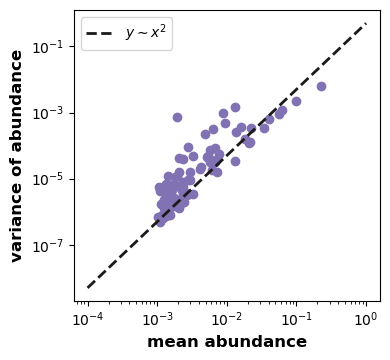

best fit was  1.7254852394085511


In [70]:
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_taylors_law/'

variance_list=[]
mean_list=[]

time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']

sp_idxs=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_t_mat=rel_abu_t_mat_full[sp_idxs]

fig = plt.figure(figsize=(4,3.7))
ax1 = fig.add_subplot()

for sp in range(len(rel_abu_t_mat)):
#     ax1.plot(np.mean(rel_abu_t_mat[sp]), np.var(rel_abu_t_mat[sp]) )
    mean_list.append(np.mean(rel_abu_t_mat[sp]))
    variance_list.append(np.var(rel_abu_t_mat[sp]))
ax1.plot(mean_list,variance_list,'mo')

fit_result = scipy.stats.linregress(np.log10(mean_list), np.log10(variance_list))
xdummy=np.linspace(1e-4, 1,5)                
ax1.plot(xdummy,.5*xdummy**2, 'k--', lw=2, label=r'$y \sim x^2$')
# ax1.plot(xdummy,(10.**fit_result.intercept)*(xdummy**fit_result.slope), 'k-',
#          lw=2, label=r'$y \sim x$^'+ '{:.2f}'.format(fit_result.slope))
# ax1.legend(loc='upper left',bbox_to_anchor=(1.04,1),ncol=2)     
ax1.legend(loc='best')
ax1.set_xlabel(r'mean abundance')
ax1.set_ylabel(r'variance of abundance')
ax1.set_xscale('log')
ax1.set_yscale('log')        
plt.tight_layout()
plt.savefig(dest_path+'microbe_taylorslaw.png')
plt.show()

print('best fit was ', fit_result.slope)

# Compare SLRM to SLM

In [3]:
import matplotlib.pylab as pylab
def simulate_SLM(K, sigma, tau, x0, T, dt=.01, sampling_time=.2, min_threshold=1e-6):
    n_coeff=np.sqrt(sigma/tau)
    x=x0
    sim_times=np.arange(0,T, dt)
    sim_steps=np.arange(0,len(sim_times))
    
    n_samples=int(T/sampling_time)
    sampling_step_interval=int(len(sim_steps)/n_samples)
    time_list=[]
    x_list=[]
    assert tau>5*dt,'otherwise dt is not small enough'
    random_numbers=np.random.normal(scale=np.sqrt(dt),size=len(sim_times))
    ## variance of normal distribution is set by time discretization.
    for step in sim_steps:
        x= x + dt*x*(1-x/K)/tau + n_coeff *x*random_numbers[step] 
        if x<min_threshold: x=min_threshold ## we don't let population go completely extinct.
        if step% sampling_step_interval==0:
            time_list.append(step*dt)
            x_list.append(x)   

    return np.array(x_list)[:n_samples], np.array(time_list)[:n_samples]

Management


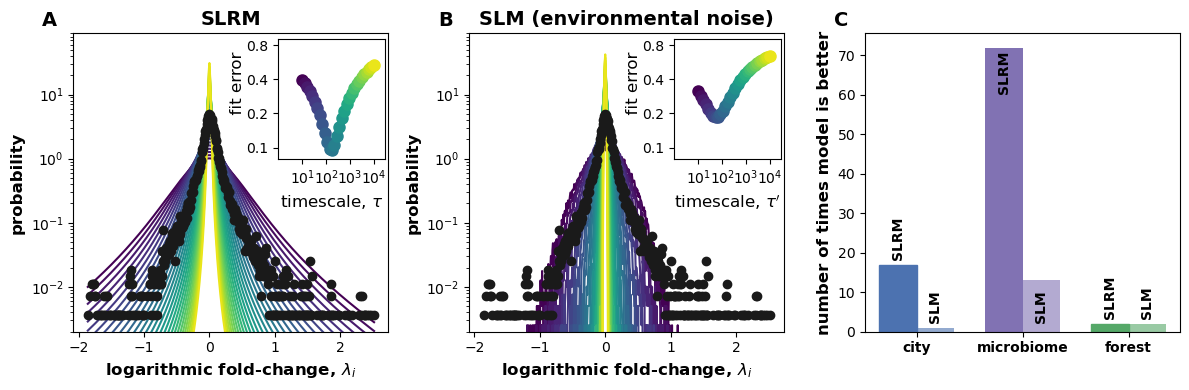

In [4]:
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/fig_compare_SLRM_SLM/'

with open(combined_params_path+'city_AFD_shape_error_estimates.pkl', 'rb') as handle:
    city_AFD_err_bars_dict=pickle.load(handle)  
assert city_AFD_err_bars_dict['time_stamp_abu']=='16-Q3-M1'

neutral_inst = shared_func.azaele_neutral_logG_distribution()
city_logG_atAFD_params_minKL={'naics':[],'time_stamp_abu':'16-Q3-M1',
                        'tp_fit':[],'bd_fit':[],'data_length':[],'logLk':[]}

shape_param_dict={}
scale_param_dict={}

chosen_naics=['naics_55']

for naics in chosen_naics:
    idx= np.where(np.array(city_AFD_err_bars_dict['naics'])==naics)[0][0]  
    shape_param_dict.update({naics:city_AFD_err_bars_dict['a_gamma_true'][idx]})
    scale_param_dict.update({naics:city_AFD_err_bars_dict['scale_gamma_true'][idx]})


min_jsd_SLM=[]
min_jsd_SLRM=[]

jsd_SLM_SLRM_dict={'naics':[],'jsd_SLM':[],'jsd_SLRM':[],'tau':[],'min_jsd_SLM':[],'min_jsd_SLRM':[]}
# jsd_SLRM_dict={'naics':[],'jsd':[],'tau':[],'min_jsd':[]}


### this for loop is no longer used. Only naics category is plotted now.
for i,naics in enumerate(chosen_naics):
    logratio_list=shared_func.get_LogRatio(df_metroF_time, [naics],
                                       time_stamps_likeCBP_list,tau=12)
    emp_logG=np.ravel(logratio_list)
    print(shared_func.sector_from_naics(df_naics_ref, naics, shorten=True))
    sigma=2./(shape_param_dict[naics]+1)
    K=scale_param_dict[naics]*2./sigma
    T=1e5
    Delta_t=sampling_time=1
    tau_list=np.logspace(np.log10(1e1),np.log10(10000),30)
#     tau_list=np.logspace(np.log10(1e1),np.log10(10000),5)
    ctr=0
    for tau in tau_list:
        dt=min(tau/20,.1)
        x0=.2
        xarr,time_arr=simulate_SLM(K, sigma, tau, x0, T, dt=dt, sampling_time=sampling_time)
        log_g=np.log(xarr[1:]/xarr[:-1])
        if ctr==0:
            x_res_grid=deepcopy(xarr)
            time_grid=deepcopy(time_arr)   
            logG_res_grid=deepcopy(log_g)
        else:
            x_res_grid=np.vstack((x_res_grid,xarr))
            time_grid=np.vstack((time_grid,time_arr))
            logG_res_grid=np.vstack((logG_res_grid,log_g))
        ctr+=1
    
    KL_div_logG=[]
    jsd_logG_slm=[]
    jsd_logG_SLRM=[]


    
    logG_bins=np.histogram_bin_edges(emp_logG, bins='fd') 
    logG_bin_centers = 0.5*(logG_bins[1:] + logG_bins[:-1])
    logG_hist, bins = np.histogram(emp_logG, bins=logG_bins, density=True)

    fig = plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(1,3,1)
    ax1_inset = ax1.inset_axes([0.65, 0.58, 0.34, 0.4])
    ax2 = fig.add_subplot(1,3,2)
    ax2_inset = ax2.inset_axes([0.65, 0.58, 0.34, 0.4])
    
    ax3 = fig.add_subplot(1,3,3)

    n_colors = 1+len(tau_list)
    color_list = pylab.cm.viridis(np.linspace(0,1,n_colors))
    n_samples=len(logG_res_grid[0])
    
    

    
    
    for i in range(len(tau_list)):

        tau=tau_list[i]
        slm_logGvals=logG_res_grid[i][n_samples//2:] ## only want steady-state onwards
        slm_logG_hist,_=np.histogram(slm_logGvals, bins=logG_bins, density=True)## computed on the same bins!
        jsd_logG_slm.append(scipy_spatial_distance.jensenshannon(logG_hist,slm_logG_hist) )

        neutral_inst = shared_func.azaele_neutral_logG_distribution()

        SLRM_logG_hist= neutral_inst.pdf(logG_bin_centers,tp=1./tau,
                                         bd=shape_param_dict[naics], 
                                      loc=0,scale=1.)
#         SLRM_logG_cdf_binEnd=neutral_inst.cdf(logG_bins[1:],tp=1./tau,
#                                          bd=shape_param_dict[naics],  loc=0,scale=1.)
#         SLRM_logG_cdf_binStart=neutral_inst.cdf(logG_bins[:-1],tp=1./tau,
#                                          bd=shape_param_dict[naics], loc=0,scale=1.)
#         SLRM_logG_hist=(SLRM_logG_cdf_binEnd-SLRM_logG_cdf_binStart)/(
#             logG_bins[1:]-logG_bins[:-1])        
        if i%5==0:
            ax2.plot(logG_bin_centers,slm_logG_hist,
                         '-',color=color_list[i], label=r'$\tau=$'+'{:.1e}'.format(tau)) 
            ax1.plot(logG_bin_centers,SLRM_logG_hist,
                         '-',color=color_list[i], label=r'$\tau=$'+'{:.1e}'.format(tau))
        else:
            ax2.plot(logG_bin_centers,slm_logG_hist,
                         '-',color=color_list[i]) 
            ax1.plot(logG_bin_centers,SLRM_logG_hist,
                         '-',color=color_list[i])
        jsd_logG_SLRM.append(scipy_spatial_distance.jensenshannon(logG_hist,SLRM_logG_hist) )




    ax2.plot(logG_bin_centers,logG_hist, 'ko', label='data' )   
#     ax2.bar(logG_bin_centers,logG_hist,width=0.1, label='data' )
    ax2.set_yscale('log')
    ax1.plot(logG_bin_centers,logG_hist, 'ko', label='data' )   
    ax1.set_yscale('log')  
    
    from matplotlib.ticker import ScalarFormatter,FormatStrFormatter 
#     ax2_inset.loglog(tau_list,jsd_logG_slm,'-', color='grey')
    for i in range(len(tau_list)):
        ax2_inset.loglog(tau_list[i],jsd_logG_slm[i],'o',color=color_list[i], ms=8)
#         if i<len(tau_list)-1:
#             ax2_inset.loglog([tau_list[i],tau_list[i+1]],
#                        [jsd_logG_slm[i],jsd_logG_slm[i+1]],'-',color=color_list[i])
    


#     ax1_inset.loglog(tau_list,jsd_logG_SLRM,'-', color='grey')
    for i in range(len(tau_list)):
#         ax1_inset.plot(tau_list[i],jsd_logG_SLRM[i],'o',color=color_list[i],ms=8)      
        ax1_inset.loglog(tau_list[i],jsd_logG_SLRM[i],'o',color=color_list[i],ms=8)
#         if i<len(tau_list)-1:
#             ax1_inset.loglog([tau_list[i],tau_list[i+1]],
#                        [jsd_logG_SLRM[i],jsd_logG_SLRM[i+1]],'-',color=color_list[i])
            
    ax1_inset.set_xscale('log')   
    ax1_inset.set_yscale('log')   

    ax2_inset.set_ylabel('      fit error',fontweight='normal',labelpad=1)
    ax2_inset.set_xlabel(r'timescale, $\tau^{\prime}$',fontweight='normal')
    ax1_inset.set_ylabel('      fit error',fontweight='normal',labelpad=1)
    ax1_inset.set_xlabel(r'timescale, $\tau$',fontweight='normal')
#     ax2_inset.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#     ax2_inset.ticklabel_format(axis='y', style='plain')

    
    ax2_inset.set_yticks([0.1,0.2,0.4,0.8])
    ax2_inset.set_yticklabels(['0.1','0.2','0.4','0.8'])
#     ax2_inset.get_yaxis().set_major_formatter(ScalarFormatter())
    ax2_inset.get_yaxis().get_major_formatter().labelOnlyBase = False
    ax2_inset.set_xticks([1e1,1e2,1e3,1e4])    
    ax2_inset.minorticks_off()
    
    
    ax1_inset.set_yticks([0.1,0.2,0.4,0.8])
    ax1_inset.set_yticklabels(['0.1','0.2','0.4','0.8'])
#     ax1_inset.get_yaxis().set_major_formatter(ScalarFormatter())
    ax1_inset.get_yaxis().get_major_formatter().labelOnlyBase = False
    ax1_inset.set_xticks([1e1,1e2,1e3,1e4])    
    ax1_inset.minorticks_off()
    
    
    ax2_inset.set_xlim(.95,3e4)
    ax1_inset.set_xlim(.95,3e4)
    ax2_inset.set_ylim(.08,.9)
    ax1_inset.set_ylim(.08,.9)
    
#     formatter = ScalarFormatter()
#     formatter.set_scientific(False)
#     formatter.set_useOffset(False)
#     ax2_inset.yaxis.set_major_formatter(formatter)
#     ax2_inset.yaxis.set_minor_formatter(formatter)
    
#     ax1_inset.yaxis.set_major_formatter(formatter)
#     ax1_inset.yaxis.set_minor_formatter(formatter)
        
    ax2.set_ylim(2e-3,9e1)
    ax1.set_ylim(2e-3,9e1)
    
    ax2.set_xlabel(r'logarithmic fold-change, $\lambda_i$')
    ax1.set_xlabel(r'logarithmic fold-change, $\lambda_i$')
    ax2.set_ylabel(r'probability')
    ax1.set_ylabel(r'probability')
    
    
    
################ bar plot  ##############
    
    with open(combined_params_path+'BCI_rel_clust_compare_SLRM_SLM_jsd.pkl', 'rb') as handle:
        forest_compare_JSD=pickle.load(handle)  
    SLRM_better_ctr_forest=0
    slm_better_ctr_forest=0
    for i in range(len(forest_compare_JSD['min_jsd_SLRM'])):  
        if forest_compare_JSD['min_jsd_SLRM'][i]<forest_compare_JSD['min_jsd_SLM'][i]:
            SLRM_better_ctr_forest+=1
        elif forest_compare_JSD['min_jsd_SLRM'][i]>forest_compare_JSD['min_jsd_SLM'][i]:
            slm_better_ctr_forest+=1

    with open(combined_params_path+'city_compare_SLRM_SLM_jsd.pkl', 'rb') as handle:
            city_compare_JSD=pickle.load(handle)  
    SLRM_better_ctr_city=0
    slm_better_ctr_city=0
    for i in range(len(city_compare_JSD['min_jsd_SLRM'])):  
        if city_compare_JSD['min_jsd_SLRM'][i]<city_compare_JSD['min_jsd_SLM'][i]:
            SLRM_better_ctr_city+=1
        elif city_compare_JSD['min_jsd_SLRM'][i]>city_compare_JSD['min_jsd_SLM'][i]:
            slm_better_ctr_city+=1        

    with open(combined_params_path+'microbe_compare_SLRM_SLM_jsd.pkl', 'rb') as handle:
            microbe_compare_JSD=pickle.load(handle)  
    SLRM_better_ctr_microbe=0
    slm_better_ctr_microbe=0
    for i in range(len(microbe_compare_JSD['min_jsd_SLRM'])):  
        if microbe_compare_JSD['min_jsd_SLRM'][i]<microbe_compare_JSD['min_jsd_SLM'][i]:
            SLRM_better_ctr_microbe+=1
        elif microbe_compare_JSD['min_jsd_SLRM'][i]>microbe_compare_JSD['min_jsd_SLM'][i]:
            slm_better_ctr_microbe+=1        


            
            
    width=0.35
    ax3.bar(1-width/2, SLRM_better_ctr_city, width,facecolor='b',edgecolor='b')
    ax3.bar(1+width/2, slm_better_ctr_city, width,
            facecolor='b', alpha=.6) 
    ax3.text(1-width/2, SLRM_better_ctr_city+2, 'SLRM',rotation='vertical',ha='center',
            fontweight="bold")
    ax3.text(1+width/2, slm_better_ctr_city+2, 'SLM',rotation='vertical',ha='center',
            fontweight="bold")

    ax3.bar(2-width/2, SLRM_better_ctr_microbe, width,facecolor='m')
    ax3.bar(2+width/2, slm_better_ctr_microbe, width,
            facecolor='m', alpha=.6) 
    ax3.text(2-width/2, SLRM_better_ctr_microbe-11, 'SLRM',rotation='vertical',ha='center',
            fontweight="bold")
    ax3.text(2+width/2, slm_better_ctr_microbe-10, 'SLM',rotation='vertical',ha='center',
            fontweight="bold")

    ax3.bar(3-width/2, SLRM_better_ctr_forest, width,facecolor='g',edgecolor='g')
    ax3.bar(3+width/2, slm_better_ctr_forest, width,
            facecolor='g', alpha=.6)

    ax3.text(3-width/2, SLRM_better_ctr_forest+2, 'SLRM',rotation='vertical',ha='center',
            fontweight="bold")
    ax3.text(3+width/2, slm_better_ctr_forest+2, 'SLM',rotation='vertical',ha='center',
            fontweight="bold")

    ax3.set_xticks([1,2,3])
    ax3.set_xticklabels( ['city','microbiome', 'forest'],fontweight="bold" )
    ax3.set_ylabel('number of times model is better')
    ax1.text(-0.1,1.025,'A',fontweight="bold", fontsize=BIGGER_SIZE,
            transform=ax1.transAxes)
    ax2.text(-0.1,1.025,'B',fontweight="bold", fontsize=BIGGER_SIZE,
            transform=ax2.transAxes)
    ax3.text(-0.1,1.025,'C',fontweight="bold", fontsize=BIGGER_SIZE,
            transform=ax3.transAxes)
    
    ax2.set_title('SLM (environmental noise)',fontweight="bold")
    ax1.set_title('SLRM',fontweight="bold")
    
    plt.tight_layout()
    plt.savefig(dest_path+'compare_SLRM_SLM.pdf')
    plt.show()

    


alternative to bar plot would be a scatter plot panel, but more difficult to explain.

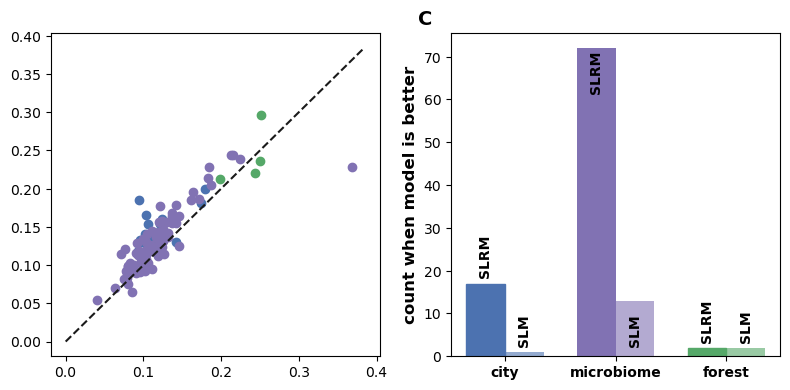

In [31]:
with open(combined_params_path+'BCI_rel_clust_compare_SLRM_SLM_jsd.pkl', 'rb') as handle:
    forest_compare_JSD=pickle.load(handle)  
SLRM_better_ctr_forest=0
slm_better_ctr_forest=0
for i in range(len(forest_compare_JSD['min_jsd_SLRM'])):  
    if forest_compare_JSD['min_jsd_SLRM'][i]<forest_compare_JSD['min_jsd_SLM'][i]:
        SLRM_better_ctr_forest+=1
    elif forest_compare_JSD['min_jsd_SLRM'][i]>forest_compare_JSD['min_jsd_SLM'][i]:
        slm_better_ctr_forest+=1

with open(combined_params_path+'city_compare_SLRM_SLM_jsd.pkl', 'rb') as handle:
        city_compare_JSD=pickle.load(handle)  
SLRM_better_ctr_city=0
slm_better_ctr_city=0
for i in range(len(city_compare_JSD['min_jsd_SLRM'])):  
    if city_compare_JSD['min_jsd_SLRM'][i]<city_compare_JSD['min_jsd_SLM'][i]:
        SLRM_better_ctr_city+=1
    elif city_compare_JSD['min_jsd_SLRM'][i]>city_compare_JSD['min_jsd_SLM'][i]:
        slm_better_ctr_city+=1        

with open(combined_params_path+'microbe_compare_SLRM_SLM_jsd.pkl', 'rb') as handle:
        microbe_compare_JSD=pickle.load(handle)  
SLRM_better_ctr_microbe=0
slm_better_ctr_microbe=0
for i in range(len(microbe_compare_JSD['min_jsd_SLRM'])):  
    if microbe_compare_JSD['min_jsd_SLRM'][i]<microbe_compare_JSD['min_jsd_SLM'][i]:
        SLRM_better_ctr_microbe+=1
    elif microbe_compare_JSD['min_jsd_SLRM'][i]>microbe_compare_JSD['min_jsd_SLM'][i]:
        slm_better_ctr_microbe+=1        


fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1,2,1)
ax3 = fig.add_subplot(1,2,2)


ax1.plot(city_compare_JSD['min_jsd_SLRM'],city_compare_JSD['min_jsd_SLM'],'bo')
ax1.plot(microbe_compare_JSD['min_jsd_SLRM'],microbe_compare_JSD['min_jsd_SLM'],'mo')
ax1.plot(forest_compare_JSD['min_jsd_SLRM'],forest_compare_JSD['min_jsd_SLM'],'go')

max_vals=max(ax1.get_ylim()[1],ax1.get_xlim()[1])
ax1.plot( [0,max_vals],[0,max_vals], 'k--')

width=0.35
ax3.bar(1-width/2, SLRM_better_ctr_city, width,facecolor='b',edgecolor='b')
ax3.bar(1+width/2, slm_better_ctr_city, width,
        facecolor='b', alpha=.6) 
ax3.text(1-width/2, SLRM_better_ctr_city+2, 'SLRM',rotation='vertical',ha='center',
        fontweight="bold")
ax3.text(1+width/2, slm_better_ctr_city+2, 'SLM',rotation='vertical',ha='center',
        fontweight="bold")

ax3.bar(2-width/2, SLRM_better_ctr_microbe, width,facecolor='m')
ax3.bar(2+width/2, slm_better_ctr_microbe, width,
        facecolor='m', alpha=.6) 
ax3.text(2-width/2, SLRM_better_ctr_microbe-10, 'SLRM',rotation='vertical',ha='center',
        fontweight="bold")
ax3.text(2+width/2, slm_better_ctr_microbe-10, 'SLM',rotation='vertical',ha='center',
        fontweight="bold")

ax3.bar(3-width/2, SLRM_better_ctr_forest, width,facecolor='g',edgecolor='g')
ax3.bar(3+width/2, slm_better_ctr_forest, width,
        facecolor='g', alpha=.6)

ax3.text(3-width/2, SLRM_better_ctr_forest+2, 'SLRM',rotation='vertical',ha='center',
        fontweight="bold")
ax3.text(3+width/2, slm_better_ctr_forest+2, 'SLM',rotation='vertical',ha='center',
        fontweight="bold")

ax3.set_xticks([1,2,3])
ax3.set_xticklabels( ['city','microbiome', 'forest'],fontweight="bold" )
ax3.set_ylabel('count when model is better')


ax3.text(-0.1,1.025,'C',fontweight="bold", fontsize=BIGGER_SIZE,
        transform=ax3.transAxes)
plt.tight_layout()
plt.show()

# robustness analysis- varying time interval
analysis is done in combined_analysis.ipynb

## cities

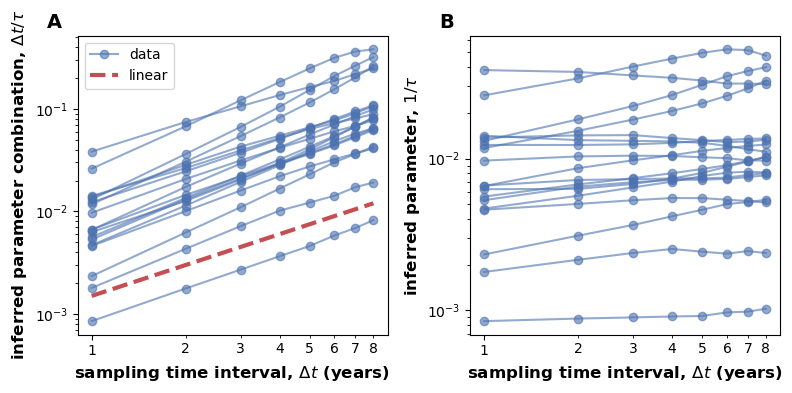

In [52]:
with open(combined_params_path+'city_logG_atAFD_fitvals_vary_Dt.pkl', 'rb') as handle:
    city_logG_atAFD_Dt_params=pickle.load(handle)    
# plot_rescaled_Dt_plots(city_logG_atAFD_Dt_params, naics_key='naics',show_legend=True)
Delta_T_list=np.sort(list(set(city_logG_atAFD_Dt_params['DeltaT'])))
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/SI_robustness_tests_Dt_scaling/'


naics_list=list(set(city_logG_atAFD_Dt_params['naics']))
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
for i, naics in enumerate(naics_list):
    t_over_tau_inferred_list=[]
    bd_inferred_list=[]
    idx_naics=np.where(np.asarray(city_logG_atAFD_Dt_params['naics'])==naics)[0]
    for Dt in Delta_T_list:
        idx_Dt=np.where(np.asarray(city_logG_atAFD_Dt_params['DeltaT'])==Dt)[0]


        idx=int(np.intersect1d(idx_Dt,idx_naics))
        t_over_tau_inferred_list.append(city_logG_atAFD_Dt_params['tp_fit'][idx])
        bd_inferred_list.append(city_logG_atAFD_Dt_params['bd_fit'][idx])

    if i==0:
        ax1.plot(Delta_T_list,t_over_tau_inferred_list, '-o',color='b',alpha=.6, label='data')
    else:
        ax1.plot(Delta_T_list,t_over_tau_inferred_list, '-o',color='b',alpha=.6)
    ax2.plot(Delta_T_list,np.asarray(t_over_tau_inferred_list)*1./np.asarray(Delta_T_list) , 
             '-o',color='b',alpha=.6 ) 
        
ax1.plot(Delta_T_list,Delta_T_list*.0015,'r--',lw=3, label='linear' )

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend(loc=2)
ax2.set_yscale('log')
ax2.set_xscale('log')

ax1.set_xlabel(r'sampling time interval, $\Delta t$ (years) ')
ax1.set_ylabel(r'inferred parameter combination, $\Delta t/\tau$')

ax2.set_xlabel(r'sampling time interval, $\Delta t$ (years)')
ax2.set_ylabel(r'inferred parameter, $1/\tau$')
for ax in [ax1,ax2]:
#     ax.xaxis.set_major_formatter(ScalarFormatter()) 
# #     ax.xaxis.get_major_formatter().set_scientific(False)
#     ax.xaxis.set_minor_formatter(ScalarFormatter()) 
# #     ax.xaxis.get_minor_formatter().set_scientific(False)
#     ax.ticklabel_format(style='plain', axis='x')
    
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_formatter(FormatStrFormatter('%d'))
    
    
ax1.text(-0.1,1.025,'A',fontweight="bold", fontsize=BIGGER_SIZE,
            transform=ax1.transAxes)
ax2.text(-0.1,1.025,'B',fontweight="bold", fontsize=BIGGER_SIZE,
        transform=ax2.transAxes)    
plt.tight_layout()
plt.savefig(dest_path+'city_robustness_vary_Dt.pdf')
plt.show()




    


## microbes

/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


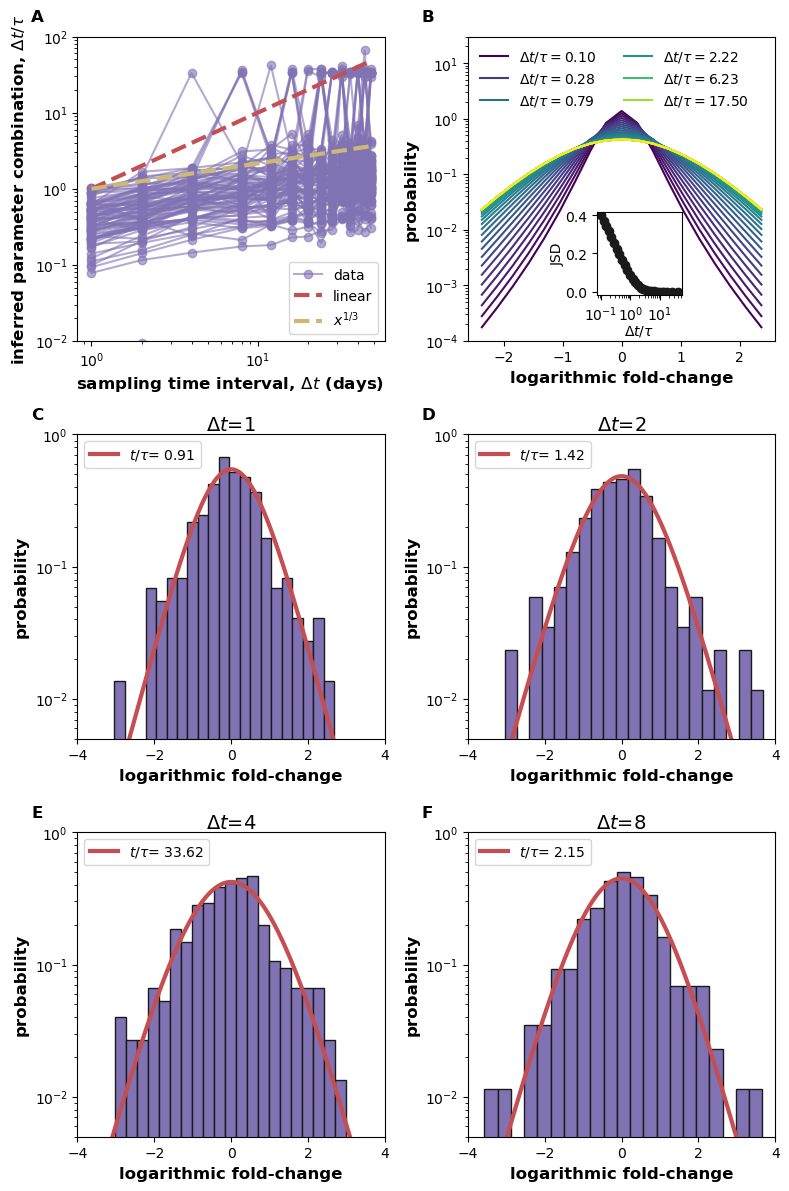

In [10]:
with open(combined_params_path+'microbe_logG_atAFD_fitvals_vary_Dt.pkl', 'rb') as handle:
    microbe_logG_atAFD_Dt_params=pickle.load(handle) 
df_microbe_logG_atAFD_Dt= pd.DataFrame.from_dict(microbe_logG_atAFD_Dt_params)
Delta_T_list=np.sort(list(set(microbe_logG_atAFD_Dt_params['DeltaT'])))
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/SI_robustness_tests_Dt_scaling/'
    
fig = plt.figure(figsize=(8, 12))    
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
ax4 = fig.add_subplot(3,2,4)
ax5 = fig.add_subplot(3,2,5)
ax6 = fig.add_subplot(3,2,6)

ax_list=[ax1,ax2,ax3,ax4,ax5,ax6]
#### ax1###
sp_list=list(set(microbe_logG_atAFD_Dt_params['sp']))
for i, sp in enumerate(sp_list):
    t_over_tau_inferred_list=[]
    bd_inferred_list=[]
    idx_sp=np.where(np.asarray(microbe_logG_atAFD_Dt_params['sp'])==sp)[0]
    for Dt in Delta_T_list:
        idx_Dt=np.where(np.asarray(microbe_logG_atAFD_Dt_params['DeltaT'])==Dt)[0]
        idx=int(np.intersect1d(idx_Dt,idx_sp))
        t_over_tau_inferred_list.append(microbe_logG_atAFD_Dt_params['tp_fit'][idx])
        bd_inferred_list.append(microbe_logG_atAFD_Dt_params['bd_fit'][idx])

    if i==0:
        ax1.plot(Delta_T_list,t_over_tau_inferred_list, '-o',color='m',alpha=.6, label='data')
    else:
        ax1.plot(Delta_T_list,t_over_tau_inferred_list, '-o',color='m',alpha=.6)
        
ax1.plot(Delta_T_list,Delta_T_list,'r--',lw=3, label='linear' )
ax1.plot(Delta_T_list,np.power(Delta_T_list,1./3),'y--',lw=3, label=r'$x^{1/3}$' )

ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.legend(loc=4)

ax1.set_ylim(1e-2, 1e2)
ax1.set_xlabel(r'sampling time interval, $\Delta t$ (days) ')
ax1.set_ylabel(r'inferred parameter combination, $\Delta t/\tau$')

#### ax2   ###
import matplotlib.pylab as pylab

neutral_inst = shared_func.azaele_neutral_logG_distribution()
bins=np.linspace(-2.5,2.5,20)
bin_centers = 0.5*(bins[1:] + bins[:-1])
bd_val=2.5
tp_base=40
tp_arr=np.logspace(np.log10(1e-1),np.log10(tp_base),30)
JSD_list=[]
base_dist=neutral_inst.pdf(bin_centers, tp_base, bd_val, loc=0,scale= 1)
color_list = pylab.cm.viridis(np.linspace(0,1,len(tp_arr)))
for i, tp in enumerate(tp_arr):
    if i%5==0:
        ax2.plot(bin_centers,neutral_inst.pdf(bin_centers, tp, bd_val, loc=0,scale= 1),
                                 '-',color=color_list[i], label=r'$\Delta t/\tau=$'+'{:.2f}'.format(tp))
    else:
        ax2.plot(bin_centers,neutral_inst.pdf(bin_centers, tp, bd_val, loc=0,scale= 1),
                                 '-',color=color_list[i])
    
    JSD_list.append(scipy_spatial_distance.jensenshannon(base_dist,
                                    neutral_inst.pdf(bin_centers, tp, bd_val, loc=0,scale= 1)))
    
    
    ax2.legend(loc=2,ncol=2,frameon=False) 
    ax2.set_yscale('log')
    
# ax2_inset = ax2.inset_axes([0.58, 0.62, 0.4, 0.35])
ax2_inset = ax2.inset_axes([0.42, 0.15, 0.275, 0.275])

ax2_inset.plot(tp_arr,JSD_list, 'k-o')    
# ax2_inset.set_yscale('log')
ax2_inset.set_ylabel('JSD',fontweight='normal', fontsize=SMALL_SIZE,labelpad=0)
ax2_inset.set_xlabel(r'$\Delta t/\tau$',fontweight='normal', fontsize=SMALL_SIZE,labelpad=0)
ax2_inset.set_xscale('log')

ax2.set_ylabel('probability')
ax2.set_xlabel('logarithmic fold-change')
ax2.set_ylim(1e-4,30)
    
#### ax2 to ax6###    
chosen_sp=56
bd_fixed=2.474408 ## the ENR of the chosen species from fitting its SSD/AFD

genus_names_full=caporaso['gtax']
tau=1
time_points=np.squeeze(caporaso['m3_days'])
rel_abu_t_mat_full=caporaso['m3_rel_abu']  
sp_idx=get_abundant_and_prevalent_species_idx(rel_abu_t_mat_full,time_points)
rel_abu_mat=rel_abu_t_mat_full[sp_idx]
genus_names_list=genus_names_full[sp_idx]

DT_vals=np.unique(df_microbe_logG_atAFD_Dt['DeltaT'].values)    
for idx,Dt in enumerate(DT_vals):
    if idx >3:
        break
    ax=ax_list[idx+2]    
    idx_1_list=[]
    idx_2_list=[]
    for j,t2 in enumerate(time_points):
        if np.any(time_points==t2-Dt):
            i=int(np.where(time_points==t2-Dt)[0])
            t1=time_points[i]
    #         print (i,j, t1, t2)
            idx_1_list.append(i)
            idx_2_list.append(j)
    idxs_1=np.array(idx_1_list)
    idxs_2=np.array(idx_2_list)
    
    
    otu_t2=np.ravel(rel_abu_mat[chosen_sp,idxs_2])
    otu_t1=np.ravel(rel_abu_mat[chosen_sp,idxs_1])
    idx_non0=np.intersect1d(np.nonzero(otu_t2), np.nonzero(otu_t1))
    growth_rates=otu_t2[idx_non0]/otu_t1[idx_non0]
    logG=np.log(growth_rates)
    
    n_bins=21
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            logG,10., fbd=bd_fixed, floc=0,fscale=1.)
    mu, sigma=scipy.stats.norm.fit(logG,floc=0)
    _, scale_laplace=scipy.stats.laplace.fit(logG,floc=0)
    histogram, bins = np.histogram(logG, bins=n_bins, density=True)
    bin_centers = 0.5*(bins[1:] + bins[:-1])
    ax.hist(logG, bins=n_bins, density=True,facecolor='m', edgecolor='k')
    
#     ax.plot(bin_centers, neutral_inst.pdf(bin_centers, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut)
#             ,'r-',lw=3,label=r'$t/\tau$= {:.2f}'.format(neut_tp)) 
    
    xpts=np.linspace(-4,4,100)
    ax.plot(xpts, neutral_inst.pdf(xpts, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut)
            ,'r-',lw=3,label=r'$t/\tau$= {:.2f}'.format(neut_tp)) 

    ax.set_title(r'$\Delta t$='+str(int(Dt)),fontweight="normal",transform=ax.transAxes)
    ax.legend(loc=2)

    
    ax.set_yscale('log')
    ax.set_ylim(5e-3,1)
    ax.set_xlim(-4,4)
    ax.set_ylabel('probability')
    ax.set_xlabel('logarithmic fold-change')
    
for i,ax in enumerate(ax_list): 
    ax.text(-0.15,1.05,subplot_label_list[i],fontweight="bold",
            transform=ax.transAxes,fontsize=MEDIUM_SIZE)
plt.tight_layout()
plt.savefig(dest_path+'microbe_robustness_vary_Dt.pdf')
plt.show()




species that displayed funky oscillations

In [9]:
DT_vals

array([ 1,  2,  4,  8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48])

In [92]:
np.unique(df_microbe_logG_atAFD_Dt[df_microbe_logG_atAFD_Dt['tp_fit']>10]['sp'].values)

array([ 1,  2,  6,  7,  9, 15, 21, 22, 23, 34, 35, 36, 42, 47, 48, 49, 52,
       56, 61, 63, 65, 68, 69, 72, 84])

In [94]:
len(np.unique(df_microbe_logG_atAFD_Dt[df_microbe_logG_atAFD_Dt['tp_fit']>10]['sp'].values))

25

# are forest clusters significantly different?
- analysis is in combined_analysis.ipynb

## plot overlaid distributions

/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:138: RuntimeWarning: divide by zero encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:138: RuntimeWarning: invalid value encountered in true_divide
/Users/ashish/anaconda3/envs/cities/lib/python3.7/site-packages/ipykernel_launcher.py:138: RuntimeWarning: divide by zero encountered in true_divide


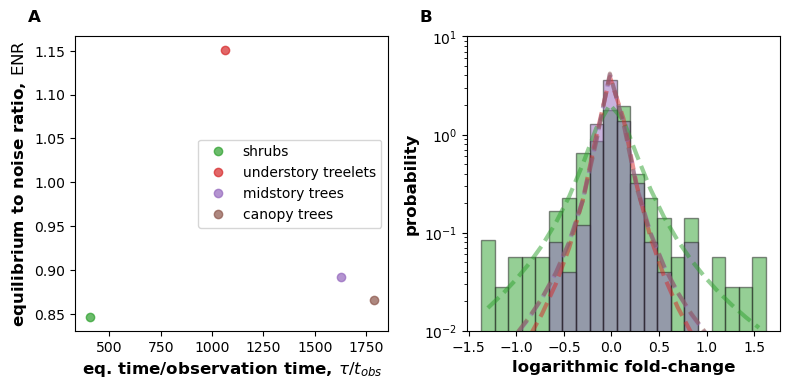

In [58]:
neutral_inst = shared_func.azaele_neutral_logG_distribution()
fig = plt.figure(figsize=(8, 4))
ax1 = fig.add_subplot(1,2,2)
# ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(1,2,1)
# ax4 = fig.add_subplot(2,2,4)

is_rel_abundances=True
color_list=list(sns.color_palette(palette='tab10',n_colors=10))
# color_list=list(sns.color_palette(palette='deep',n_colors=5))
color_list=color_list[1:]
n_bins=21


with open(combined_params_path+'BCI_rel_logG_clustfitvals.pkl', 'rb') as handle:
    BCI_rel_clust_logG_dict=pickle.load(handle) 
with open(combined_params_path+'BCI_rel_clust_AFD_shape_error_estimates.pkl', 'rb') as handle:
    BCI_rel_clust_SSD_dict=pickle.load(handle) 
BCIclust_mD_vals= np.array(BCI_rel_clust_logG_dict['bd_fit'])
BCIclust_tau_vals= 5./np.array(BCI_rel_clust_logG_dict['tp_fit']    ) #in years

BCIclust_mD_vals2= np.array(BCI_rel_clust_SSD_dict['a_gamma_true'])
BCIclust_Scale_vals= np.array(BCI_rel_clust_SSD_dict['scale_gamma_true']    ) 

cluster_id_list=[1,3] 
for i, clust_id in enumerate(np.arange(1,5)):
    if is_rel_abundances:
        BCI_logG_clusti=get_BCI_clust_logG(df_BCI_rel_clust,clust_id)   
    else:
        BCI_logG_clusti=get_BCI_clust_logG(df_counts,clust_id)    
    neut_tp, neut_bd, loc_neut, scale_neut = neutral_inst.fit(
            BCI_logG_clusti,10., 1., floc=0,fscale=1.)
    if i==0: ## only one set of bins across all the data
        histogram, bins_LFD = np.histogram(BCI_logG_clusti, bins=n_bins, density=True)
        bin_centers_LFD = 0.5*(bins_LFD [1:] + bins_LFD [:-1])
    if clust_id in cluster_id_list : # then plot the histogram   
        ax1.hist(BCI_logG_clusti, bins=bins_LFD , density=True,facecolor=color_list[clust_id],
                edgecolor='k', alpha=0.5)#, label=tree_clust_names[clust_id-1]
    ax1.plot(bin_centers_LFD, neutral_inst.pdf(bin_centers_LFD, neut_tp, neut_bd, loc=loc_neut,scale= scale_neut),
             '--',color=color_list[clust_id],alpha=0.5, lw=3,label=tree_clust_names[clust_id-1]) 
#     ax.set_title(tree_clust_names[clust_id-1])
    
    ### for SSD
#     if is_rel_abundances:
#         clust_popn_1995=df_BCI_rel_clust[df_BCI_rel_clust['height_cluster']==clust_id]['Y1995'].values
#     else:
#         clust_popn_1995=df_counts[df_counts['height_cluster']==clust_id]['Y1995'].values
#     clust_popn_1995=clust_popn_1995[clust_popn_1995>0]
    
#     a_gamma,dummy_loc_gamma, scale_gamma=scipy.stats.gamma.fit(
#                                 clust_popn_1995, 10,floc=0.,scale=2 )

#     BCI_shape_gamma=a_gamma
#     BCI_scale_gamma=scale_gamma
#     if i==0: ## only one set of bins across all the data
#         histogram, bins_SSD = np.histogram(clust_popn_1995, bins=n_bins, density=True)
#         bin_centers_SSD = 0.5*(bins_SSD[1:] + bins_SSD[:-1])
#     ax2.hist(clust_popn_1995, bins=bins_SSD, density=True,facecolor=color_list[clust_id],edgecolor='k', 
#              cumulative=-1,alpha=0.5, label=tree_clust_names[clust_id-1])
#     ax2.plot(bin_centers_SSD, 1-scipy.stats.gamma.cdf(bin_centers_SSD, a_gamma,
#             loc=0, scale= scale_gamma), 'k-',lw=3) 
    
    
    
    
for i, clust_id in enumerate(np.arange(1,5)):
    ax3.plot(BCIclust_tau_vals[i],BCIclust_mD_vals[i],'o',color=color_list[clust_id],
             alpha=0.7, label=tree_clust_names[clust_id-1])
    
#     ax4.plot(BCIclust_mD_vals2[i],BCIclust_mD_vals[i],'o')

ax1.text(-0.15,1.05,'B',fontweight="bold",
        transform=ax1.transAxes,fontsize=MEDIUM_SIZE)
ax1.set_ylim(1e-2,10) 
ax1.set_yscale('log')
# ax1.legend(loc=1)
ax1.set_xlabel(r'logarithmic fold-change')
ax1.set_ylabel(r'probability')


ax3.legend(loc='best')
ax3.text(-0.15,1.05,'A',fontweight="bold",
        transform=ax3.transAxes,fontsize=MEDIUM_SIZE)

ax3.set_xlabel(r'eq. time/observation time, $\tau /t_{obs}$')
ax3.set_ylabel(r'equilibrium to noise ratio, $\mathrm{ENR}$')


plt.tight_layout()
dest_path='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/comparing forest clusters//'
plt.savefig(dest_path+'comparing_forest_clusters.pdf')
plt.show()


In [31]:
BCI_rel_clust_logG_dict['bd_fit']

[0.845958616183567, 1.151220108181408, 0.8920823330684438, 0.865278644968309]

In [36]:
BCI_rel_clust_SSD_dict.keys()

dict_keys(['height_cluster', 'a_gamma_true', 'scale_gamma_true', 'xfactors', 'a_guess_arr', 'scale_gamma_guess_fit', 'pctile_scores', 'ks_pctile_scores', 'year'])

# table of naics categories

In [12]:
df_naics_sectors_table={'naics code':[], 'sector name (full)':[], 'sector name (short)':[]}

for naics in naics_colnames:
#     print (naics)
#     print(shared_func.sector_from_naics(df_naics_ref, naics, shorten=False))
    
    df_naics_sectors_table['naics code'].append(naics.replace('naics_',''))
    full_name=shared_func.sector_from_naics(df_naics_ref, naics, shorten=False)
    df_naics_sectors_table['sector name (full)'].append(full_name)
    short_name=shared_func.sector_from_naics(df_naics_ref, naics, shorten=True)
    df_naics_sectors_table['sector name (short)'].append(short_name)
    
df_naics_sectors_table=pd.DataFrame.from_dict(df_naics_sectors_table)  
destpath='/Users/ashish/Dropbox/research/James-research/BDI manuscript/figures/SI_table_naics/'
df_naics_sectors_table.to_csv(destpath+'naics_table.csv', header=True)


In [8]:
df_naics_sectors_table

{'naics code': ['11'],
 'sector name': ['Agriculture, Forestry, Fishing and Hunting'],
 'short name': ['Agriculture']}